In [93]:
%load_ext autoreload
% autoreload 2
from __future__ import print_function
import argparse
import os, datetime
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
print(torch.__version__)
from geant_dataloader import rtnpy_load_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from torch.autograd import grad
#from logistics import sigmoid_normalize, logistic_unnormalize, tanh_normalize, arctanh_unnormalize
from logistics import *
from matplotlib import gridspec
plt.rc('font', family='serif')
from decimal import Decimal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.4.0a0+200fb22


In [131]:
workers = 2
batchSize = 32
imageSize =32
nz = 100
ngf = 64
ndf = 64
nc = 1
niter = 100
lr = 2e-4
beta1 = 0.5
cuda = 'store_true'
netG_path = "output/"
netD_path = "output/"
outf = "output/"
manualSeed = 25
ngpu = 1
mydir=None # will be updated before the run
epoch=0 #will be updated during the run
extraD = 1
epochs = []
genx_FWHMs = []
genx_means = []
realx_FWHMs = []
realx_means =  []


norm_scale = 'none'

try:
    os.makedirs(outf)
except OSError:
    pass



In [132]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True
dev_type = 'cpu'
if torch.cuda.is_available():
    print("Using Cuda")
    dev_type = 'gpu'
    
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print("Using:", dev_type, torch.cuda.current_device())


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Random Seed:  25
Using Cuda
cuda:1
Using: gpu 0


In [133]:
# LOAD DATA:

#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_20000Events_64OldSize_32NewSize.npy", image_size = imageSize)
image_array = rtnpy_load_data("numpy_data/geant4Data_30000Events_"+str(imageSize) + "ImageSize_800MeV_ScintiAbsoThickness75_8.npz", image_size = imageSize)


In [134]:

normed_array, scale = normalize(image_array, norm_scale = norm_scale )
print(image_array.shape)
tensor_array = torch.stack([torch.tensor(i, requires_grad =False).type(torch.FloatTensor) for i in normed_array])
tensor_data = torch.utils.data.TensorDataset(tensor_array)
dataloader = torch.utils.data.DataLoader(tensor_data, batch_size=batchSize, num_workers=8)
dataloader

(30000, 1, 32, 32)


In [145]:
if norm_scale == 'unif':
    last_layer = nn.LeakyReLU()
elif norm_scale == 'none' or norm_scale =='0to5':
    last_layer = nn.LeakyReLU(0.0009)
else:
    last_layer = nn.Sigmoid()


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(nz, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 400),
            nn.LeakyReLU(),
            nn.Linear(400, 800),
            nn.LeakyReLU(inplace=True),
            nn.Linear(800, image_array.shape[2] * image_array.shape[2]),
            last_layer
            # input is Z, going into a convolution
         
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(imageSize * imageSize, 1400),
            nn.ReLU(inplace=True),
            nn.Linear(1400, 800),
            nn.ReLU(inplace=True),
            nn.Linear(800, 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)
    
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

print(netD)


Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=400, out_features=800, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace)
    (6): Linear(in_features=800, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.0009)
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=1024, out_features=1400, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=1400, out_features=800, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=800, out_features=300, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=300, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [146]:
# def make_samples(netG, n_events=500, real=True, fake = True, avg= True, scale = scale, norm_scale = norm_scale, nz=nz ):

#     #test_image = 0#fake.to('cpu').detach().numpy()[0][0]
#     fake_image = 0 #arctanh_unnormalize(test_image, scale)
#     real_image = 0
#     for i in range(n_events):
#         idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
#         real_image += image_array[idx][0]
#         #noise = torch.randn(batchSize, nz, 1, 1, device=device)
#         noise = torch.randn(batchSize, nz, device=device)
#         fake_output = netG(noise)
#         #print(fake_output.shape)
        
#         gen_image = fake_output.to('cpu').detach().numpy()[0].reshape((imageSize,imageSize))
#         fake_image +=  unnormalize(gen_image, scale, norm_scale = norm_scale)
#         #fake_image += logistic_unnormalize(test_image, scale)
#     if avg == True:
#         fake_image = fake_image / n_events
#         real_image = real_image / n_events

#     #test_noNans = np.copy(test_unnormed)
#     #test_unnormed[test_unnormed < 0.0] = np.nan
#     if real == True and fake == True:
#         return [real_image,fake_image], n_events
#     elif (real == False) and (fake == True):
#         return fake_image, n_events
#     else:
#         return real_image, n_events
    
    
    


# def make_stacked_samples(netG, n_events, real=False, fake=True, norm_scale = norm_scale, scale = scale, nz=nz):
#     fake_images = []
#     real_images = []
#     for i in range(n_events):
#         idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
#         real_image = image_array[idx][0]
#         #noise = torch.randn(batchSize, nz, 1, 1, device=device)
#         noise = torch.randn(batchSize, nz, device=device)
#         fake_output = netG(noise)
#         fake_image = fake_output.to('cpu').detach().numpy()[0].reshape((imageSize,imageSize))
#         fake_image = unnormalize(fake_image,scale, norm_scale = norm_scale)
#         fake_images.append(fake_image)
#         real_images.append(real_image)
        
#     fake_images_array = np.dstack(fake_images).T
#     real_images_array = np.dstack(real_images).T
#     if real == True and fake == True:
#         return real_images_array,fake_images_array
#     elif (real == False) and (fake == True):
#         return fake_images_array
#     else:
#         return real_images_array


# def plot_avg(data, n_events, withMarginals=True, save_dir = mydir, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr):

#     test_noNans = np.copy(data)
#     test_unnormed = data
#     test_unnormed[test_unnormed < 0.0] = np.nan
    
#     fig=plt.figure(figsize=(6, 6))
#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran
#     cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#     color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()
    
#     if withMarginals == False:
#         marginals_str = 'woMarginals'
#         plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
#         im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
#         cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
#         cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
#         if save_dir != None:
#             #directory = "/home/chris/Documents/MPhilProjects/ForViewing/Geant4/SingleLayerEGun/AverageImage/"
#             filename = "DCROTHGAN_AvgEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                         + "Image_Epochs" + str(epoch) + "_" + str(batchSize) + "batchSize_" +  str(lr) + "lr"
#             plt.savefig(directory + filename)
        
#     else:
#         marginals_str = 'withMarginals'
#         img=test_noNans
#         t = np.arange(-50,50, 100/float(imageSize))
#         #t = np.arange(img.shape[0])
#         f = np.arange(-50,50, 100/float(imageSize))
#         #f = np.arange(img.shape[1])
#         flim = (f.min(), f.max())
#         tlim = (t.min(), t.max())

#         gs = gridspec.GridSpec(2, 2, width_ratios=[1,5], height_ratios=[1,5])
#         gs.update(hspace=0, wspace=0)

#         ax = fig.add_subplot(gs[1,1])
#         im = ax.imshow(test_unnormed, vmin = 0, extent = extent, origin = 'lower', cmap = cmap)
#         cbaxes = fig.add_axes([0.97, 0.18, 0.03, 0.55]) 
#         cbar = plt.colorbar(mappable=im, ticks = None, cax=cbaxes, use_gridspec=True)
#         ax.yaxis.set_ticks_position('right')
#         cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
#         ax.spines["top"].set_visible(False)
#         ax.spines['left'].set_visible(False)

#         axl = fig.add_subplot(gs[1,0], sharey=ax)
#         axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
#         axl.invert_xaxis()
#         axb = fig.add_subplot(gs[0,1], sharex=ax)
#         axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])

#         plt.setp(axl.get_yticklabels(), visible=False)
#         plt.setp(axb.get_xticklabels(), visible=False)
#         plt.setp(axl.get_xticklabels(), visible=False)
#         plt.setp(axb.get_yticklabels(), visible=False)

#         axl.yaxis.set_ticks_position('none')
#         axb.xaxis.set_ticks_position('none')
#         axl.xaxis.set_ticks_position('none')
#         axb.yaxis.set_ticks_position('none')


#         axl.spines["top"].set_visible(False)
#         axl.spines['right'].set_visible(False)
#         axl.spines['left'].set_visible(False)
#         axl.spines['bottom'].set_visible(False)
#         axb.spines["top"].set_visible(False)
#         axb.spines["right"].set_visible(False)
#         axb.spines["left"].set_visible(False)
#         axb.spines["bottom"].set_visible(False)
#         ax.set_xlim(tlim)
#         ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
#         ax.xaxis.set_label_coords(0.02,-0.05)
#         ax.set_ylim(tlim)
#         ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
#         ax.yaxis.set_label_coords(1.07,0.98)
#         if save_dir != None:
#             learning_rate = '%.0E' % Decimal(lr)
#             #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
#             filename = "DCROTHGAN_AvgEdep"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                         + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
#             plt.savefig(save_dir + filename, bbox_inches='tight')
#         plt.show()
#     return

# def plot_samples(n_samples = 3 ):
#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran
#     vmin = 0.1
#     vmax = 2.0
#     fig, ax_arr = plt.subplots(1, n_samples, figsize=(10,10), sharey = True, sharex=True)
#     i = 0
#     for ax in ax_arr.flatten():
        
#         #noise = torch.randn(batch_size, nz, 1, 1, device=device)
#         noise = torch.randn(batch_size,nz, device=device)
#         fake = netG(noise)
#         test_image = fake.to('cpu').detach().numpy()[0][0]
#         test_unnormed =  arctanh_unnormalize(test_image, scale)
#         test_unnormed[test_unnormed < 0.1] = np.nan
#         cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#     #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
#         im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
#         if i == 0:   
#             cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
#         i+=1
#     plt.show()
#     return

# def plot_sns(n_events = 500, n_samples = 3, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
#     fig, axn = plt.subplots(1, n_samples, figsize=(12,4), sharex=True, sharey=True)
#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran

#     #xticks = [-50,-25,0,25,50]
#     #yticks = [-50,-25,0,25,50]
#     for i, ax in enumerate(axn.flat):
#         #noise = torch.randn(batchSize, nz, 1, 1, device=device)
#         noise = torch.randn(batchSize,nz, device=device)
#         fake = netG(noise)
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         ax.spines['bottom'].set_visible(True)
#         if i != 0:
#             ax.spines['left'].set_visible(False)
#         if i == 0:
#             ax.set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
#             ax.set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
#         ax.set_title("Ex " +str(i), x =0.85, y = 0.88, alpha=0.6, fontweight='heavy', fontsize=11)
#         test_image = fake.to('cpu').detach().numpy()[0][0]
#         test_unnormed =  unnormalize(test_image, scale)
#         #test_unnormed = logistic_unnormalize(test_image, scale)
#         test_unnormed[test_unnormed < 0.1] = np.nan
#         cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#         #sns.heatmap(test_unnormed, ax=ax, cmap=cmap,
#         #            cbar=i == 0, cbar_ax=None if i else cbar_ax, square=True,
#         #            vmin = 0, vmax = 80, xticklabels = xticks, yticklabels=xticks)
#         im = ax.imshow(test_unnormed, vmin = 0, vmax=10, extent=extent, origin='lower', cmap=cmap)
#         ax.tick_params(axis=u'both', which=u'both',length=0)

#     fig.tight_layout(rect=[0, 0, .9, 1])
#     cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
#     fig.colorbar(im, cax=cbar_ax)
#     fig.subplots_adjust(wspace=0.1, hspace=0)
#     fig.suptitle("Samples of Generated Electron Gun Energy Depositions",x=0.5,y=0.99)
#     if save_dir != None:
#         learning_rate = '%.0E' % Decimal(lr)
#         #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
#         filename = "DCROTHGAN_3SampleEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                     + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
#         plt.savefig(save_dir + filename, bbox_inches='tight')
#     plt.show()
#     return



# def plot_avg_both(real_data, fake_data, n_events, withMarginals=True, save_dir=None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
#     fig=plt.figure(figsize=(10,5))
#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran

#     #real_data = real_image
#     img = real_data
#     test_unnormed = fake_data
#     test_noNans = np.copy(test_unnormed)
#     img2 = test_noNans
#     t = np.arange(-50,50, 100/float(imageSize))
#     #t = np.arange(img.shape[0])
#     f = np.arange(-50,50, 100/float(imageSize))
#     #f = np.arange(img.shape[1])
#     flim = (f.min(), f.max())
#     tlim = (t.min(), t.max())


#     gs = gridspec.GridSpec(2, 4, width_ratios=[5,1,1,5], height_ratios=[1,5])
#     gs.update(hspace=0, wspace=0)
#     ax1 = fig.add_subplot(gs[1,0])
#     axl = fig.add_subplot(gs[1,1], sharey=ax1)
#     axb = fig.add_subplot(gs[0,0], sharex=ax1)
#     ax2 = fig.add_subplot(gs[1,3])
#     axl2= fig.add_subplot(gs[1,2], sharey=ax2)
#     axb2= fig.add_subplot(gs[0,3], sharex=ax2)
#     plt.setp(axl.get_yticklabels(), visible=False)
#     plt.setp(axb.get_xticklabels(), visible=False)
#     plt.setp(axl.get_xticklabels(), visible=False)
#     plt.setp(axb.get_yticklabels(), visible=False)
#     plt.setp(axl2.get_yticklabels(), visible=False)
#     plt.setp(axb2.get_xticklabels(), visible=False)
#     plt.setp(axl2.get_xticklabels(), visible=False)
#     plt.setp(axb2.get_yticklabels(), visible=False)
#     axl.yaxis.set_ticks_position('none')
#     axb.xaxis.set_ticks_position('none')
#     axl.xaxis.set_ticks_position('none')
#     axb.yaxis.set_ticks_position('none')
#     axl2.yaxis.set_ticks_position('none')
#     axb2.xaxis.set_ticks_position('none')
#     axl2.xaxis.set_ticks_position('none')
#     axb2.yaxis.set_ticks_position('none')
#     cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#     im = ax1.imshow(real_data, vmin = 0, extent =extent, origin='lower', cmap=cmap)
#     ax1.spines["top"].set_visible(False)
#     ax1.spines['right'].set_visible(False)
#     #ax.spines['left'].set_visible(False)
#     color_list = sns.cubehelix_palette(dark=0.4, light=0.915, gamma=2.5, hue=1).as_hex()
#     axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
#     axl.spines["top"].set_visible(False)
#     axl.spines['right'].set_visible(False)
#     axl.spines['left'].set_visible(False)
#     axl.spines['bottom'].set_visible(False)
#     axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])
#     axb.spines["top"].set_visible(False)
#     axb.spines["right"].set_visible(False)
#     axb.spines["left"].set_visible(False)
#     axb.spines["bottom"].set_visible(False)
#     ax1.set_xlim(tlim)
    
#     ax1.set_ylim(tlim)


#     #RECONSIDER TAKING OUT THE LESS THAN 0 VALUES
#     real_data[real_data < 0.0] = np.nan 


#     test_unnormed[test_unnormed < 0.0] = np.nan

#     im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
#     ax2.spines["top"].set_visible(False)
#     ax2.spines['left'].set_visible(False)
#     axl2.fill_between(img2.mean(1), f, alpha = 0.7, color = color_list[1])
#     axl2.invert_xaxis()
#     axl2.spines["top"].set_visible(False)
#     axl2.spines['right'].set_visible(False)
#     axl2.spines['left'].set_visible(False)
#     axl2.spines['bottom'].set_visible(False)
#     axb2.fill_between(t, img2.mean(0), alpha =0.7, color= color_list[1])
#     axb2.spines["top"].set_visible(False)
#     axb2.spines["right"].set_visible(False)
#     axb2.spines["left"].set_visible(False)
#     axb2.spines["bottom"].set_visible(False)
#     ax2.set_xlim(tlim)
#     ax2.set_ylim(tlim)

#     ax1.set_xlabel("Real", fontsize=11)  
#     ax2.set_xlabel("Generator", fontsize=11)
#     ax1.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
#     ax1.yaxis.set_label_coords(-0.07,0.98)
#     fig.tight_layout(rect=[0, 0, .9, 1])
#     cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.45])
#     cb = fig.colorbar(im, cax=cbar_ax)
#     cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
#     plt.figtext(0.05,0.060,r"$\mathit{x}$", fontsize = 12)
#     fig.subplots_adjust(wspace=0.1, hspace=0)
#     fig.suptitle(r" DCROTHGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
#                  + str(imageSize) + "x" +str(imageSize) + " \n Image Size, " + str(epoch) 
#                  + " Epochs, " + str(batchSize) + " Batch Size", x = 0.46, y = 0.02)
#     if save_dir != None:
#         learning_rate = '%.0E' % Decimal(lr)
#         #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
#         filename = "DCROTHGAN_RealandFakeAvgEdep"+str(withMarginals) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                             + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
#         plt.savefig(save_dir + filename, bbox_inches='tight')
#     plt.show()
#     return



# def plot_many(data, rows = 1,columns = 4, real = True, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran
    
#     if rows <= 2 and columns <=4:
#         scale_factor = 3.5
#     else:
#         scale_factor = 2
    
#     fig, axes =plt.subplots(rows,columns, figsize=(scale_factor*columns, scale_factor*rows), sharex=True,sharey=True)
#     #print(len(axes))
#     event_number = 0
#     plt.locator_params(axis='y', nbins=1)
#     plt.locator_params(axis='x', nbins=2)
#     #fig.xticks(rotation=45)
#     for i in range(rows):
#         for j in range(columns):

#             #print(range(rows))
#             image_array = data[event_number]

#             image_array[image_array < 0.01] = np.nan
#             cmap = sns.cubehelix_palette(dark = 0.4, light=0.965, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#             #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
#             #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
#             #cmap = sns.color_palette("BrBG",7)
#             #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)
#             #axes[i,j].set_aspect('equal')
#             plt.axis('on')
#             if rows == 1:
#                 #axes[j] = plt.subplot(gs1[i,j])
#                 if j != 0:
#                     axes[j].spines['left'].set_visible(False)
#                 else:
#                     axes[j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
#                     axes[j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
#                 axes[j].spines['top'].set_visible(False)
#                 axes[j].spines['right'].set_visible(False)
#                 #axes[j].spines['bottom'].set_visible(False)
#                 #axes[j].spines['left'].set_visible(False)
#                 #axes[j].set_aspect('equal')
#                 im =axes[j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
#                 #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
#                 axes[j].set_xticklabels([])
#                 axes[j].set_yticklabels([])
#                 axes[j].xaxis.set_ticks_position('none')
#                 axes[j].yaxis.set_ticks_position('none')
#                 event_number +=1
#             else:
#                 #axes[i,j].spines['top'].set_visible(False)
#                 axes[i,j].spines['bottom'].set_visible(True)
#                 if j!= 0:
#                     axes[i,j].spines['left'].set_visible(False)
#                 if i == range(rows)[-1] and j == 0:
#                     axes[i,j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
#                     axes[i,j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                    
#                 if j == range(columns)[-1]:
#                     axes[i,j].spines['right'].set_visible(True)
#                 else:
#                     axes[i,j].spines['right'].set_visible(False)
#                 im =axes[i,j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
#                 #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
#                 axes[i,j].set_xticklabels([])
#                 axes[i,j].set_yticklabels([])
#                 axes[i,j].xaxis.set_ticks_position('none')
#                 axes[i,j].yaxis.set_ticks_position('none')
#                 event_number +=1
#     #fig.tight_layout(rect=[0, 0, .9, 1])
#     cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.66])
#    # fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
#     #fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)

#     cb = fig.colorbar(im, cax=cbar_ax)
#     cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
#     #plt.tight_layout()
#     fig.subplots_adjust(wspace=-0.085, hspace=0.00)
#     if real == True:
#         fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions", y = 0.95)
#     else:
#         fig.suptitle("DCROTHGAN Samples of Generator Electron Gun Energy Depositions, Epoch " + str(epoch), y=0.95)
    
#     num_samples = rows *columns
        
        
#     if save_dir != None:
#         if real == True:
#             type_string = "real"
#         else:
#             type_string = "fake"
        
#         learning_rate = '%.0E' % Decimal(lr)
#         #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
#         filename = "DCROTHGAN_"+str(num_samples) + type_string+ "SamplesEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                             + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
#         #print(save_dir)
#         plt.savefig(save_dir + filename, bbox_inches='tight')
    
        
#     plt.show()
#     return


# def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
# #mean_normalizer = data_test[1][data_test[1] > 0.0].max()
#     data = (real_fake_list[0] - real_fake_list[1]) 
# #plot_avg(data_diff, n_events = 5000, save_dir=None)
#     test_noNans = np.copy(data)
#     test_unnormed = data
# #test_unnormed[test_unnormed < ] = np.nan

#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran
    
#     if imageSize == 64:
#         vmin = -5
#         vmax = 5
#     elif imageSize == 32:
#         vmin = -10
#         vmax = 10
    
#     t = np.arange(-50,50, 100/float(imageSize))
#     #t = np.arange(img.shape[0])
#     f = np.arange(-50,50, 100/float(imageSize))
#     #f = np.arange(img.shape[1])
#     flim = (f.min(), f.max())
#     tlim = (t.min(), t.max())
#     #cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
#     #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
#     #cmap = sns.color_palette("BrBG", 7, as_cmap=True)
#     cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
#     color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()


#     fig, ax=plt.subplots(figsize=(6, 6))
#     #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
#     im = ax.imshow(test_unnormed, vmin = vmin,vmax = vmax, extent=extent, origin='lower', cmap='PuOr', label ='DCROTHGAN')
#     cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
#     cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
#     plt.title(r"$E_{avg}^{G4} - E_{avg}^{GAN}$, Epoch " + str(epoch))
#     ax.text(-45, 39, 'DCROTHGAN', color='black', 
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
#     #plt.legend(loc = 'best')
#     ax.set_xlim(tlim)
#     ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
#     ax.xaxis.set_label_coords(0.51,-0.08)
#     ax.set_ylim(tlim)
#     ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
#     ax.yaxis.set_label_coords(-.1,0.48)
#     ax.spines["top"].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(True)
#     ax.spines['bottom'].set_visible(True)
    
#     if save_dir != None:
#         learning_rate = '%.0E' % Decimal(lr)
#         #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
#         filename = "DCROTHGAN_EdepDifferenceOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                     + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
#         plt.savefig(save_dir + filename, bbox_inches='tight')

#     plt.show()
#     return



# def plot_FWHMs(gen_FWHMs, real_FWHMs, epochs = epochs, n_epochs=niter,  bs=batchSize, extraD=extraD, norm_scale=norm_scale, save_dir = None):



#     print(type(bs))
#     FWHM_comp =  "FWHMComp_Egun_Edep_DCGAN_" + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" +  \
#                 str(extraD) + "ExtraD " + str(norm_scale) +  "normalized "
#     fig = plt.figure(figsize=(6,4))
#     plt.scatter(epochs, real_FWHMs, alpha = 0.8, label='Geant4')
#     plt.scatter(epochs, gen_FWHMs, alpha = 0.8,  label='generator')
#     plt.xlabel("Epoch", fontsize = 12.5)
#     plt.ylabel("FWHM", fontsize = 12.5)
#     #plt.ylim(0,50)
#     plt.xlim(0,n_epochs)
#     plt.title(r" FWHM  for $E_{dep}$ diff, $N_{D}$ =" +  str(extraD) + " Batch Size " + str(bs) + " Input Norm " + str(norm_scale), fontsize=11)
#     plt.legend(loc='best')
#     if save_dir != None:
        
#         plt.savefig(save_dir + FWHM_comp)
#     plt.show()

#     return 

# def hist_width(hist_data):

#     mean = hist_data.mean()
#     std = hist_data.std()
#     FWHM = 2.*np.sqrt(2.*np.log(2.))*std
#     #line2 = FWHM - (FHWM / 2)
#     #line1 = line2 - FWHM

#     return FWHM

# def plot_all_metrics(gen_FWHMs, g4_FWHMs, gen_means, g4_means, epochs, bs=batchSize, n_epochs =niter, extraD = extraD, norm_scale=norm_scale, save_dir =None):

# #     if gamma == 0.1:
# #         gamma_val = str('01')
# #     elif gamma == 0.5:
# #         gamma_val = str('05')
# #     elif gamma == 1.0:
# #         gamma_val = str('1')

#     #gen_means = np.array(gen_means)
#     #gen_means = gen_means
#     #gen_kurts = gen_means[:,1]
#     #g4 = np.array(g4_means)
#     #g4_means = g4_means
#     #g4_kurts = g4_means[:,1]

#     #if Kurts == True:
#     #    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4), sharey = False, sharex = True)

#     #else:

#     #print(type(gen_FWHMs), type)
#     fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4), sharey = False, sharex = True)

#     ax1.scatter(epochs, g4_FWHMs, alpha = 0.75, label = 'geant4');
#     ax1.scatter(epochs, gen_FWHMs, alpha = 0.70, label = 'generator');
#     ax1.set_title("FWHMs")
#     if len(epochs) < n_epochs/2:
#         ax1.set_xlim(0,n_epochs /2)
#     else:
#         ax1.set_xlim(0,n_epochs)
#     fig.suptitle(r" Distribution Metrics for $E_{dep}$, $N_{D}$ =" + str(extraD) + " Batch Size " + str(bs) + " Input Norm " 
#         + str(norm_scale), x=0.5, y = 1.02, fontsize = 14) 
#     #plt.xlabel(r"Difference in $P_{T}$ compared to Ground Truth")
#     #ax1.set_xlabel(r"$P_{T} - P_{T}^{sim} $ (MeV)", fontsize = 16)
#     #ax1.set_ylabel("FWHM", fontsize = 14)
#     #ax1.set_ylim(0,9000)

#     ax2.scatter(epochs, g4_means, alpha = 0.75, label = 'geant4');
#     ax2.scatter(epochs, gen_means, alpha = 0.70, label = 'generator');
#     ax2.set_title("Means")
#     if len(epochs) < n_epochs/2:
#         ax2.set_xlim(0,n_epochs /2)
#     else:
#         ax2.set_xlim(0,n_epochs)

# #     if Kurts == True:
# #         ax3.scatter(epochs, delphes_kurts,alpha = 0.75, label = 'delphes');
# #         ax3.scatter(epochs, gen_kurts, alpha = 0.70, label = 'generator');
# #         ax3.set_title("Kurtoses")
# #         ax3.set_ylim(0,5)

#     fig.text(0.5, -0.01, "Epoch", ha = 'center', fontsize = 15)
#     ax1.legend(loc='best')
#     #if Kurts == True:
#     #    ax1.legend(bbox_to_anchor=[3.94, 0.5], loc='center right')
#     #else:
#     ax1.legend(bbox_to_anchor=[2.64, 0.5], loc='center right')


#     if save_dir != None:
#         FWHMs_Means_comp =  'FHWMsMeans_Edep_EGunDCGAN_'  \
#              + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" \
#               + str(extraD) + "ExtraD_" + str(norm_scale) + "Normalized"

#         #file_path = "/home/chris/Documents/MPhilProjects/ForViewing/plots/eGunPTSmearing/FWHMsMeans/"
#         plt.savefig(save_dir + FWHMs_Means_comp, bbox_inches="tight")

#     plt.show()

#     return



In [151]:
# def make_samples(netG, n_events=500, real=True, fake = True, avg= True, scale = scale, norm_scale = norm_scale ):

#     #test_image = 0#fake.to('cpu').detach().numpy()[0][0]
#     fake_image = 0 #arctanh_unnormalize(test_image, scale)
#     real_image = 0
#     for i in range(n_events):
#         idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
#         real_image += image_array[idx][0]
#         #noise = torch.randn(batchSize, nz, 1, 1, device=device)
#         noise = torch.randn(batchSize, nz, device=device)
#         fake_output = netG(noise)
#         gen_image = fake_output.to('cpu').detach().numpy()[0][0]
#         fake_image +=  unnormalize(gen_image, scale, norm_scale = norm_scale)
#         #fake_image += logistic_unnormalize(test_image, scale)
#     if avg == True:
#         fake_image = fake_image / n_events
#         real_image = real_image / n_events

#     #test_noNans = np.copy(test_unnormed)
#     #test_unnormed[test_unnormed < 0.0] = np.nan
#     if real == True and fake == True:
#         return [real_image,fake_image], n_events
#     elif (real == False) and (fake == True):
#         return fake_image, n_events
#     else:
#         return real_image, n_events

def make_samples(netG, n_events=500, real=True, fake = True, avg= True, scale = scale, norm_scale = norm_scale, nz=nz ):

    #test_image = 0#fake.to('cpu').detach().numpy()[0][0]
    fake_image = 0 #arctanh_unnormalize(test_image, scale)
    real_image = 0
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        #noise = torch.randn(batchSize, nz, 1, 1, device=device)
        noise = torch.randn(batchSize, nz, device=device)
        fake_output = netG(noise)
        #print(fake_output.shape)
        
        gen_image = fake_output.to('cpu').detach().numpy()[0].reshape((imageSize,imageSize))
        fake_image +=  unnormalize(gen_image, scale, norm_scale = norm_scale)
        #fake_image += logistic_unnormalize(test_image, scale)
    if avg == True:
        fake_image = fake_image / n_events
        real_image = real_image / n_events

    #test_noNans = np.copy(test_unnormed)
    #test_unnormed[test_unnormed < 0.0] = np.nan
    if real == True and fake == True:
        return [real_image,fake_image], n_events
    elif (real == False) and (fake == True):
        return fake_image, n_events
    else:
        return real_image, n_events
    
    
    


# def make_stacked_samples(netG, n_events, real=False, fake=True, norm_scale = norm_scale, scale = scale):
#     fake_images = []
#     real_images = []
#     for i in range(n_events):
#         idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
#         real_image = image_array[idx][0]
#         #noise = torch.randn(batchSize, nz, 1, 1, device=device)
#         noise = torch.randn(batchSize, nz, device=device)
#         fake_output = netG(noise)
#         fake_image = fake_output.to('cpu').detach().numpy()[0][0]
#         fake_image = unnormalize(fake_image,scale, norm_scale = norm_scale)
#         fake_images.append(fake_image)
#         real_images.append(real_image)
        
#     fake_images_array = np.dstack(fake_images).T
#     real_images_array = np.dstack(real_images).T
#     if real == True and fake == True:
#         return real_images_array,fake_images_array
#     elif (real == False) and (fake == True):
#         return fake_images_array
#     else:
#         return real_images_array
def make_stacked_samples(netG, n_events, real=False, fake=True, norm_scale = norm_scale, scale = scale, nz=nz):
    fake_images = []
    real_images = []
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image = image_array[idx][0]
        #noise = torch.randn(batchSize, nz, 1, 1, device=device)
        noise = torch.randn(batchSize, nz, device=device)
        fake_output = netG(noise)
        fake_image = fake_output.to('cpu').detach().numpy()[0].reshape((imageSize,imageSize))
        fake_image = unnormalize(fake_image,scale, norm_scale = norm_scale)
        fake_images.append(fake_image)
        real_images.append(real_image)
        
    fake_images_array = np.dstack(fake_images).T
    real_images_array = np.dstack(real_images).T
    if real == True and fake == True:
        return real_images_array,fake_images_array
    elif (real == False) and (fake == True):
        return fake_images_array
    else:
        return real_images_array



def plot_avg(data, n_events, withMarginals=True, save_dir = mydir, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr):

    test_noNans = np.copy(data)
    test_unnormed = data
    test_unnormed[test_unnormed < 0.0] = 0 #np.nan
    
    fig=plt.figure(figsize=(6, 6))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.935, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    #real_data = np.ma.masked_where(real_data < 0.1, real_data)
    #test_unnormed = np.ma.masked_where(test_unnormed < 0.1, test_unnormed)
    #cmap.set_bad(color=[0.956753086395383, 0.8772710654899895, 0.827316825332932])
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()
    #cmap = plt.cm.bone_r
    
    if withMarginals == False:
        marginals_str = 'woMarginals'
        plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        if save_dir != None:
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/Geant4/SingleLayerEGun/AverageImage/"
            filename = "FCROTHGAN_AvgEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epochs" + str(epoch) + "_" + str(batchSize) + "batchSize_" +  str(lr) + "lr"
            plt.savefig(directory + filename)
        
    else:
        marginals_str = 'withMarginals'
        img=test_noNans
        t = np.arange(-50,50, 100/float(imageSize))
        #t = np.arange(img.shape[0])
        f = np.arange(-50,50, 100/float(imageSize))
        #f = np.arange(img.shape[1])
        flim = (f.min(), f.max())
        tlim = (t.min(), t.max())

        gs = gridspec.GridSpec(2, 2, width_ratios=[1,5], height_ratios=[1,5])
        gs.update(hspace=0, wspace=0)

        ax = fig.add_subplot(gs[1,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent = extent, origin = 'lower', cmap = cmap)
        ax.text(-45, 39, 'FCGAN-DP', color='black', 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        cbaxes = fig.add_axes([0.97, 0.18, 0.03, 0.55]) 
        cbar = plt.colorbar(mappable=im, ticks = None, cax=cbaxes, use_gridspec=True)
        ax.yaxis.set_ticks_position('right')
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        ax.spines["top"].set_visible(False)
        ax.spines['left'].set_visible(False)

        axl = fig.add_subplot(gs[1,0], sharey=ax)
        axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
        axl.invert_xaxis()
        axb = fig.add_subplot(gs[0,1], sharex=ax)
        axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])

        plt.setp(axl.get_yticklabels(), visible=False)
        plt.setp(axb.get_xticklabels(), visible=False)
        plt.setp(axl.get_xticklabels(), visible=False)
        plt.setp(axb.get_yticklabels(), visible=False)

        axl.yaxis.set_ticks_position('none')
        axb.xaxis.set_ticks_position('none')
        axl.xaxis.set_ticks_position('none')
        axb.yaxis.set_ticks_position('none')


        axl.spines["top"].set_visible(False)
        axl.spines['right'].set_visible(False)
        axl.spines['left'].set_visible(False)
        axl.spines['bottom'].set_visible(False)
        axb.spines["top"].set_visible(False)
        axb.spines["right"].set_visible(False)
        axb.spines["left"].set_visible(False)
        axb.spines["bottom"].set_visible(False)
        ax.set_xlim(tlim)
        ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
        ax.xaxis.set_label_coords(0.02,-0.05)
        ax.set_ylim(tlim)
        ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
        ax.yaxis.set_label_coords(1.07,0.98)
        if save_dir != None:
            learning_rate = '%.0E' % Decimal(lr)
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
            filename = "FCROTHGAN_AvgEdep"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
            plt.savefig(save_dir + filename, bbox_inches='tight')
        plt.show()
    return

def plot_samples(n_samples = 3 ):
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    vmin = 0.1
    vmax = 2.0
    fig, ax_arr = plt.subplots(1, n_samples, figsize=(10,10), sharey = True, sharex=True)
    i = 0
    for ax in ax_arr.flatten():
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  arctanh_unnormalize(test_image, scale)
        test_unnormed[test_unnormed < 0.1] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        if i == 0:   
            cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        i+=1
    plt.show()
    return

def plot_sns(n_events = 500, n_samples = 3, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
    fig, axn = plt.subplots(1, n_samples, figsize=(12,4), sharex=True, sharey=True)
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #xticks = [-50,-25,0,25,50]
    #yticks = [-50,-25,0,25,50]
    for i, ax in enumerate(axn.flat):
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake = netG(noise)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        if i != 0:
            ax.spines['left'].set_visible(False)
        if i == 0:
            ax.set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
            ax.set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
        ax.set_title("Ex " +str(i), x =0.85, y = 0.88, alpha=0.6, fontweight='heavy', fontsize=11)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  unnormalize(test_image, scale)
        #test_unnormed = logistic_unnormalize(test_image, scale)
        test_unnormed[test_unnormed < 0.1] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
        #sns.heatmap(test_unnormed, ax=ax, cmap=cmap,
        #            cbar=i == 0, cbar_ax=None if i else cbar_ax, square=True,
        #            vmin = 0, vmax = 80, xticklabels = xticks, yticklabels=xticks)
        im = ax.imshow(test_unnormed, vmin = 0, vmax=10, extent=extent, origin='lower', cmap=cmap)
        ax.tick_params(axis=u'both', which=u'both',length=0)

    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
    fig.colorbar(im, cax=cbar_ax)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle("Samples of Generated Electron Gun Energy Depositions",x=0.5,y=0.99)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_3SampleEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_avg_both(real_data, fake_data, n_events, withMarginals=True, save_dir=None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    fig=plt.figure(figsize=(10,5))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #real_data = real_image
    img = real_data
    test_unnormed = fake_data
    test_noNans = np.copy(test_unnormed)
    img2 = test_noNans
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())


    gs = gridspec.GridSpec(2, 4, width_ratios=[5,1,1,5], height_ratios=[1,5])
    gs.update(hspace=0, wspace=0)
    ax1 = fig.add_subplot(gs[1,0])
    axl = fig.add_subplot(gs[1,1], sharey=ax1)
    axb = fig.add_subplot(gs[0,0], sharex=ax1)
    ax2 = fig.add_subplot(gs[1,3])
    axl2= fig.add_subplot(gs[1,2], sharey=ax2)
    axb2= fig.add_subplot(gs[0,3], sharex=ax2)
    plt.setp(axl.get_yticklabels(), visible=False)
    plt.setp(axb.get_xticklabels(), visible=False)
    plt.setp(axl.get_xticklabels(), visible=False)
    plt.setp(axb.get_yticklabels(), visible=False)
    plt.setp(axl2.get_yticklabels(), visible=False)
    plt.setp(axb2.get_xticklabels(), visible=False)
    plt.setp(axl2.get_xticklabels(), visible=False)
    plt.setp(axb2.get_yticklabels(), visible=False)
    axl.yaxis.set_ticks_position('none')
    axb.xaxis.set_ticks_position('none')
    axl.xaxis.set_ticks_position('none')
    axb.yaxis.set_ticks_position('none')
    axl2.yaxis.set_ticks_position('none')
    axb2.xaxis.set_ticks_position('none')
    axl2.xaxis.set_ticks_position('none')
    axb2.yaxis.set_ticks_position('none')
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    im = ax1.imshow(real_data, vmin = 0, extent =extent, origin='lower', cmap=cmap)
    ax1.spines["top"].set_visible(False)
    ax1.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.915, gamma=2.5, hue=1).as_hex()
    axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
    axl.spines["top"].set_visible(False)
    axl.spines['right'].set_visible(False)
    axl.spines['left'].set_visible(False)
    axl.spines['bottom'].set_visible(False)
    axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])
    axb.spines["top"].set_visible(False)
    axb.spines["right"].set_visible(False)
    axb.spines["left"].set_visible(False)
    axb.spines["bottom"].set_visible(False)
    ax1.set_xlim(tlim)
    
    ax1.set_ylim(tlim)


    #RECONSIDER TAKING OUT THE LESS THAN 0 VALUES
    real_data[real_data < 0.0] = np.nan 


    test_unnormed[test_unnormed < 0.0] = 0 #np.nan

    im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
    ax2.spines["top"].set_visible(False)
    ax2.spines['left'].set_visible(False)
    axl2.fill_between(img2.mean(1), f, alpha = 0.7, color = color_list[1])
    axl2.invert_xaxis()
    axl2.spines["top"].set_visible(False)
    axl2.spines['right'].set_visible(False)
    axl2.spines['left'].set_visible(False)
    axl2.spines['bottom'].set_visible(False)
    axb2.fill_between(t, img2.mean(0), alpha =0.7, color= color_list[1])
    axb2.spines["top"].set_visible(False)
    axb2.spines["right"].set_visible(False)
    axb2.spines["left"].set_visible(False)
    axb2.spines["bottom"].set_visible(False)
    ax2.set_xlim(tlim)
    ax2.set_ylim(tlim)

    ax1.set_xlabel("Real", fontsize=12)  
    ax2.set_xlabel("Generator", fontsize=12)
    ax1.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax1.yaxis.set_label_coords(-0.07,0.98)
    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.45])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
    plt.figtext(0.05,0.060,r"$\mathit{x}$", fontsize = 12)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle(r" FCGAN-DP Avg $E_{dep}$ Over " + str(n_events) + " Events, "
                 + str(imageSize) + "x" +str(imageSize) + " \n Image Size, " + str(epoch) 
                 + " Epochs, " + str(batchSize) + " Batch Size", x = 0.46, y = 0.02)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "FCROTHGAN_RealandFakeAvgEdep"+str(withMarginals) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_many(data, rows = 1,columns = 4, real = True, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    if rows <= 2 and columns <=4:
        scale_factor = 3.5
    else:
        scale_factor = 2
    
    fig, axes =plt.subplots(rows,columns, figsize=(scale_factor*columns, scale_factor*rows), sharex=True,sharey=True)
    #print(len(axes))
    event_number = 0
    plt.locator_params(axis='y', nbins=1)
    plt.locator_params(axis='x', nbins=2)
    #fig.xticks(rotation=45)
    for i in range(rows):
        for j in range(columns):

            #print(range(rows))
            image_array = data[event_number]

            image_array[image_array < 0.00] = np.nan
            #print(image_array)
            cmap = plt.cm.copper_r
            #cmap = sns.cubehelix_palette(dark = 0.4, light=0.965, gamma = 2.5, hue = 1, start =0, as_cmap=True)
            #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
            #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
            #cmap = sns.color_palette("BrBG",7)
            #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)
            #axes[i,j].set_aspect('equal')
            plt.axis('on')
            if rows == 1:
                #axes[j] = plt.subplot(gs1[i,j])
                if j != 0:
                    axes[j].spines['left'].set_visible(False)
                else:
                    axes[j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                axes[j].spines['top'].set_visible(False)
                axes[j].spines['right'].set_visible(False)
                #axes[j].spines['bottom'].set_visible(False)
                #axes[j].spines['left'].set_visible(False)
                #axes[j].set_aspect('equal')
                im =axes[j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[j].set_xticklabels([])
                axes[j].set_yticklabels([])
                axes[j].xaxis.set_ticks_position('none')
                axes[j].yaxis.set_ticks_position('none')
                event_number +=1
            else:
                #axes[i,j].spines['top'].set_visible(False)
                axes[i,j].spines['bottom'].set_visible(True)
                if j!= 0:
                    axes[i,j].spines['left'].set_visible(False)
                if i == range(rows)[-1] and j == 0:
                    axes[i,j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[i,j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                    
                if j == range(columns)[-1]:
                    axes[i,j].spines['right'].set_visible(True)
                else:
                    axes[i,j].spines['right'].set_visible(False)
                im =axes[i,j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[i,j].set_xticklabels([])
                axes[i,j].set_yticklabels([])
                axes[i,j].xaxis.set_ticks_position('none')
                axes[i,j].yaxis.set_ticks_position('none')
                event_number +=1
    #fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.66])
   # fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
    #fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)
    
    
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85, fontsize=13)
    #cb.set_clim(0,5)
    #plt.tight_layout()
    fig.subplots_adjust(wspace=-0.085, hspace=0.00)
    if real == True:
        fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions, " + str(imageSize) + "x" + str(imageSize) , y = 0.95)
    else:
        fig.suptitle("FCGAN-DP Samples of Generator Electron Gun Energy Depositions, " + str(imageSize) + "x" + str(imageSize), y=0.95)
    
    num_samples = rows *columns
        
        
    if save_dir != None:
        if real == True:
            type_string = "real"
        else:
            type_string = "fake"
        
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "FCROTHGAN_"+str(num_samples) + type_string+ "SamplesEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        #print(save_dir)
        plt.savefig(save_dir + filename, bbox_inches='tight')
    
        
    plt.show()
    return


def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
    data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
    test_noNans = np.copy(data)
    test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    if imageSize == 64:
        vmin = -2.0
        vmax = 2.0
    elif imageSize == 32:
        vmin = -8
        vmax = 8
    
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())
    #cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
    #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
    #cmap = sns.color_palette("BrBG", 7, as_cmap=True)
    cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()


    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = vmin,vmax = vmax, extent=extent, origin='lower', cmap='PuOr', label ='DCROTHGAN')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85, fontsize = 13)
    plt.title(r"$E_{avg}^{G4} - E_{avg}^{GAN}$, Epoch " + str(epoch))
    ax.text(-45, 39, 'FCGAN-DP', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    #plt.legend(loc = 'best')
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.51,-0.08)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(-.1,0.48)
    ax.spines["top"].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "FCROTHGAN_EdepDifferenceOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        plt.savefig(save_dir + filename, bbox_inches='tight')

    plt.show()
    return



def plot_FWHMs(gen_FWHMs, real_FWHMs, epochs = epochs, n_epochs=niter,  bs=batchSize, extraD=extraD, norm_scale=norm_scale, save_dir = None):



    print(type(bs))
    FWHM_comp =  "FWHMComp_Egun_Edep_DCGAN_" + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" +  \
                str(extraD) + "ExtraD " + str(norm_scale) +  "normalized.pdf"
    fig = plt.figure(figsize=(6,4))
    plt.scatter(epochs, real_FWHMs, alpha = 0.8, label='Geant4')
    plt.scatter(epochs, gen_FWHMs, alpha = 0.8,  label='generator')
    plt.xlabel("Epoch", fontsize = 12.5)
    plt.ylabel("FWHM", fontsize = 12.5)
    #plt.ylim(0,50)
    plt.xlim(0,n_epochs)
    plt.title(r" FWHM  for $E_{dep}$ diff, $N_{D}$ =" +  str(extraD) + " Batch Size " + str(bs) + " Input Norm " + str(norm_scale), fontsize=11)
    plt.legend(loc='best')
    if save_dir != None:
        
        plt.savefig(save_dir + FWHM_comp)
    plt.show()

    return 

def hist_width(hist_data):

    mean = hist_data.mean()
    std = hist_data.std()
    FWHM = 2.*np.sqrt(2.*np.log(2.))*std
    #line2 = FWHM - (FHWM / 2)
    #line1 = line2 - FWHM

    return FWHM

def plot_all_metrics(gen_FWHMs, g4_FWHMs, gen_means, g4_means, epochs, bs=batchSize, n_epochs =niter, extraD = extraD, norm_scale=norm_scale, save_dir =None):

#     if gamma == 0.1:
#         gamma_val = str('01')
#     elif gamma == 0.5:
#         gamma_val = str('05')
#     elif gamma == 1.0:
#         gamma_val = str('1')

    #gen_means = np.array(gen_means)
    #gen_means = gen_means
    #gen_kurts = gen_means[:,1]
    #g4 = np.array(g4_means)
    #g4_means = g4_means
    #g4_kurts = g4_means[:,1]

    #if Kurts == True:
    #    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4), sharey = False, sharex = True)

    #else:

    #print(type(gen_FWHMs), type)
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4), sharey = False, sharex = True)

    ax1.scatter(epochs, g4_FWHMs, alpha = 0.75, label = 'geant4');
    ax1.scatter(epochs, gen_FWHMs, alpha = 0.70, label = 'generator');
    ax1.set_title("FWHMs")
    if len(epochs) < n_epochs/2:
        ax1.set_xlim(0,n_epochs /2)
    else:
        ax1.set_xlim(0,n_epochs)
    fig.suptitle(r" Distribution Metrics for $E_{dep}$, " + str(imageSize) + "x" + str(imageSize) + " DCGAN-DP", x=0.5, y = 1.02, fontsize = 14) 
    #plt.xlabel(r"Difference in $P_{T}$ compared to Ground Truth")
    #ax1.set_xlabel(r"$P_{T} - P_{T}^{sim} $ (MeV)", fontsize = 16)
    #ax1.set_ylabel("FWHM", fontsize = 14)
    #ax1.set_ylim(0,9000)

    ax2.scatter(epochs, g4_means, alpha = 0.75, label = 'geant4');
    ax2.scatter(epochs, gen_means, alpha = 0.70, label = 'generator');
    ax2.set_title("Means")
    if len(epochs) < n_epochs/2:
        ax2.set_xlim(0,n_epochs /2)
    else:
        ax2.set_xlim(0,n_epochs)

#     if Kurts == True:
#         ax3.scatter(epochs, delphes_kurts,alpha = 0.75, label = 'delphes');
#         ax3.scatter(epochs, gen_kurts, alpha = 0.70, label = 'generator');
#         ax3.set_title("Kurtoses")
#         ax3.set_ylim(0,5)

    fig.text(0.5, -0.01, "Epoch", ha = 'center', fontsize = 15)
    ax1.legend(loc='best')
    #if Kurts == True:
    #    ax1.legend(bbox_to_anchor=[3.94, 0.5], loc='center right')
    #else:
    ax1.legend(bbox_to_anchor=[2.64, 0.5], loc='center right')


    if save_dir != None:
        FWHMs_Means_comp =  'FHWMsMeans_Edep_EGunDCROTHGAN_'  \
             + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" \
              + str(extraD) + "ExtraD_" + str(norm_scale) + "Normalized.pdf"

        #file_path = "/home/chris/Documents/MPhilProjects/ForViewing/plots/eGunPTSmearing/FWHMsMeans/"
        plt.savefig(save_dir + FWHMs_Means_comp, bbox_inches="tight")

    plt.show()

    return


def xsection_multi(data_avg, epoch, savedir=mydir, imageSize =imageSize):
    fig, axes = plt.subplots(3,4, figsize=(11,8.5))
    gen = data_avg[1]
    real = data_avg[0]
    print(gen.mean(), real.mean())
    if imageSize == 64:
        xs = np.arange(0,64,1)
    else:
        xs = np.arange(0,32,1)
    l = 0
    #fig.ylim(0,15)
    for i in range(3):
        for j in range(4):
        
            if imageSize == 64:
                k = l + 26
                axes[i,j].set_ylim(0,15)
            else:
                k = l + 10
                axes[i,j].set_ylim(0,25)
            ys_gen = gen[:,k]
            ys_real = real[:,k]
            axes[i,j].plot(xs, ys_real, label = 'Geant4', alpha=0.8, linewidth=5, color ='black')
            axes[i,j].plot(xs, ys_gen, label = 'generator', alpha=0.9, linewidth = 2, linestyle='--', color='red')
            #axes[i,j].set_ylim(0,15)
            if j == 0 and i == 2:
                #axes[i,j].set_yticklabels([])
                #axes[i,j].set_xticklabels([])
                continue;
            elif j == 0 and i != 2:
                #axes[i,j].set_yticklabels([])
                axes[i,j].set_xticklabels([])
            elif i== 2:
                axes[i,j].set_yticklabels([])
                axes[i,j].set_yticks([])
            else:
                axes[i,j].set_yticklabels([])
                axes[i,j].set_xticklabels([])
                axes[i,j].set_xticks([])
                axes[i,j].set_yticks([])
            l+=1
            
    axes[0,0].legend(bbox_to_anchor=[4.8, -0.5], loc='center right', fontsize=13)
    plt.subplots_adjust(wspace=0, hspace=0)
    #plt.plot(np.arange(0,64,1),gen[:,31], label = 'VAE')
    #plt.plot(np.arange(0,64,1),real[:,31], label = 'Geant4')
    #plt.title("Cross-Section Across Middle of Distribution", fontsize=13)
    #plt.legend(x = )
    fig.suptitle(r"FCGAN-DP Comparing Cross-Sections Across Average $E_{dep}$ Image, " + str(imageSize) + "x" + str(imageSize), y = 0.92, fontsize =15)
    #plt.tight_layout()
    plt.savefig(mydir + "Cross-Section_Multi" + str(epoch) + ".pdf", bbox_inches='tight')
    return


def calc_means_stds(imageSize=imageSize, n_times= 50):
    means_r_lists = []
    stds_r_lists = []
    means_f_lists = []
    stds_f_lists = []
    for i in range(n_times):
        data_avg, n_events = make_samples(netG, avg = True, n_events = 2500, norm_scale=norm_scale)
        if imageSize == 64:
            mini = -31.5
            maxi = 32.5
        elif imageSize == 32:
            mini = -15.5
            maxi = 16.5
        #bins = np.arange(-16,17,1)
        #bins = 0.5*(bins[1:] + bins[:-1])
        bins = np.tile(np.arange(mini,maxi,1),imageSize).reshape(imageSize,imageSize)
        #bins = np.tile(bins,imageSize).reshape(imageSize,imageSize)
        #mids = 0.5*(bins[:] + bins[:])
        #print(bins.shape)
        #print(data_set.shape, bins.shape, data_avg[0].shape)
        means_r = np.average(bins, weights=data_avg[0], axis = 1)
        stds_r = np.sqrt(np.average((bins - means_r)**2, weights=data_avg[0], axis=1))
        means_r_lists.append(means_r)
        stds_r_lists.append(stds_r)
        means_f = np.average(bins, weights=data_avg[1], axis = 1)
        stds_f = np.sqrt(np.average((bins - means_f)**2, weights=data_avg[1], axis=1))
        means_f_lists.append(means_f)
        stds_f_lists.append(stds_f)
    return [means_r_lists, stds_r_lists], [means_f_lists, stds_f_lists]

#stats_r, stats_f = calc_means_stds(imageSize=imageSize, n_times = 10)

def plot_means_stds(stats_r, stats_f, save_dir = mydir, trim = 10, imageSize =imageSize):
    slice_ixs = np.arange(0,imageSize,1)
    if len(stats_r[0]) < 2:
        fig, axes = plt.subplots(1,2, figsize=(12,4))
        axes[0].scatter(slice_ixs, means_lists)
        axes[1].scatter(slice_ixs, stds_lists)
    else:
        means_r_lists = stats_r[0]
        stds_r_lists = stats_r[1]
        std_errs_r = np.array(stds_r_lists).std(0)
        mean_errs_r = np.array(means_r_lists).std(0)
        print(mean_errs_r.shape)
        means_r = np.array(means_r_lists).mean(0)
        stds_r = np.array(stds_r_lists).mean(0)
        means_f_lists = stats_f[0]
        stds_f_lists = stats_f[1]
        std_errs_f = np.array(stds_f_lists).std(0)
        mean_errs_f = np.array(means_f_lists).std(0)
        means_f = np.array(means_f_lists).mean(0)
        stds_f = np.array(stds_f_lists).mean(0)
        
        fig, axes = plt.subplots(1,2, figsize=(12,4.5))
        axes[0].plot(slice_ixs[trim:-trim], means_r[trim:-trim], 'o', label = 'Geant4')
        axes[1].plot(slice_ixs[trim:-trim], stds_r[trim:-trim], 'o')
        #axes[0].errorbar(slice_ixs, means_r, yerr=mean_errs_r)
        #axes[1].errorbar(slice_ixs, stds_r, yerr=std_errs_r)
        axes[0].fill_between(slice_ixs[trim:-trim], 
                             means_r[trim:-trim]-mean_errs_r[trim:-trim], means_r[trim:-trim]+mean_errs_r[trim:-trim], alpha = 0.2)
        axes[1].fill_between(slice_ixs[trim:-trim], 
                             stds_r[trim:-trim]-std_errs_r[trim:-trim], stds_r[trim:-trim]+std_errs_r[trim:-trim], alpha = 0.2)
        
        axes[0].plot(slice_ixs[trim:-trim], means_f[trim:-trim], 'o', label ='generator')
        axes[1].plot(slice_ixs[trim:-trim], stds_f[trim:-trim], 'o')
        #axes[0].errorbar(slice_ixs, np.array(means_lists).mean(0), yerr=mean_errs)
        #axes[1].errorbar(slice_ixs, np.array(stds_lists).mean(0), yerr=std_errs)
        axes[0].fill_between(slice_ixs[trim:-trim], 
                             means_f[trim:-trim]-mean_errs_f[trim:-trim], means_f[trim:-trim]+mean_errs_f[trim:-trim], alpha = 0.3)
        axes[1].fill_between(slice_ixs[trim:-trim], 
                             stds_f[trim:-trim]-std_errs_f[trim:-trim], stds_f[trim:-trim]+std_errs_f[trim:-trim], alpha = 0.3)
        axes[0].set_ylim(-3,3)
        if imageSize == 64:
            axes[1].set_ylim(-2,20.5)
        else:
            axes[1].set_ylim(-2,8.5)
        axes[0].legend(bbox_to_anchor=[2.6, 0.5], loc='center right', fontsize=12.5)
        axes[0].set_ylabel("Mean", fontsize = 13)
        axes[1].set_ylabel("Std Dev", fontsize = 13)
        axes[0].set_xlabel("Cross-Section Number")
        axes[1].set_xlabel("Cross-Section Number")
        #plt.subplots_adjust(wspace=0, hspace=0)
        fig.suptitle(r"FCGANDP Means and Standard Deviations of Each Cross-Section of Average Image, " + str(imageSize) +"x" + str(imageSize), fontsize=14)
        if save_dir != None:
            plt.savefig(save_dir + "MetricsCross-Section_Multi" + str(epoch) + ".pdf", bbox_inches='tight')
        plt.show()
    return

#plot_means_stds(stats_r, stats_f, trim = 11)

In [148]:
# real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 500,real= True, fake = True)

# #mydir = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/2018-05-18_18-39-35/"
# plot_many(fake_data_array,rows = 2, columns = 5,real=False, epoch=53, save_dir=None)
# data_both, n_events = make_samples(netG, n_events = 1000, real=True,fake=True)
# plot_difference(data_both, save_dir = None, epoch = 53)

#plot_many(real_data_array,real=True)

In [149]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(batchSize, nz, device=device)
real_label = 1
fake_label = 0
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/FC/2018-08-28_22-45-09/
(32, 32)


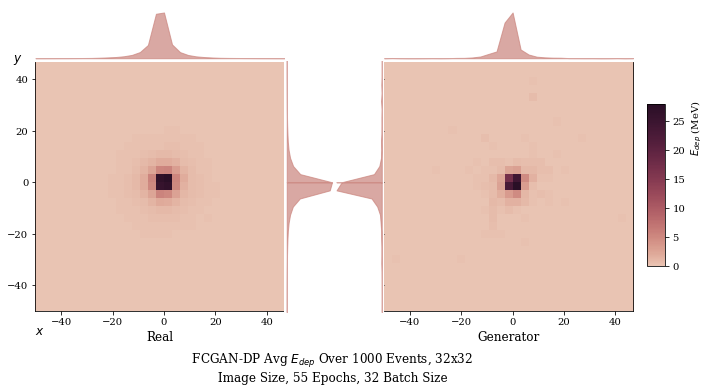

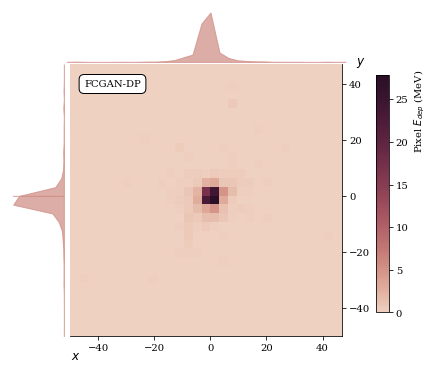

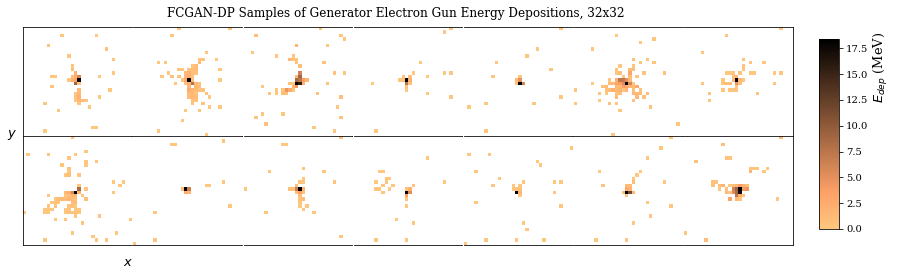

0.15175849 0.19548047989109738


/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/ipykernel_launcher.py:733: RuntimeWarning: invalid value encountered in sqrt



(32,)


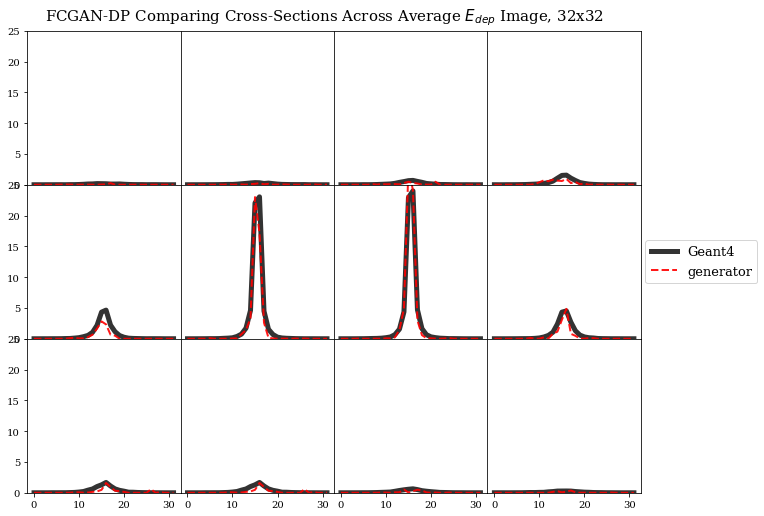

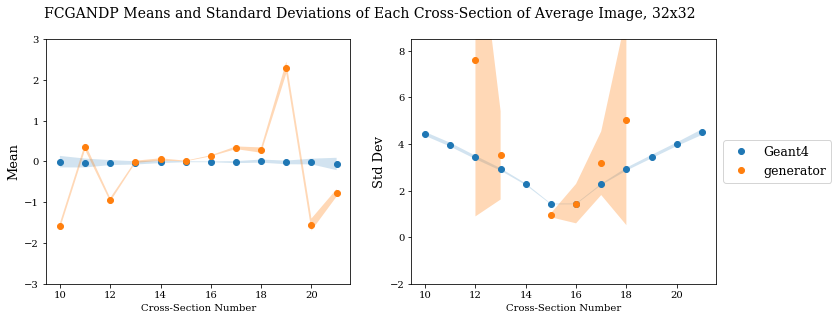

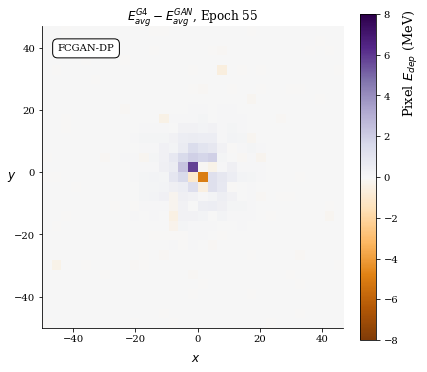

[55/100][0/938] Loss_D: 0.2338 Loss_G: 3.8556 D(x): 0.9255 D(G(z)): 0.1078 / 0.0468
[55/100][100/938] Loss_D: 0.4650 Loss_G: 3.9201 D(x): 0.8703 D(G(z)): 0.0953 / 0.0537
[55/100][200/938] Loss_D: 0.4443 Loss_G: 4.4644 D(x): 0.8902 D(G(z)): 0.1537 / 0.0359
[55/100][300/938] Loss_D: 0.2786 Loss_G: 4.3480 D(x): 0.9337 D(G(z)): 0.1100 / 0.0298
[55/100][400/938] Loss_D: 0.1362 Loss_G: 3.8344 D(x): 0.9771 D(G(z)): 0.0930 / 0.0432
[55/100][500/938] Loss_D: 0.2056 Loss_G: 4.1129 D(x): 0.9278 D(G(z)): 0.0785 / 0.0379
[55/100][600/938] Loss_D: 0.2562 Loss_G: 4.5274 D(x): 0.9428 D(G(z)): 0.1469 / 0.0336
[55/100][700/938] Loss_D: 0.4767 Loss_G: 3.5027 D(x): 0.9396 D(G(z)): 0.2147 / 0.0758
[55/100][800/938] Loss_D: 0.6657 Loss_G: 3.6707 D(x): 0.9184 D(G(z)): 0.2037 / 0.0579
[55/100][900/938] Loss_D: 0.3428 Loss_G: 4.3442 D(x): 0.9058 D(G(z)): 0.1419 / 0.0249
(32, 32)


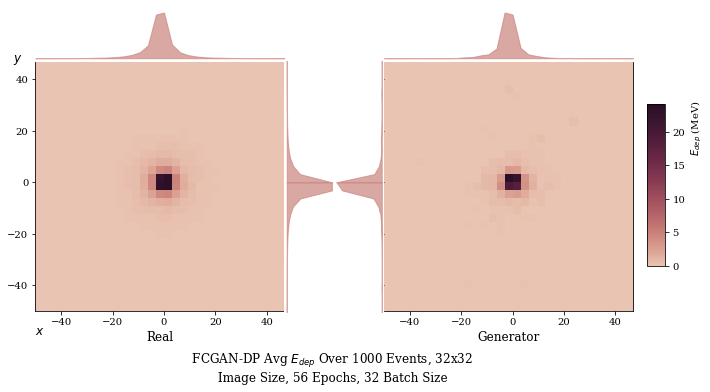

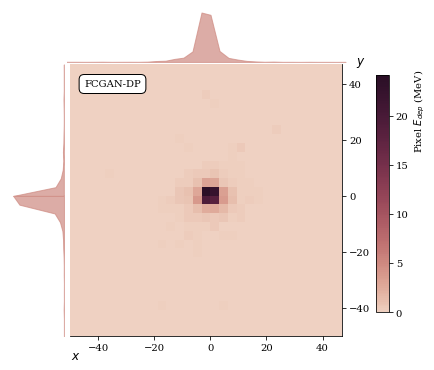

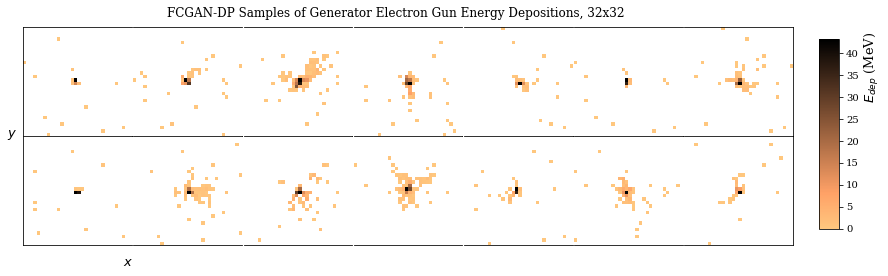

0.13981986 0.19822321175781782
(32,)


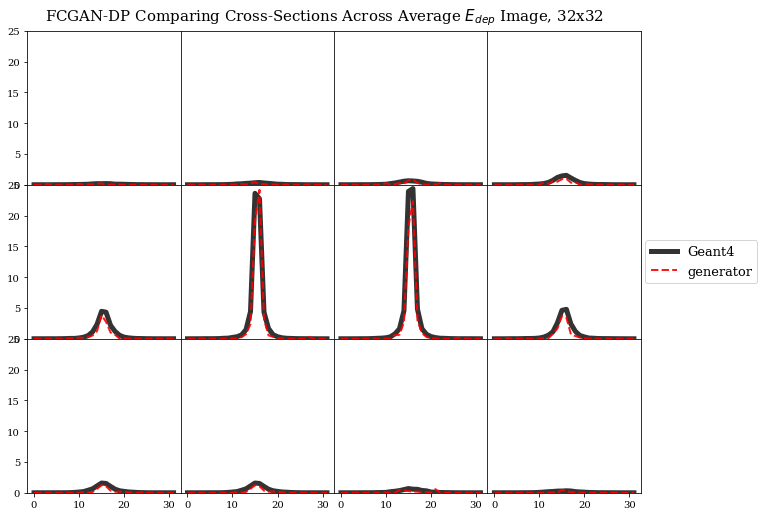

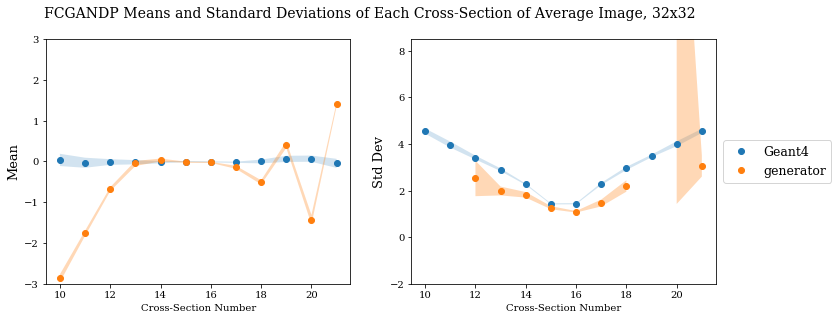

[56/100][0/938] Loss_D: 0.3904 Loss_G: 4.3928 D(x): 0.8964 D(G(z)): 0.1396 / 0.0444
[56/100][100/938] Loss_D: 0.3237 Loss_G: 4.1624 D(x): 0.8540 D(G(z)): 0.0802 / 0.0398
[56/100][200/938] Loss_D: 0.4278 Loss_G: 4.1247 D(x): 0.9265 D(G(z)): 0.1653 / 0.0502
[56/100][300/938] Loss_D: 0.5890 Loss_G: 4.6777 D(x): 0.8874 D(G(z)): 0.1661 / 0.0249
[56/100][400/938] Loss_D: 0.2681 Loss_G: 3.9226 D(x): 0.9114 D(G(z)): 0.0991 / 0.0485
[56/100][500/938] Loss_D: 0.3786 Loss_G: 5.3559 D(x): 0.8835 D(G(z)): 0.0922 / 0.0193
[56/100][600/938] Loss_D: 0.3875 Loss_G: 4.7430 D(x): 0.8622 D(G(z)): 0.0752 / 0.0351
[56/100][700/938] Loss_D: 0.3038 Loss_G: 4.8892 D(x): 0.9236 D(G(z)): 0.1273 / 0.0296
[56/100][800/938] Loss_D: 0.2155 Loss_G: 4.3112 D(x): 0.9370 D(G(z)): 0.1099 / 0.0433
[56/100][900/938] Loss_D: 0.6737 Loss_G: 4.4165 D(x): 0.8353 D(G(z)): 0.1803 / 0.0600
(32, 32)


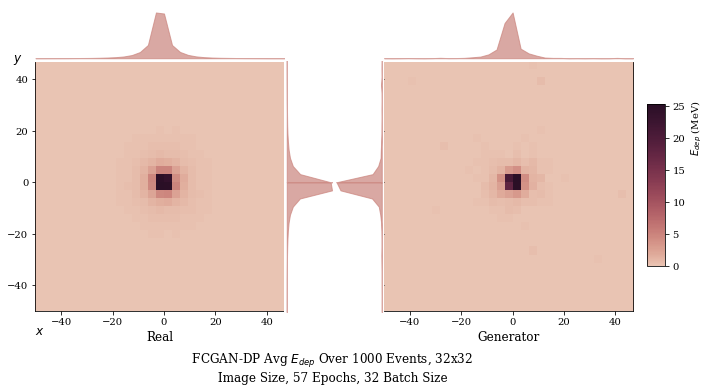

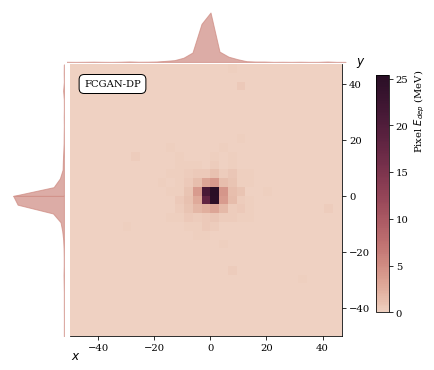

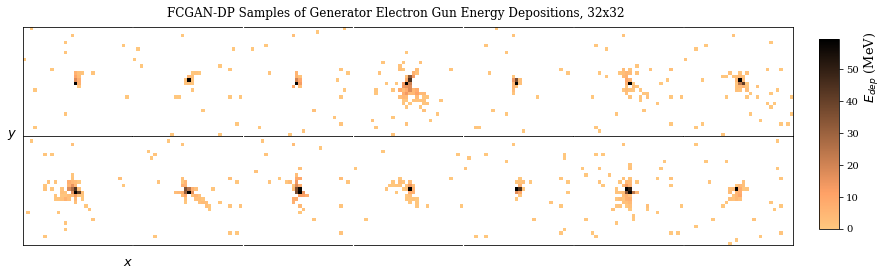

0.1519284 0.19805015087006467
(32,)


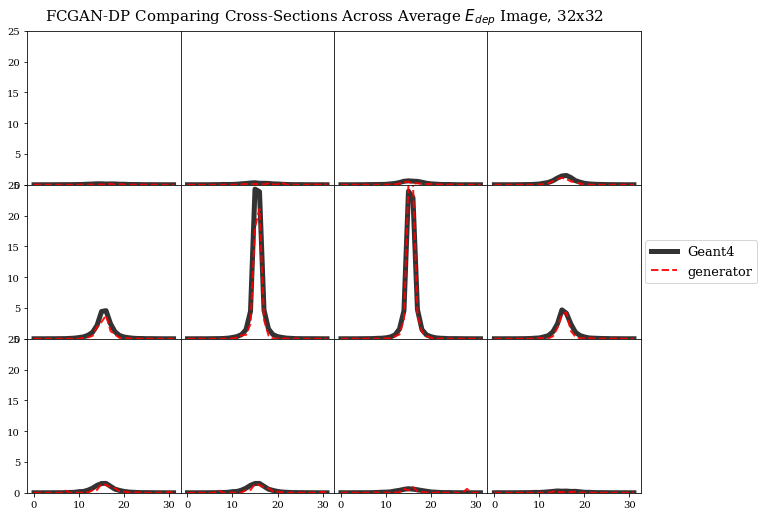

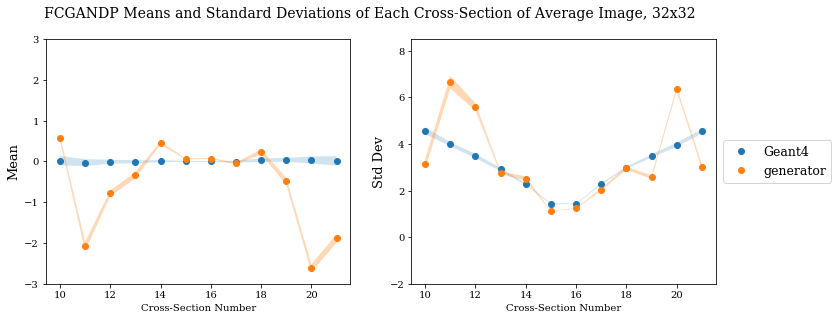

[57/100][0/938] Loss_D: 0.6280 Loss_G: 4.8180 D(x): 0.8705 D(G(z)): 0.1206 / 0.0329
[57/100][100/938] Loss_D: 0.2267 Loss_G: 4.4155 D(x): 0.8856 D(G(z)): 0.0572 / 0.0433
[57/100][200/938] Loss_D: 0.1688 Loss_G: 5.0467 D(x): 0.9381 D(G(z)): 0.0697 / 0.0259
[57/100][300/938] Loss_D: 0.1986 Loss_G: 4.9943 D(x): 0.9099 D(G(z)): 0.0650 / 0.0321
[57/100][400/938] Loss_D: 0.2412 Loss_G: 4.1105 D(x): 0.9145 D(G(z)): 0.1086 / 0.0511
[57/100][500/938] Loss_D: 0.2096 Loss_G: 5.0528 D(x): 0.9312 D(G(z)): 0.0604 / 0.0218
[57/100][600/938] Loss_D: 0.2345 Loss_G: 4.3622 D(x): 0.8990 D(G(z)): 0.0780 / 0.0419
[57/100][700/938] Loss_D: 0.2149 Loss_G: 4.2933 D(x): 0.9348 D(G(z)): 0.1018 / 0.0409
[57/100][800/938] Loss_D: 0.4600 Loss_G: 3.6314 D(x): 0.8359 D(G(z)): 0.0952 / 0.0546
[57/100][900/938] Loss_D: 0.2706 Loss_G: 4.0046 D(x): 0.9026 D(G(z)): 0.1284 / 0.0452
(32, 32)


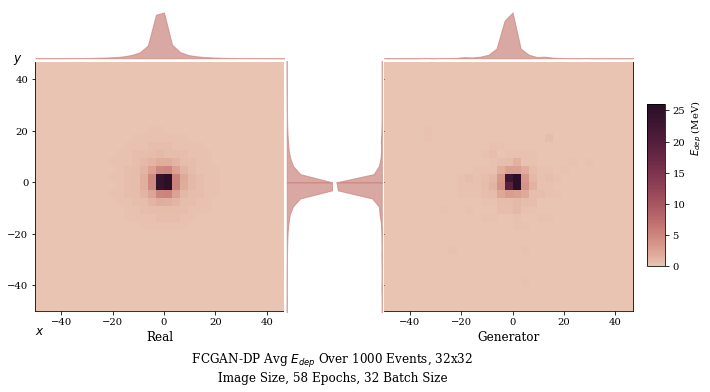

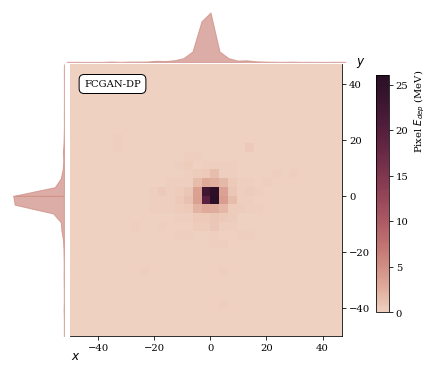

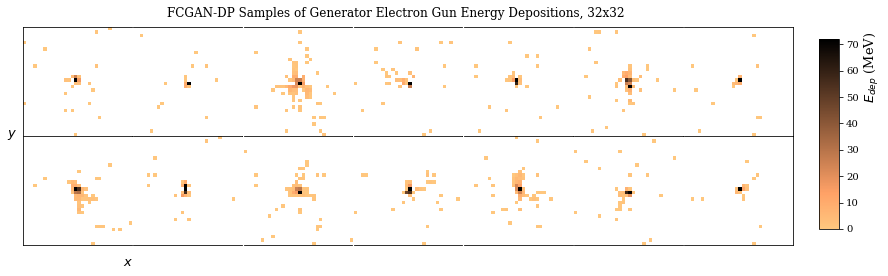

0.15385851 0.19823190724452266
(32,)


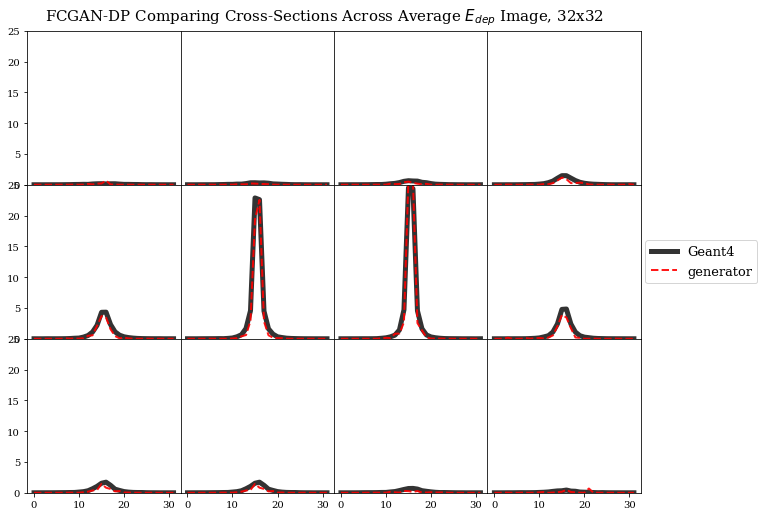

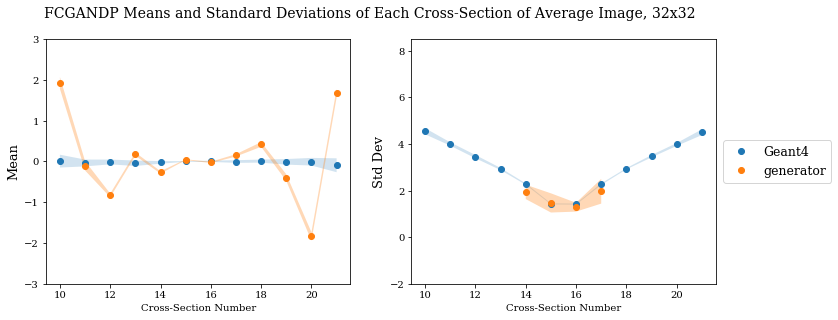

[58/100][0/938] Loss_D: 0.3546 Loss_G: 4.8495 D(x): 0.9651 D(G(z)): 0.1455 / 0.0216
[58/100][100/938] Loss_D: 0.4775 Loss_G: 3.4619 D(x): 0.8745 D(G(z)): 0.1567 / 0.0746
[58/100][200/938] Loss_D: 0.3694 Loss_G: 5.4485 D(x): 0.9388 D(G(z)): 0.1528 / 0.0199
[58/100][300/938] Loss_D: 0.2943 Loss_G: 4.6625 D(x): 0.8754 D(G(z)): 0.0387 / 0.0350
[58/100][400/938] Loss_D: 0.3715 Loss_G: 5.8835 D(x): 0.9238 D(G(z)): 0.1506 / 0.0168
[58/100][500/938] Loss_D: 0.3237 Loss_G: 5.0035 D(x): 0.8918 D(G(z)): 0.0970 / 0.0366
[58/100][600/938] Loss_D: 0.3474 Loss_G: 5.0414 D(x): 0.8263 D(G(z)): 0.0603 / 0.0391
[58/100][700/938] Loss_D: 0.6819 Loss_G: 3.8042 D(x): 0.8719 D(G(z)): 0.1463 / 0.0564
[58/100][800/938] Loss_D: 0.4466 Loss_G: 4.7415 D(x): 0.8628 D(G(z)): 0.1091 / 0.0431
[58/100][900/938] Loss_D: 0.4244 Loss_G: 5.1027 D(x): 0.8287 D(G(z)): 0.0952 / 0.0299
(32, 32)


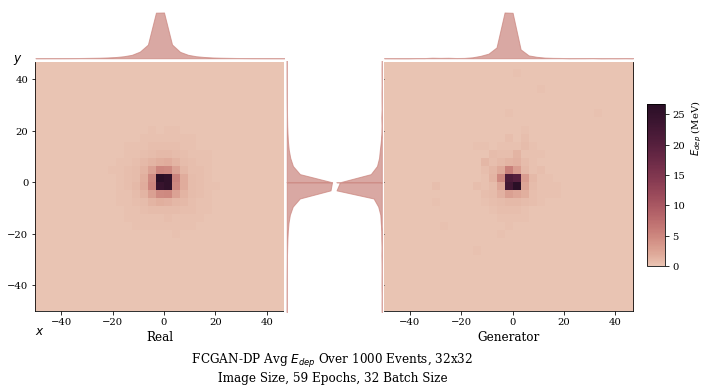

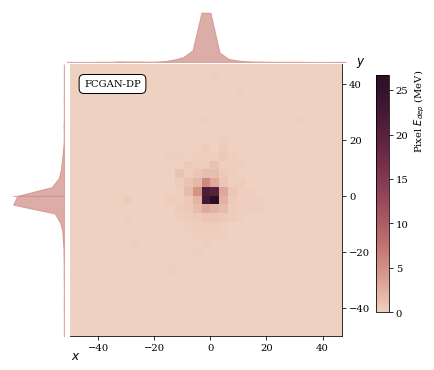

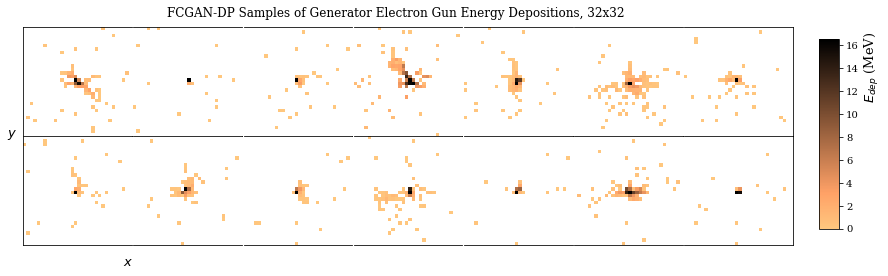

0.1543926 0.19454875315750791
(32,)


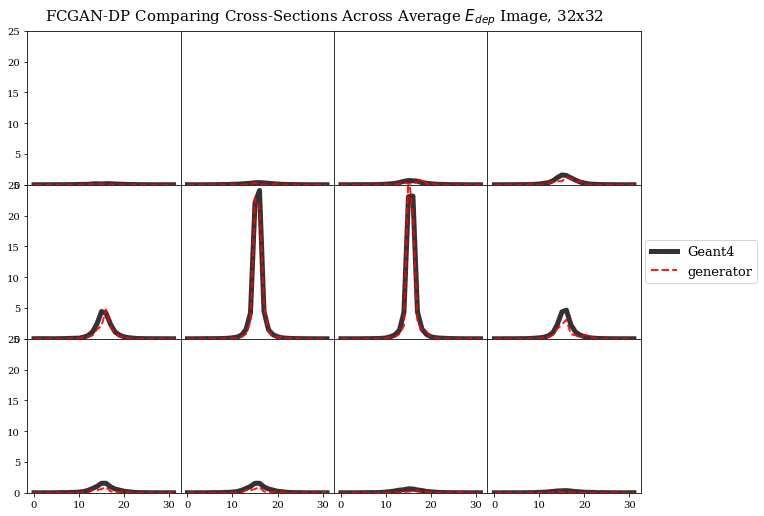

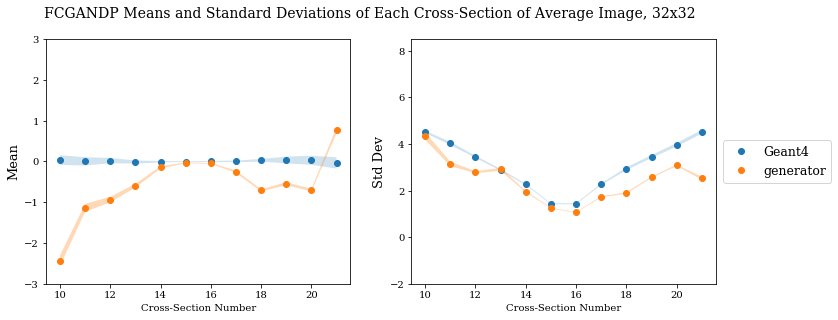

[59/100][0/938] Loss_D: 0.1470 Loss_G: 5.6218 D(x): 0.9258 D(G(z)): 0.0477 / 0.0107
[59/100][100/938] Loss_D: 0.6790 Loss_G: 4.2414 D(x): 0.9056 D(G(z)): 0.2363 / 0.0361
[59/100][200/938] Loss_D: 0.2557 Loss_G: 5.1277 D(x): 0.9005 D(G(z)): 0.0916 / 0.0177
[59/100][300/938] Loss_D: 0.2952 Loss_G: 4.0764 D(x): 0.9004 D(G(z)): 0.0925 / 0.0364
[59/100][400/938] Loss_D: 0.1612 Loss_G: 5.9690 D(x): 0.9459 D(G(z)): 0.0551 / 0.0092
[59/100][500/938] Loss_D: 0.5001 Loss_G: 4.6440 D(x): 0.9447 D(G(z)): 0.1946 / 0.0586
[59/100][600/938] Loss_D: 0.4414 Loss_G: 4.9147 D(x): 0.9014 D(G(z)): 0.0972 / 0.0306
[59/100][700/938] Loss_D: 0.3402 Loss_G: 4.5993 D(x): 0.9253 D(G(z)): 0.1499 / 0.0288
[59/100][800/938] Loss_D: 0.2669 Loss_G: 4.2188 D(x): 0.8917 D(G(z)): 0.0932 / 0.0340
[59/100][900/938] Loss_D: 0.3759 Loss_G: 4.6050 D(x): 0.8893 D(G(z)): 0.1263 / 0.0302
(32, 32)


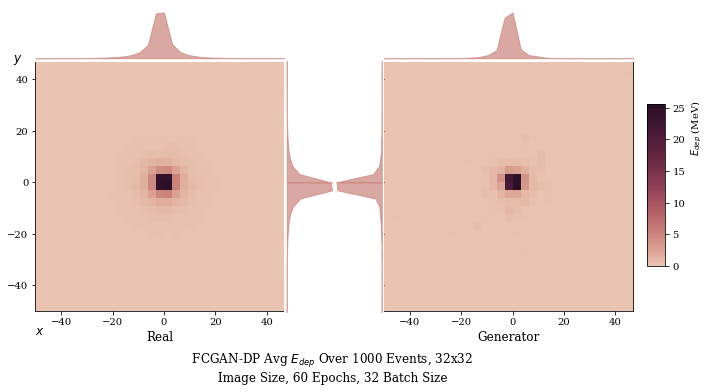

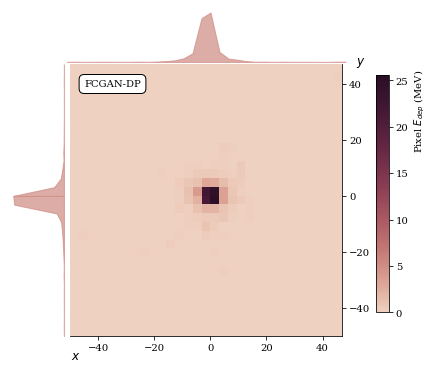

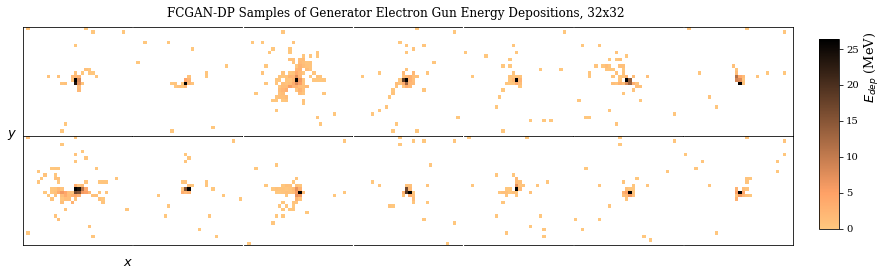

0.14473552 0.1946982068196591
(32,)


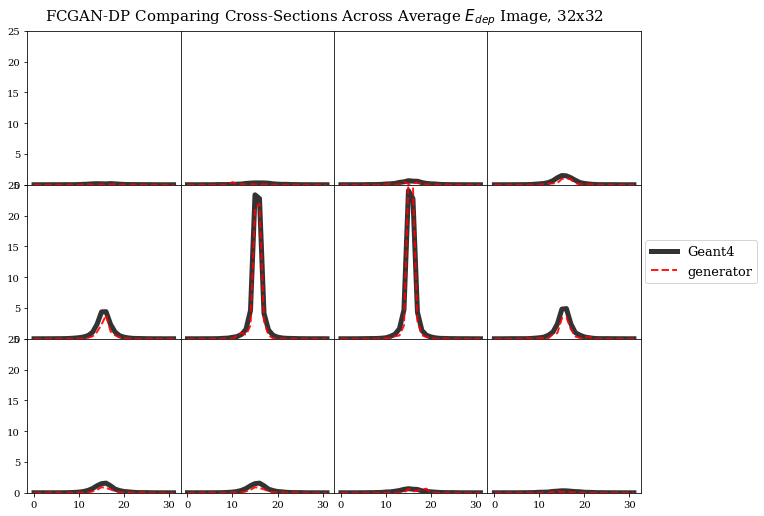

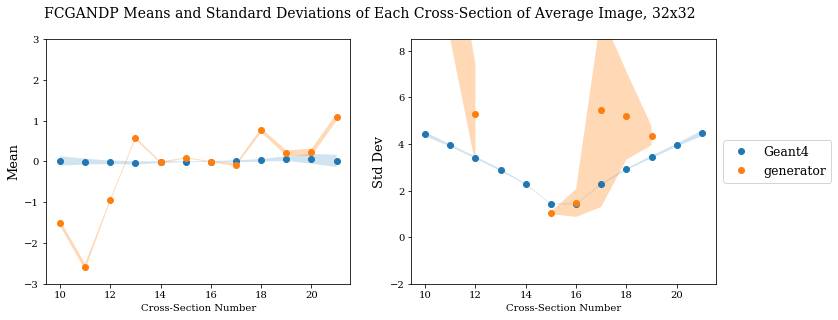

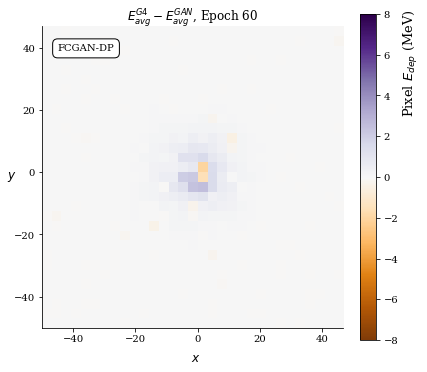

[60/100][0/938] Loss_D: 0.3021 Loss_G: 4.6773 D(x): 0.9656 D(G(z)): 0.0886 / 0.0250
[60/100][100/938] Loss_D: 0.2829 Loss_G: 4.4091 D(x): 0.8998 D(G(z)): 0.0985 / 0.0293
[60/100][200/938] Loss_D: 0.1947 Loss_G: 4.2254 D(x): 0.9235 D(G(z)): 0.0758 / 0.0350
[60/100][300/938] Loss_D: 0.4668 Loss_G: 4.5688 D(x): 0.8410 D(G(z)): 0.0791 / 0.0284
[60/100][400/938] Loss_D: 0.1470 Loss_G: 4.0277 D(x): 0.9791 D(G(z)): 0.0987 / 0.0463
[60/100][500/938] Loss_D: 0.6018 Loss_G: 3.9461 D(x): 0.9481 D(G(z)): 0.2765 / 0.0702
[60/100][600/938] Loss_D: 0.2319 Loss_G: 4.8777 D(x): 0.8586 D(G(z)): 0.0353 / 0.0362
[60/100][700/938] Loss_D: 0.4007 Loss_G: 5.0212 D(x): 0.9349 D(G(z)): 0.1567 / 0.0145
[60/100][800/938] Loss_D: 0.3173 Loss_G: 4.9386 D(x): 0.9175 D(G(z)): 0.1290 / 0.0368
[60/100][900/938] Loss_D: 0.3049 Loss_G: 3.9304 D(x): 0.8595 D(G(z)): 0.0342 / 0.0396
(32, 32)


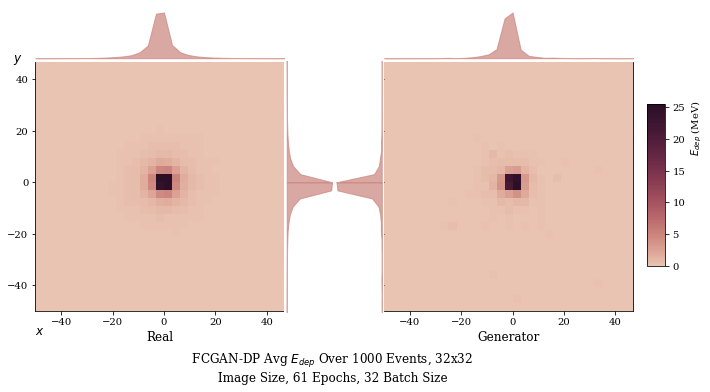

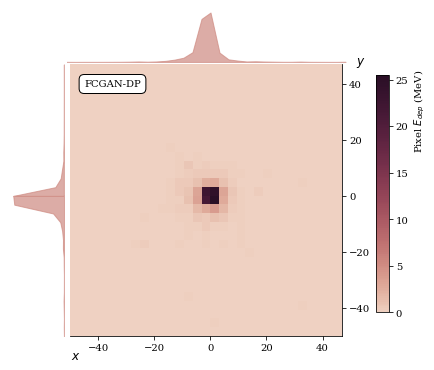

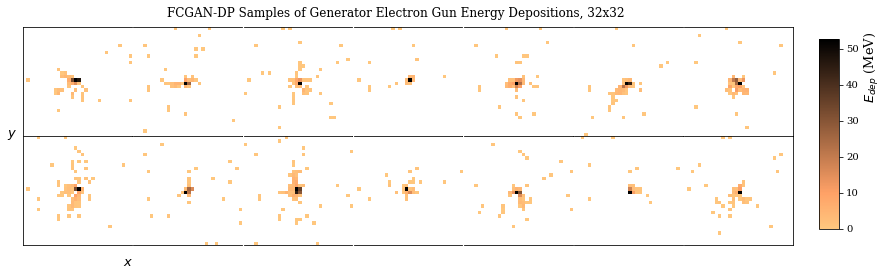

0.14931986 0.19597691194362848
(32,)


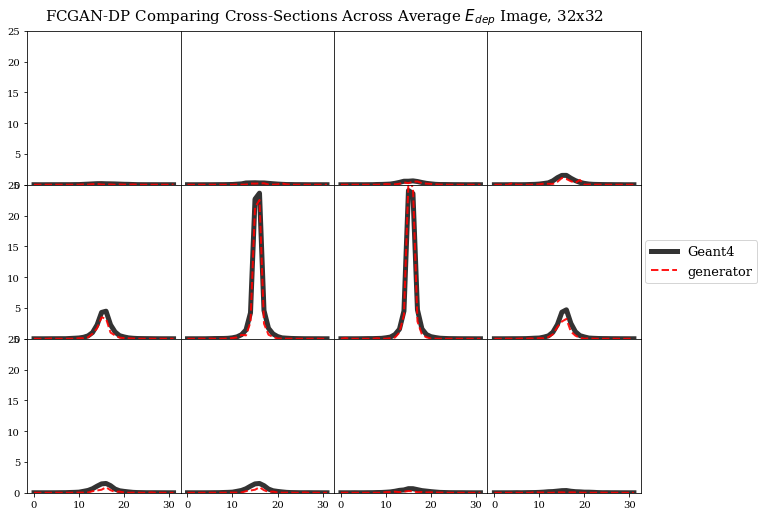

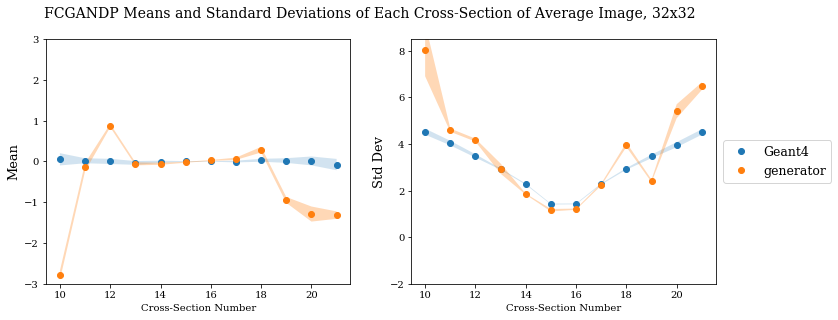

[61/100][0/938] Loss_D: 0.3015 Loss_G: 5.3555 D(x): 0.8744 D(G(z)): 0.0228 / 0.0132
[61/100][100/938] Loss_D: 0.4928 Loss_G: 4.4058 D(x): 0.8376 D(G(z)): 0.1502 / 0.0308
[61/100][200/938] Loss_D: 0.2968 Loss_G: 5.3662 D(x): 0.8822 D(G(z)): 0.0283 / 0.0210
[61/100][300/938] Loss_D: 0.7040 Loss_G: 5.0073 D(x): 0.8946 D(G(z)): 0.1595 / 0.0669
[61/100][400/938] Loss_D: 0.2328 Loss_G: 5.0076 D(x): 0.9389 D(G(z)): 0.0849 / 0.0197
[61/100][500/938] Loss_D: 0.1860 Loss_G: 4.5506 D(x): 0.9194 D(G(z)): 0.0470 / 0.0264
[61/100][600/938] Loss_D: 0.2406 Loss_G: 4.6237 D(x): 0.8954 D(G(z)): 0.0557 / 0.0342
[61/100][700/938] Loss_D: 0.1856 Loss_G: 5.6973 D(x): 0.9583 D(G(z)): 0.0880 / 0.0318
[61/100][800/938] Loss_D: 0.4184 Loss_G: 4.1521 D(x): 0.8412 D(G(z)): 0.0739 / 0.0394
[61/100][900/938] Loss_D: 0.4072 Loss_G: 4.4372 D(x): 0.8497 D(G(z)): 0.1271 / 0.0493
(32, 32)


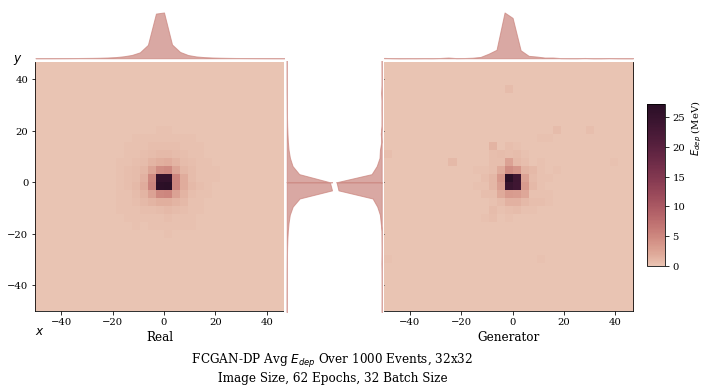

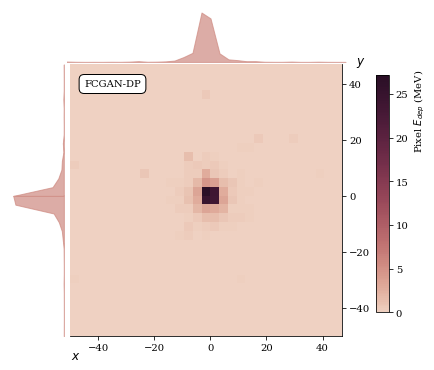

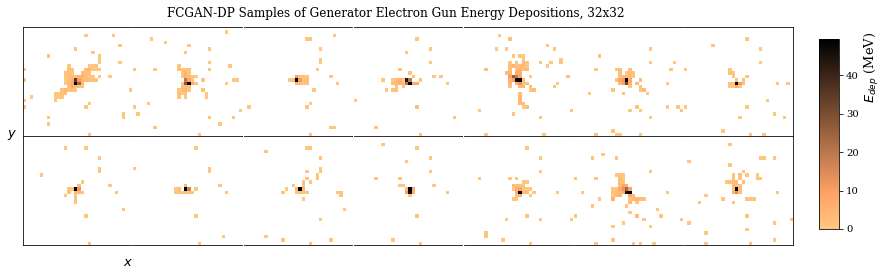

0.16567701 0.19762588627004463
(32,)


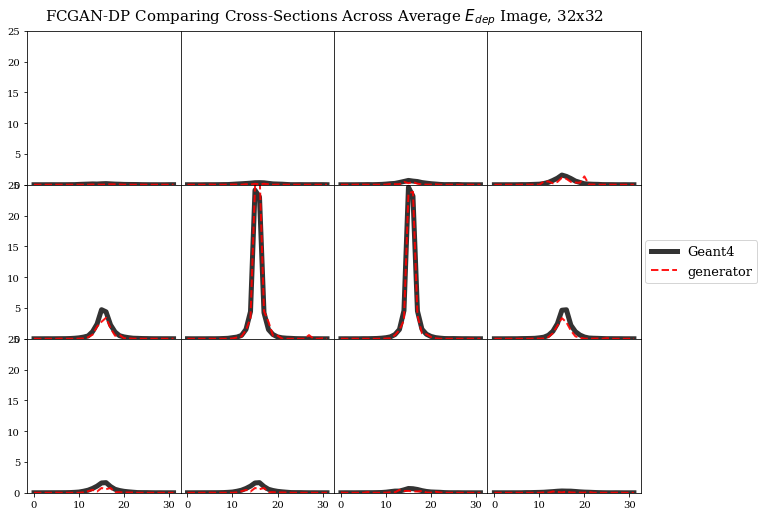

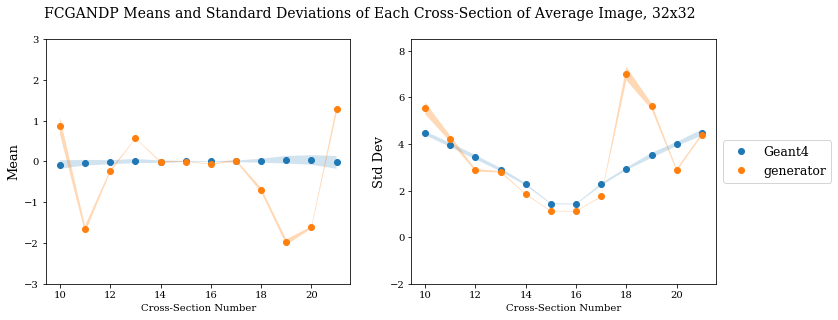

[62/100][0/938] Loss_D: 0.1411 Loss_G: 6.3524 D(x): 0.9331 D(G(z)): 0.0260 / 0.0112
[62/100][100/938] Loss_D: 0.2604 Loss_G: 5.2705 D(x): 0.9045 D(G(z)): 0.0984 / 0.0316
[62/100][200/938] Loss_D: 0.3044 Loss_G: 4.3845 D(x): 0.9493 D(G(z)): 0.1480 / 0.0371
[62/100][300/938] Loss_D: 0.4044 Loss_G: 4.9384 D(x): 0.8494 D(G(z)): 0.0720 / 0.0431
[62/100][400/938] Loss_D: 0.5175 Loss_G: 5.4145 D(x): 0.8694 D(G(z)): 0.1179 / 0.0281
[62/100][500/938] Loss_D: 0.2523 Loss_G: 6.0779 D(x): 0.8986 D(G(z)): 0.0418 / 0.0136
[62/100][600/938] Loss_D: 0.3058 Loss_G: 4.5921 D(x): 0.8587 D(G(z)): 0.0491 / 0.0310
[62/100][700/938] Loss_D: 0.3457 Loss_G: 4.5073 D(x): 0.9584 D(G(z)): 0.1758 / 0.0342
[62/100][800/938] Loss_D: 0.2920 Loss_G: 4.7306 D(x): 0.8924 D(G(z)): 0.1113 / 0.0393
[62/100][900/938] Loss_D: 0.2812 Loss_G: 4.8672 D(x): 0.8574 D(G(z)): 0.0676 / 0.0311
(32, 32)


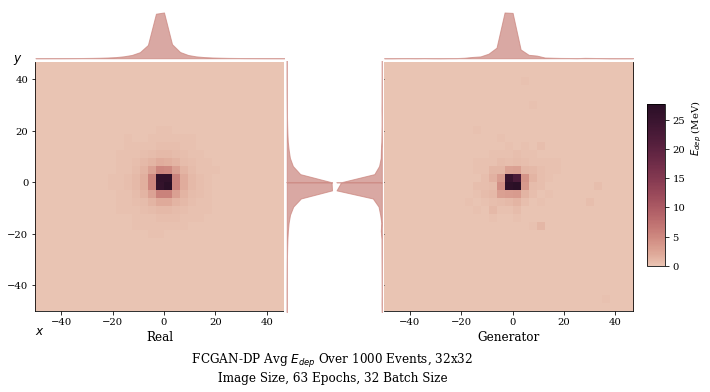

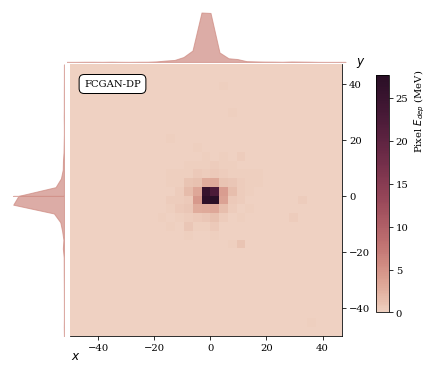

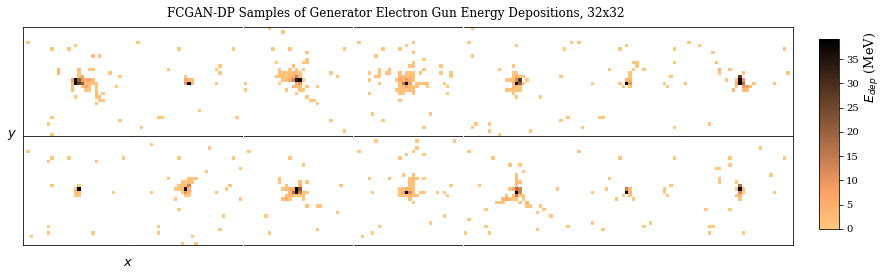

0.16532513 0.20102786527766725
(32,)


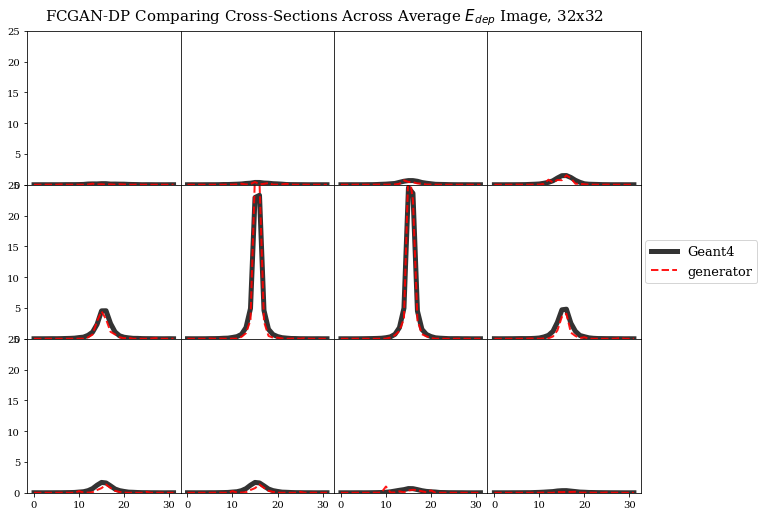

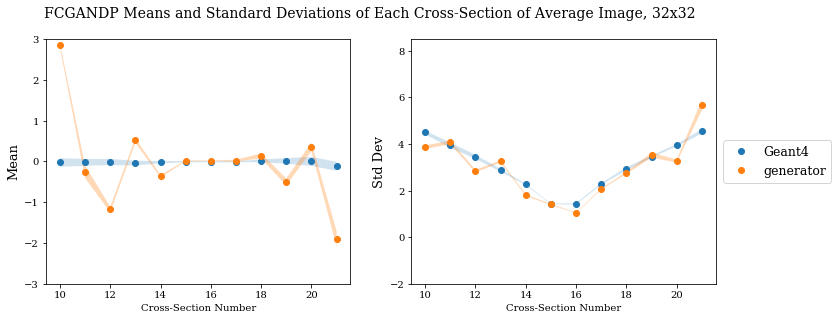

[63/100][0/938] Loss_D: 0.2853 Loss_G: 5.3437 D(x): 0.9593 D(G(z)): 0.1212 / 0.0202
[63/100][100/938] Loss_D: 0.5793 Loss_G: 4.9459 D(x): 0.8024 D(G(z)): 0.0965 / 0.0427
[63/100][200/938] Loss_D: 0.1930 Loss_G: 4.6986 D(x): 0.8958 D(G(z)): 0.0442 / 0.0245
[63/100][300/938] Loss_D: 0.4143 Loss_G: 4.8930 D(x): 0.9186 D(G(z)): 0.1034 / 0.0416
[63/100][400/938] Loss_D: 0.1953 Loss_G: 4.2242 D(x): 0.9742 D(G(z)): 0.1191 / 0.0410
[63/100][500/938] Loss_D: 0.2199 Loss_G: 4.6558 D(x): 0.9158 D(G(z)): 0.0714 / 0.0335
[63/100][600/938] Loss_D: 0.2927 Loss_G: 4.3059 D(x): 0.9185 D(G(z)): 0.1485 / 0.0292
[63/100][700/938] Loss_D: 0.3007 Loss_G: 4.9859 D(x): 0.9572 D(G(z)): 0.1468 / 0.0235
[63/100][800/938] Loss_D: 0.5611 Loss_G: 3.6993 D(x): 0.8690 D(G(z)): 0.2070 / 0.0616
[63/100][900/938] Loss_D: 0.3820 Loss_G: 4.2911 D(x): 0.8451 D(G(z)): 0.0704 / 0.0446
(32, 32)


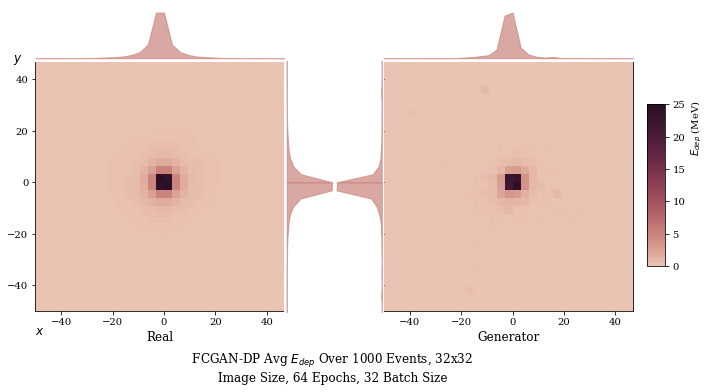

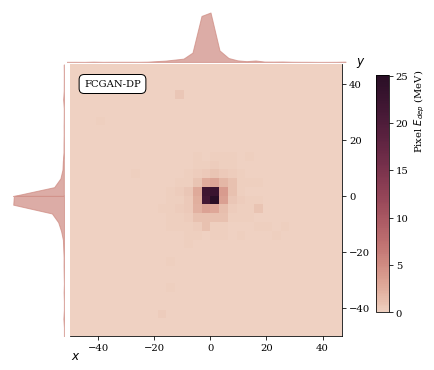

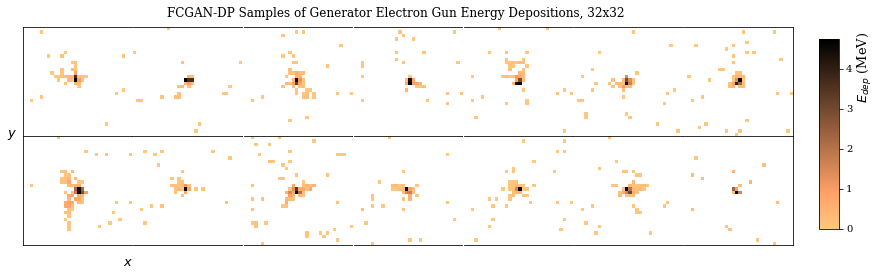

0.15117472 0.19661566749395967
(32,)


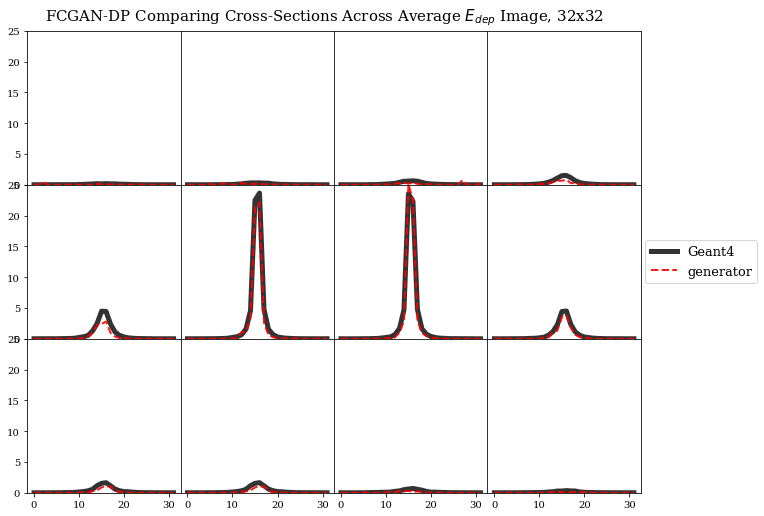

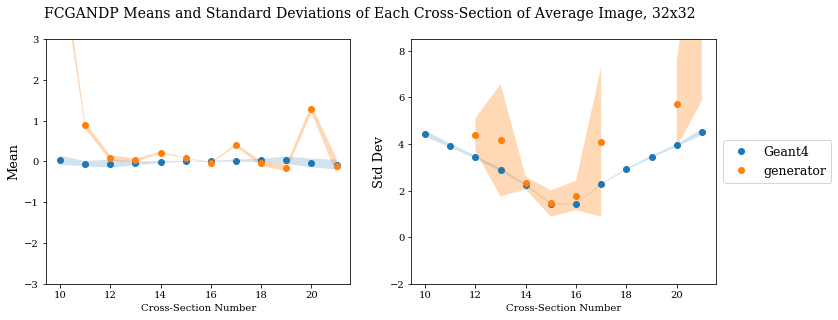

[64/100][0/938] Loss_D: 0.3933 Loss_G: 5.0429 D(x): 0.9585 D(G(z)): 0.1669 / 0.0189
[64/100][100/938] Loss_D: 0.3705 Loss_G: 4.7498 D(x): 0.9067 D(G(z)): 0.1280 / 0.0274
[64/100][200/938] Loss_D: 0.4064 Loss_G: 5.5692 D(x): 0.9702 D(G(z)): 0.2064 / 0.0156
[64/100][300/938] Loss_D: 0.3364 Loss_G: 4.7772 D(x): 0.9053 D(G(z)): 0.1068 / 0.0370
[64/100][400/938] Loss_D: 0.2191 Loss_G: 4.5834 D(x): 0.9106 D(G(z)): 0.0384 / 0.0290
[64/100][500/938] Loss_D: 0.2589 Loss_G: 4.4563 D(x): 0.8869 D(G(z)): 0.0541 / 0.0346
[64/100][600/938] Loss_D: 0.2859 Loss_G: 6.2241 D(x): 0.9113 D(G(z)): 0.0824 / 0.0137
[64/100][700/938] Loss_D: 0.2385 Loss_G: 4.4377 D(x): 0.9327 D(G(z)): 0.1003 / 0.0437
[64/100][800/938] Loss_D: 0.1184 Loss_G: 4.9328 D(x): 0.9294 D(G(z)): 0.0247 / 0.0223
[64/100][900/938] Loss_D: 0.2937 Loss_G: 5.3431 D(x): 0.9130 D(G(z)): 0.1038 / 0.0222
(32, 32)


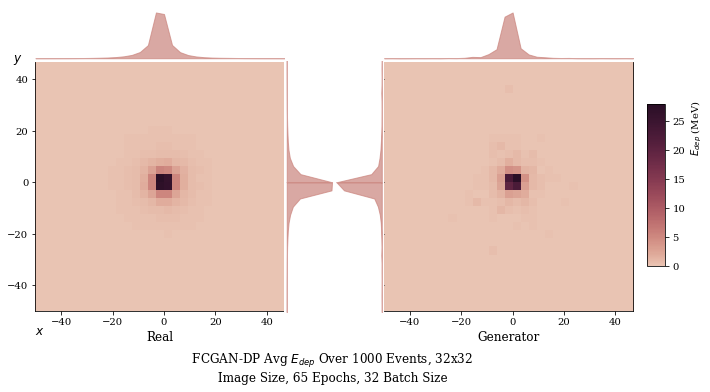

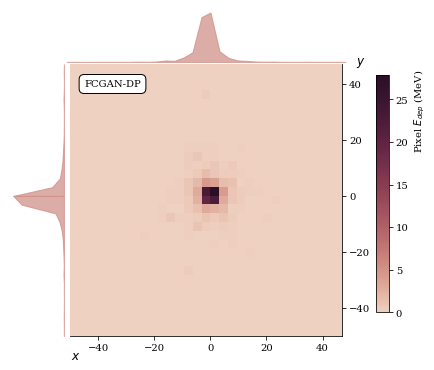

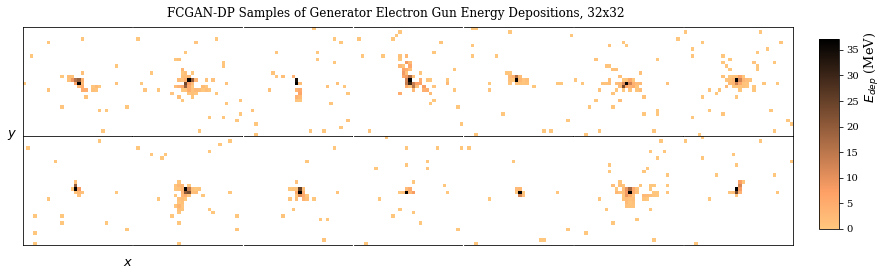

0.15758884 0.1983439270842395
(32,)


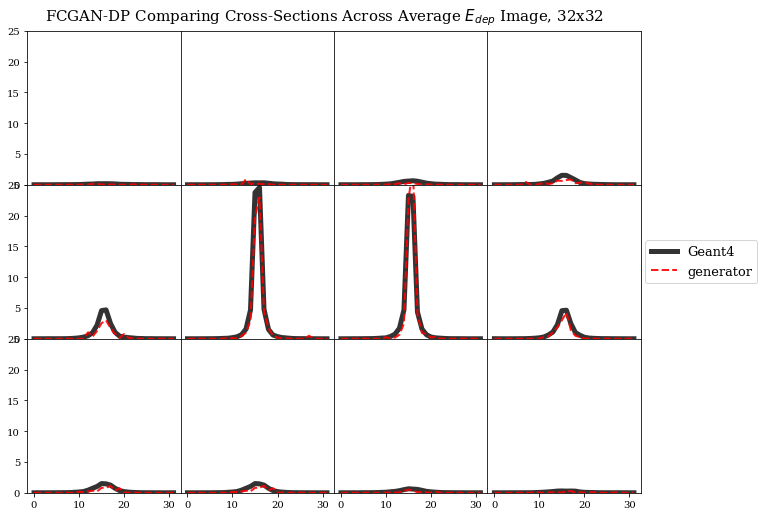

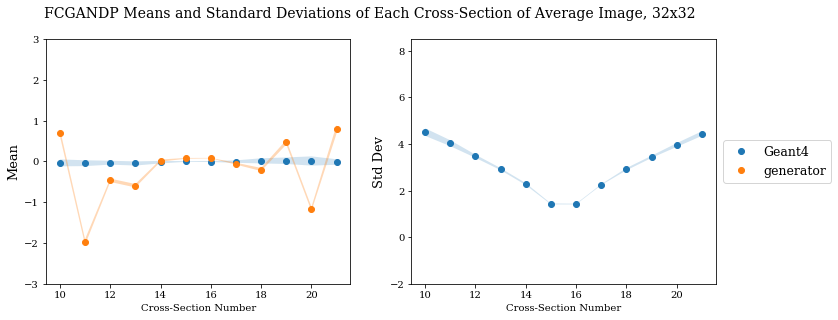

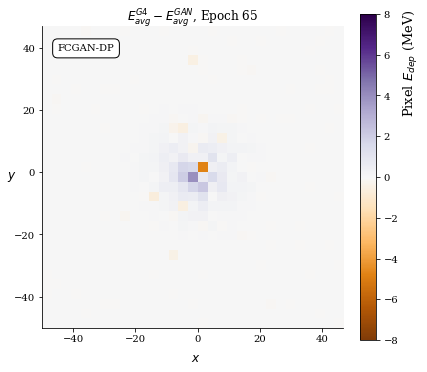

[65/100][0/938] Loss_D: 0.3597 Loss_G: 6.6315 D(x): 0.9150 D(G(z)): 0.1129 / 0.0340
[65/100][100/938] Loss_D: 0.3649 Loss_G: 5.1543 D(x): 0.8643 D(G(z)): 0.1104 / 0.0288
[65/100][200/938] Loss_D: 0.2827 Loss_G: 4.9203 D(x): 0.9564 D(G(z)): 0.1545 / 0.0189
[65/100][300/938] Loss_D: 0.5893 Loss_G: 5.0665 D(x): 0.8652 D(G(z)): 0.1399 / 0.0340
[65/100][400/938] Loss_D: 0.1648 Loss_G: 5.1542 D(x): 0.9583 D(G(z)): 0.0645 / 0.0263
[65/100][500/938] Loss_D: 0.1943 Loss_G: 5.5526 D(x): 0.9484 D(G(z)): 0.0809 / 0.0211
[65/100][600/938] Loss_D: 0.2562 Loss_G: 5.1088 D(x): 0.8956 D(G(z)): 0.0642 / 0.0256
[65/100][700/938] Loss_D: 0.1460 Loss_G: 4.6313 D(x): 0.9368 D(G(z)): 0.0508 / 0.0377
[65/100][800/938] Loss_D: 0.5383 Loss_G: 4.4942 D(x): 0.9115 D(G(z)): 0.1780 / 0.0363
[65/100][900/938] Loss_D: 0.4076 Loss_G: 5.2866 D(x): 0.8719 D(G(z)): 0.0788 / 0.0245
(32, 32)


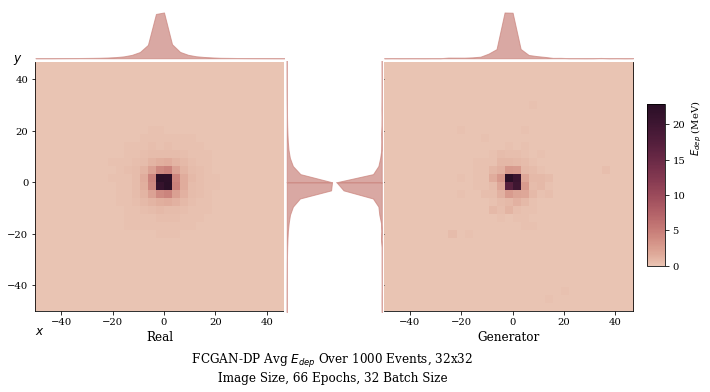

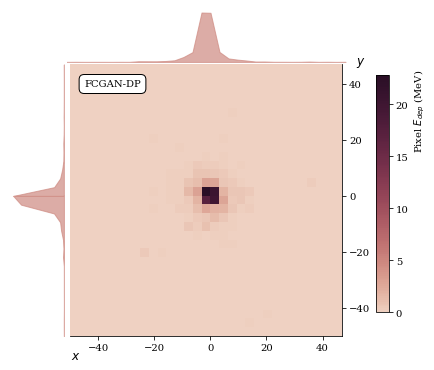

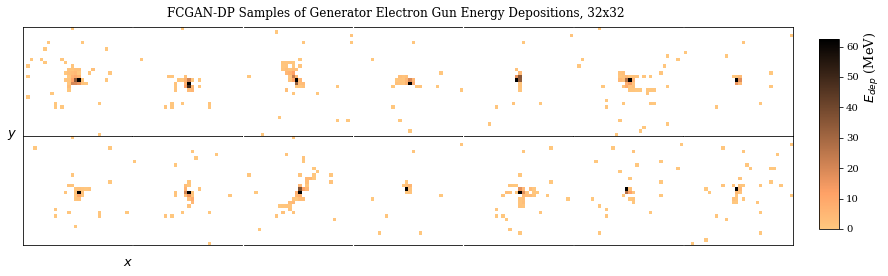

0.13237952 0.1992671938909397
(32,)


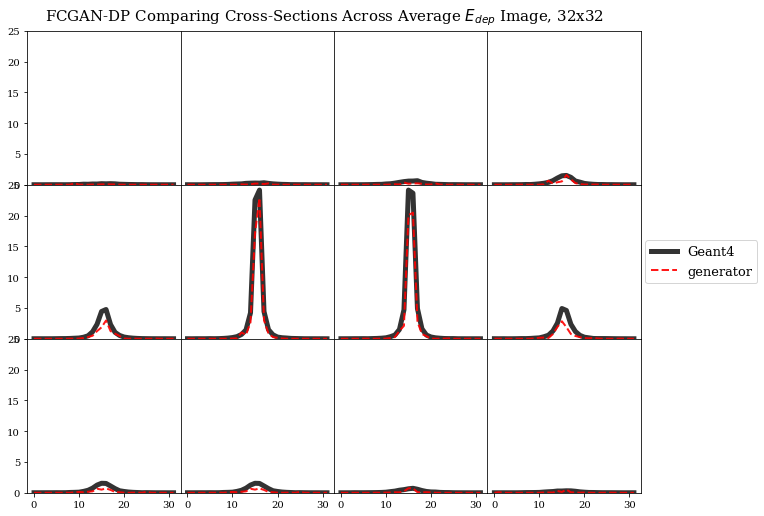

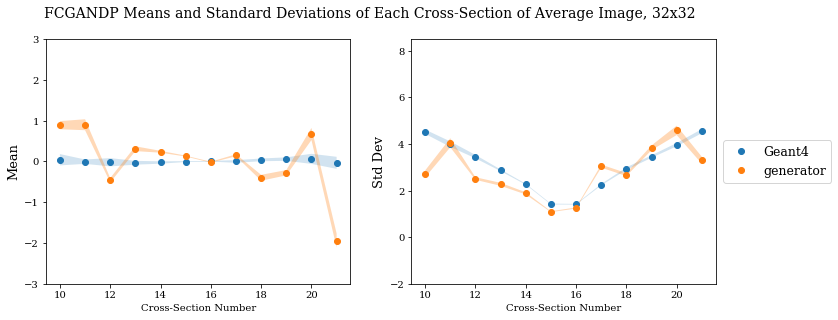

[66/100][0/938] Loss_D: 0.3306 Loss_G: 4.4924 D(x): 0.9476 D(G(z)): 0.1388 / 0.0448
[66/100][100/938] Loss_D: 0.2855 Loss_G: 4.1020 D(x): 0.8787 D(G(z)): 0.0892 / 0.0387
[66/100][200/938] Loss_D: 0.2041 Loss_G: 4.8243 D(x): 0.9864 D(G(z)): 0.1245 / 0.0191
[66/100][300/938] Loss_D: 0.3044 Loss_G: 4.4012 D(x): 0.9008 D(G(z)): 0.1108 / 0.0447
[66/100][400/938] Loss_D: 0.2304 Loss_G: 5.4087 D(x): 0.9444 D(G(z)): 0.0891 / 0.0269
[66/100][500/938] Loss_D: 0.3561 Loss_G: 4.5130 D(x): 0.8753 D(G(z)): 0.0791 / 0.0335
[66/100][600/938] Loss_D: 0.2361 Loss_G: 6.3071 D(x): 0.9422 D(G(z)): 0.0745 / 0.0204
[66/100][700/938] Loss_D: 0.2967 Loss_G: 4.9562 D(x): 0.9277 D(G(z)): 0.1187 / 0.0343
[66/100][800/938] Loss_D: 0.4177 Loss_G: 4.6849 D(x): 0.8488 D(G(z)): 0.1059 / 0.0272
[66/100][900/938] Loss_D: 0.4790 Loss_G: 4.4736 D(x): 0.8849 D(G(z)): 0.1950 / 0.0390
(32, 32)


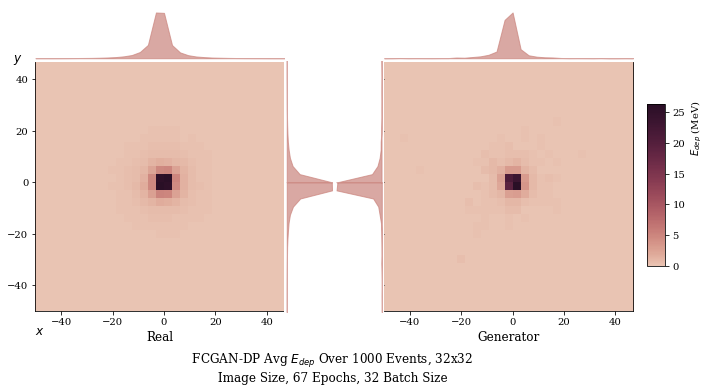

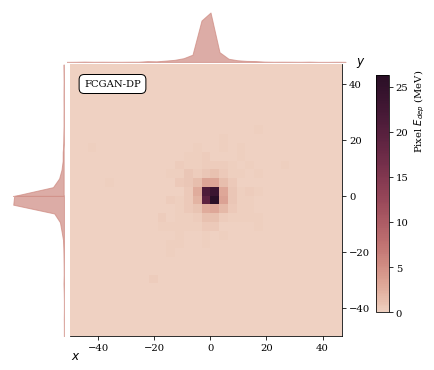

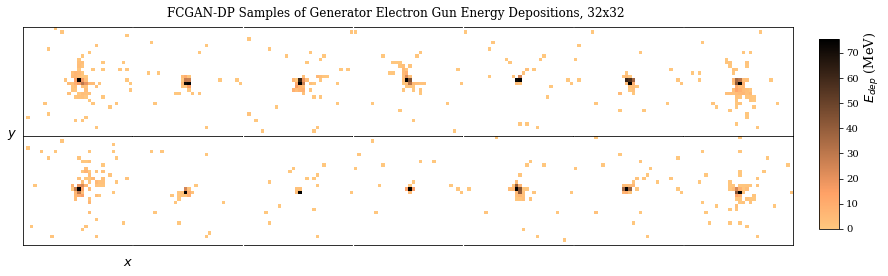

0.14843254 0.1950555846413715
(32,)


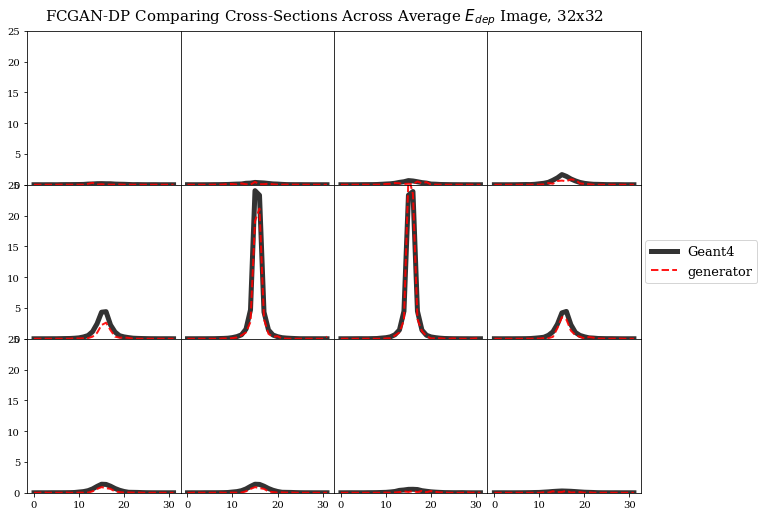

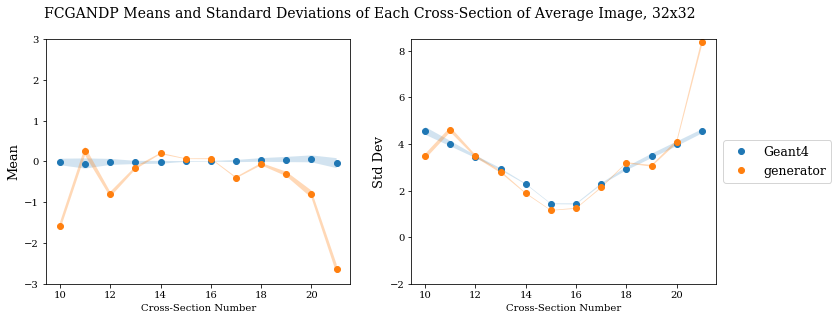

[67/100][0/938] Loss_D: 0.2802 Loss_G: 5.1800 D(x): 0.9142 D(G(z)): 0.1114 / 0.0172
[67/100][100/938] Loss_D: 0.4108 Loss_G: 4.4509 D(x): 0.9167 D(G(z)): 0.1479 / 0.0397
[67/100][200/938] Loss_D: 0.3691 Loss_G: 4.7990 D(x): 0.9799 D(G(z)): 0.1516 / 0.0458
[67/100][300/938] Loss_D: 0.3253 Loss_G: 3.9654 D(x): 0.8973 D(G(z)): 0.0853 / 0.0620
[67/100][400/938] Loss_D: 0.1512 Loss_G: 5.2557 D(x): 0.9583 D(G(z)): 0.0740 / 0.0159
[67/100][500/938] Loss_D: 0.4108 Loss_G: 4.8064 D(x): 0.9114 D(G(z)): 0.1327 / 0.0330
[67/100][600/938] Loss_D: 0.3099 Loss_G: 5.6173 D(x): 0.9353 D(G(z)): 0.1111 / 0.0328
[67/100][700/938] Loss_D: 0.3434 Loss_G: 5.3784 D(x): 0.9067 D(G(z)): 0.1146 / 0.0196
[67/100][800/938] Loss_D: 0.3480 Loss_G: 4.5631 D(x): 0.9281 D(G(z)): 0.1534 / 0.0320
[67/100][900/938] Loss_D: 0.1903 Loss_G: 4.8187 D(x): 0.9114 D(G(z)): 0.0494 / 0.0259
(32, 32)


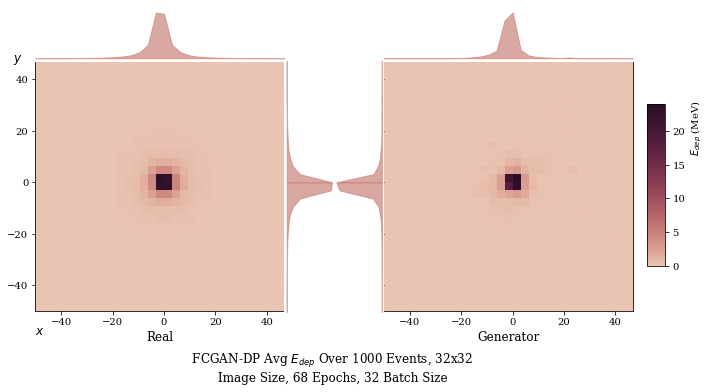

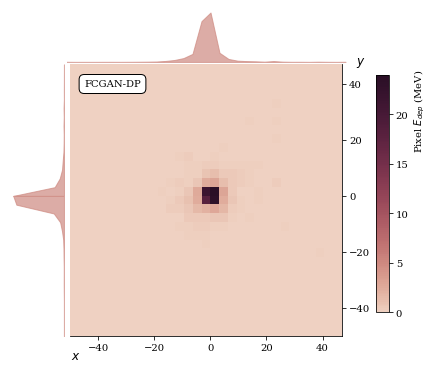

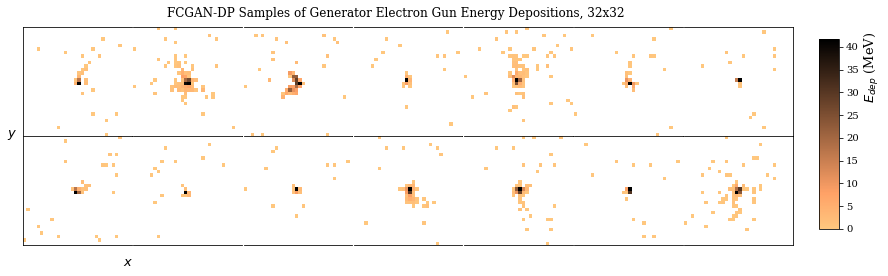

0.13735385 0.1956450053485027
(32,)


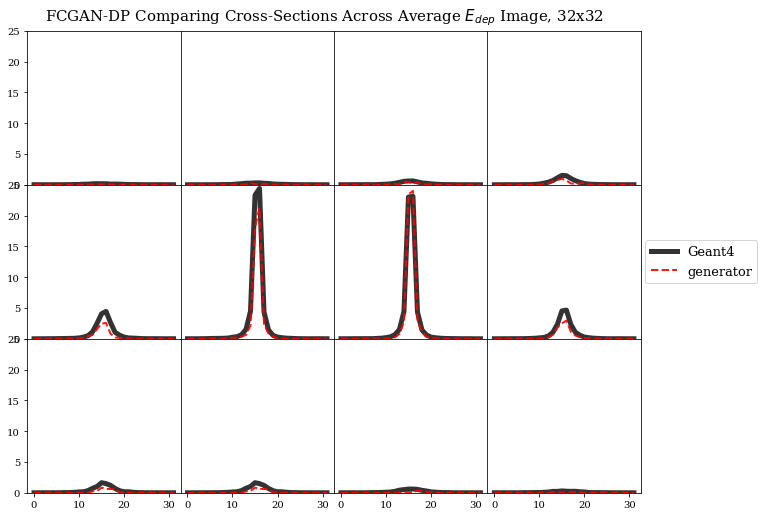

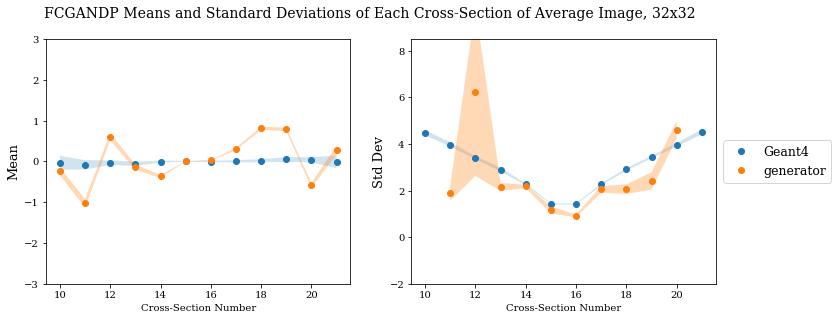

[68/100][0/938] Loss_D: 0.1099 Loss_G: 5.2735 D(x): 0.9834 D(G(z)): 0.0794 / 0.0225
[68/100][100/938] Loss_D: 0.2431 Loss_G: 4.0416 D(x): 0.8926 D(G(z)): 0.0722 / 0.0416
[68/100][200/938] Loss_D: 0.2743 Loss_G: 5.3962 D(x): 0.9268 D(G(z)): 0.0927 / 0.0190
[68/100][300/938] Loss_D: 0.2609 Loss_G: 5.0624 D(x): 0.8860 D(G(z)): 0.0254 / 0.0242
[68/100][400/938] Loss_D: 0.1294 Loss_G: 6.2361 D(x): 0.9565 D(G(z)): 0.0369 / 0.0163
[68/100][500/938] Loss_D: 0.3338 Loss_G: 5.4066 D(x): 0.8778 D(G(z)): 0.0593 / 0.0331
[68/100][600/938] Loss_D: 0.3732 Loss_G: 5.0639 D(x): 0.8788 D(G(z)): 0.1174 / 0.0201
[68/100][700/938] Loss_D: 0.1296 Loss_G: 4.7493 D(x): 0.9791 D(G(z)): 0.0669 / 0.0169
[68/100][800/938] Loss_D: 0.2423 Loss_G: 5.3522 D(x): 0.9166 D(G(z)): 0.0754 / 0.0417
[68/100][900/938] Loss_D: 0.4291 Loss_G: 4.8713 D(x): 0.8561 D(G(z)): 0.0864 / 0.0299
(32, 32)


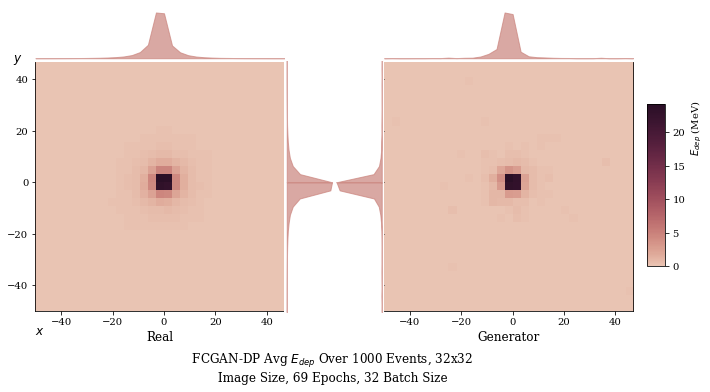

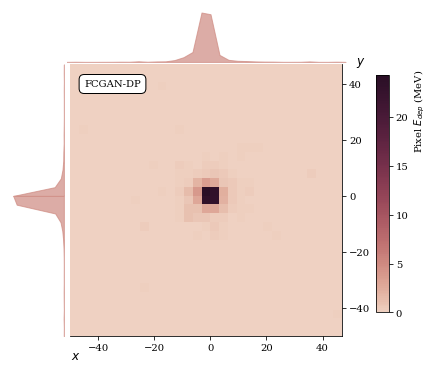

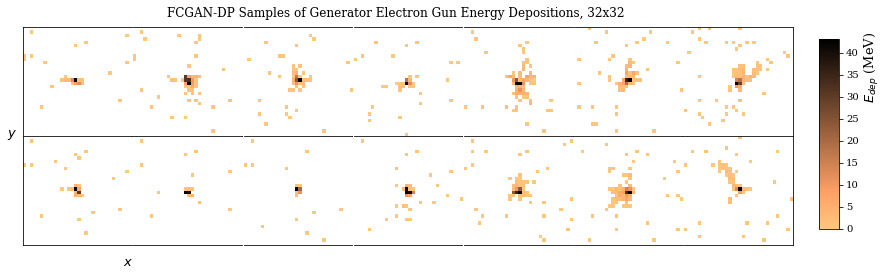

0.14396238 0.20027332145575555
(32,)


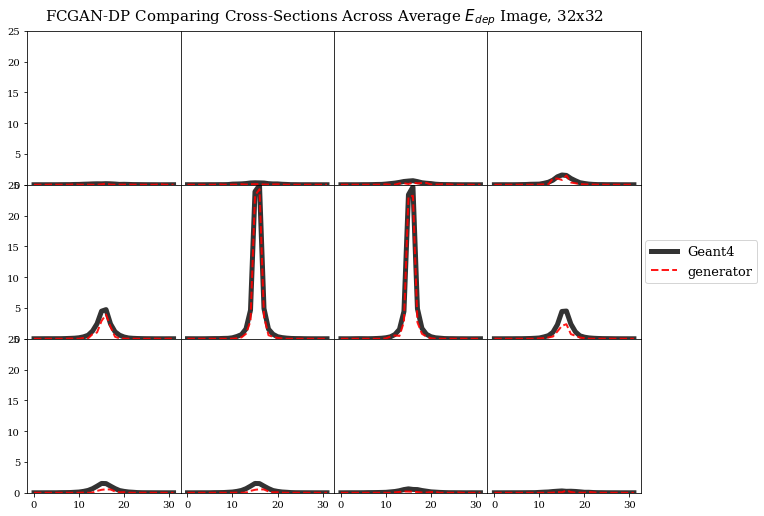

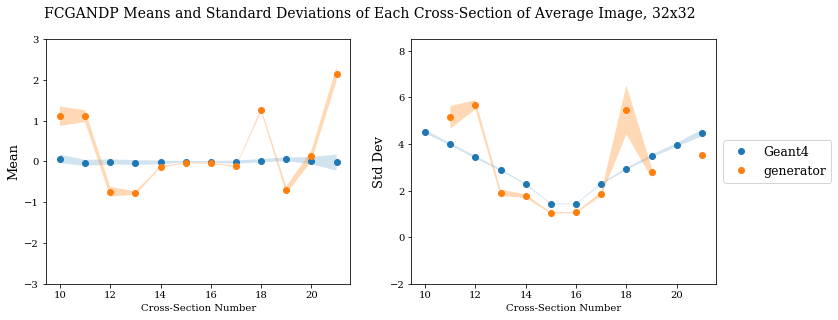

[69/100][0/938] Loss_D: 0.1003 Loss_G: 6.1124 D(x): 0.9597 D(G(z)): 0.0373 / 0.0066
[69/100][100/938] Loss_D: 0.2992 Loss_G: 5.5196 D(x): 0.8779 D(G(z)): 0.0748 / 0.0159
[69/100][200/938] Loss_D: 0.3548 Loss_G: 4.8183 D(x): 0.9889 D(G(z)): 0.1283 / 0.0353
[69/100][300/938] Loss_D: 0.4275 Loss_G: 5.3284 D(x): 0.8826 D(G(z)): 0.0811 / 0.0284
[69/100][400/938] Loss_D: 0.2415 Loss_G: 6.2784 D(x): 0.9534 D(G(z)): 0.0661 / 0.0278
[69/100][500/938] Loss_D: 0.1715 Loss_G: 5.0699 D(x): 0.9186 D(G(z)): 0.0542 / 0.0213
[69/100][600/938] Loss_D: 0.4933 Loss_G: 4.4691 D(x): 0.9028 D(G(z)): 0.1291 / 0.0296
[69/100][700/938] Loss_D: 0.2914 Loss_G: 5.4278 D(x): 0.9494 D(G(z)): 0.1386 / 0.0130
[69/100][800/938] Loss_D: 0.1054 Loss_G: 5.9984 D(x): 0.9358 D(G(z)): 0.0270 / 0.0136
[69/100][900/938] Loss_D: 0.1955 Loss_G: 5.1853 D(x): 0.9190 D(G(z)): 0.0314 / 0.0212
(32, 32)


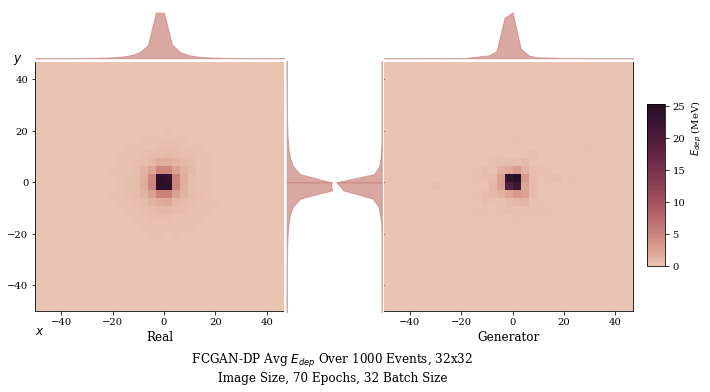

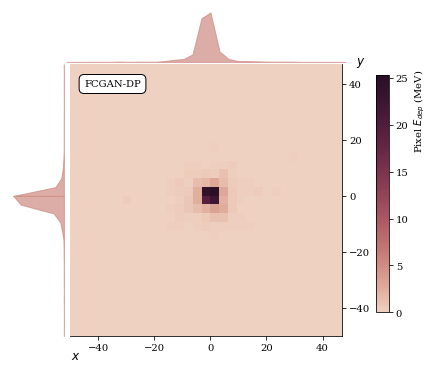

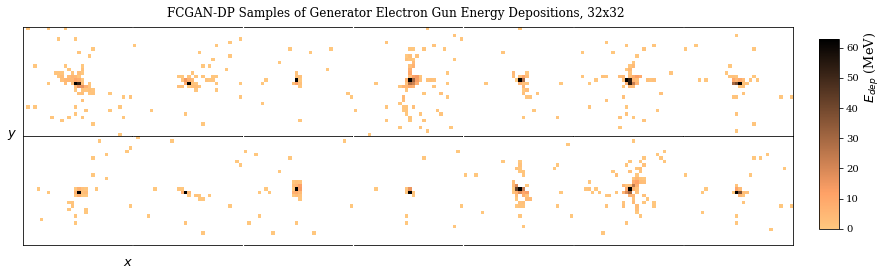

0.13942069 0.1951299999057689
(32,)


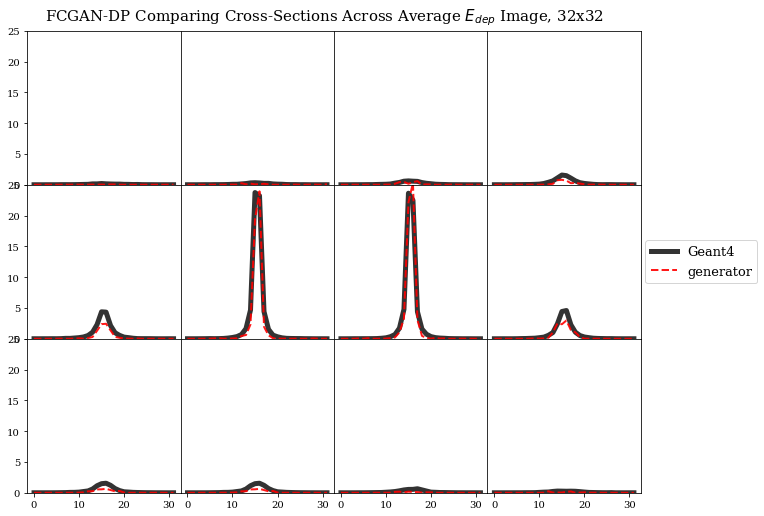

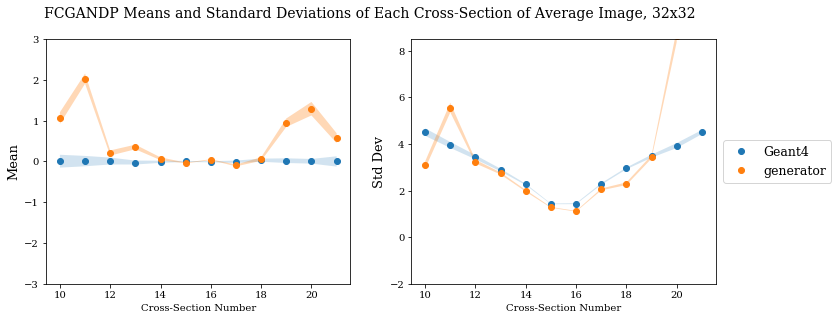

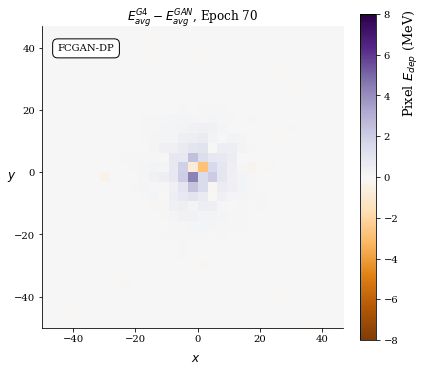

[70/100][0/938] Loss_D: 0.2301 Loss_G: 4.6956 D(x): 0.9113 D(G(z)): 0.0586 / 0.0265
[70/100][100/938] Loss_D: 0.2867 Loss_G: 4.3536 D(x): 0.8881 D(G(z)): 0.0561 / 0.0312
[70/100][200/938] Loss_D: 0.1482 Loss_G: 4.7676 D(x): 0.9468 D(G(z)): 0.0611 / 0.0213
[70/100][300/938] Loss_D: 0.3457 Loss_G: 4.6730 D(x): 0.9059 D(G(z)): 0.0897 / 0.0321
[70/100][400/938] Loss_D: 0.0590 Loss_G: 5.6552 D(x): 0.9955 D(G(z)): 0.0473 / 0.0148
[70/100][500/938] Loss_D: 0.1888 Loss_G: 6.2215 D(x): 0.9037 D(G(z)): 0.0370 / 0.0209
[70/100][600/938] Loss_D: 0.1611 Loss_G: 4.7994 D(x): 0.9233 D(G(z)): 0.0438 / 0.0267
[70/100][700/938] Loss_D: 0.4061 Loss_G: 5.1366 D(x): 0.9147 D(G(z)): 0.1002 / 0.0388
[70/100][800/938] Loss_D: 0.2970 Loss_G: 4.6799 D(x): 0.9011 D(G(z)): 0.0918 / 0.0334
[70/100][900/938] Loss_D: 0.1879 Loss_G: 4.7589 D(x): 0.9285 D(G(z)): 0.0751 / 0.0242
(32, 32)


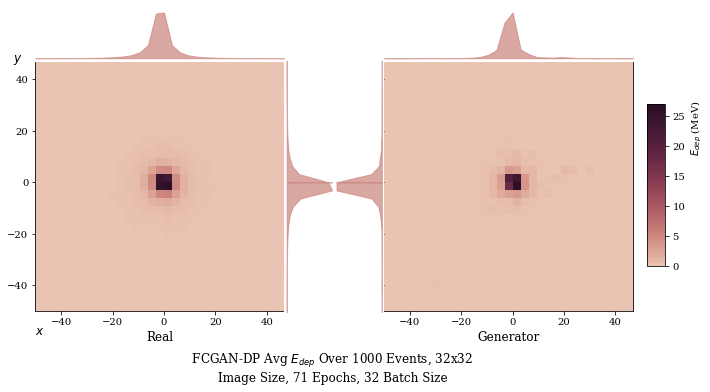

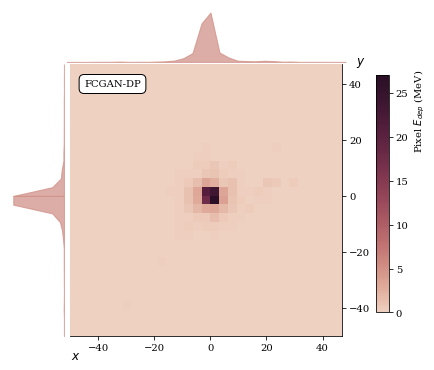

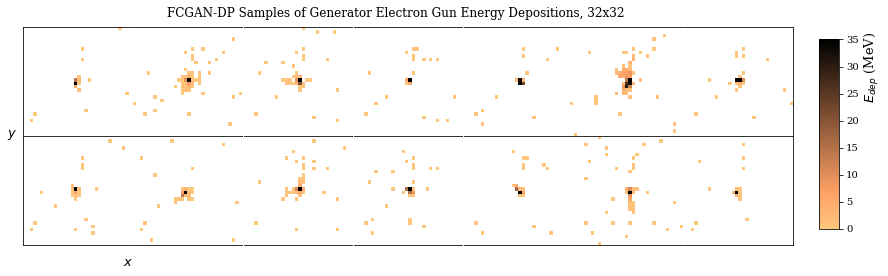

0.14805228 0.19842640442796272
(32,)


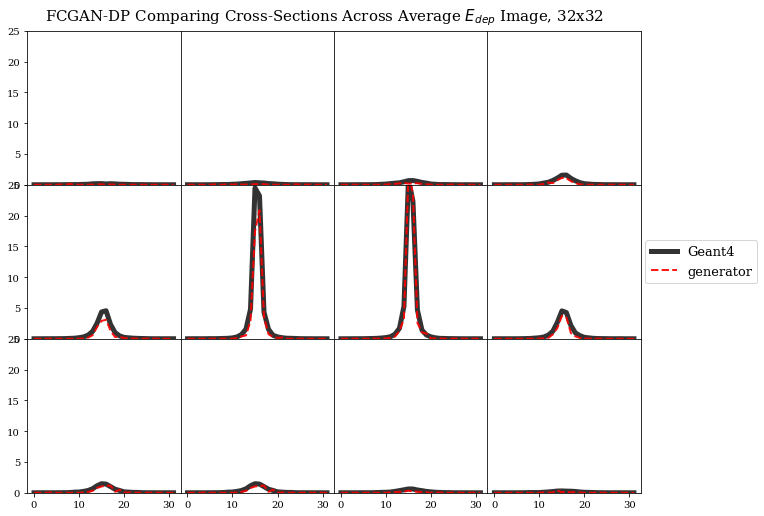

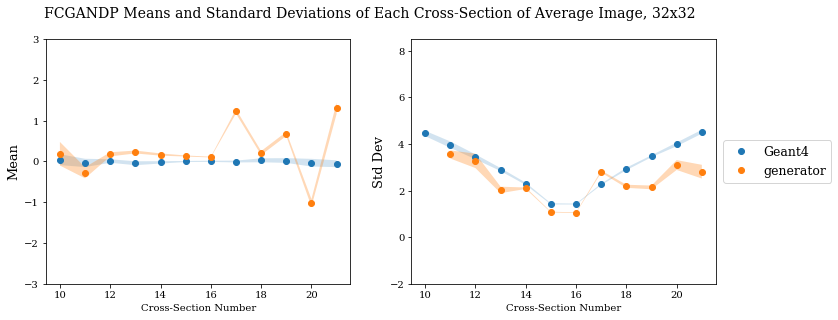

[71/100][0/938] Loss_D: 0.1450 Loss_G: 5.5465 D(x): 0.9465 D(G(z)): 0.0619 / 0.0148
[71/100][100/938] Loss_D: 0.4620 Loss_G: 5.7534 D(x): 0.9242 D(G(z)): 0.1557 / 0.0131
[71/100][200/938] Loss_D: 0.2027 Loss_G: 5.0709 D(x): 0.8997 D(G(z)): 0.0451 / 0.0188
[71/100][300/938] Loss_D: 0.3048 Loss_G: 4.1204 D(x): 0.8924 D(G(z)): 0.0596 / 0.0399
[71/100][400/938] Loss_D: 0.1506 Loss_G: 6.1399 D(x): 0.9671 D(G(z)): 0.0762 / 0.0121
[71/100][500/938] Loss_D: 0.2697 Loss_G: 6.1015 D(x): 0.9255 D(G(z)): 0.1077 / 0.0192
[71/100][600/938] Loss_D: 0.2484 Loss_G: 5.5517 D(x): 0.9633 D(G(z)): 0.1150 / 0.0268
[71/100][700/938] Loss_D: 0.1950 Loss_G: 4.3951 D(x): 0.9170 D(G(z)): 0.0339 / 0.0299
[71/100][800/938] Loss_D: 0.2954 Loss_G: 6.0011 D(x): 0.9211 D(G(z)): 0.0729 / 0.0163
[71/100][900/938] Loss_D: 0.2435 Loss_G: 4.9332 D(x): 0.8728 D(G(z)): 0.0407 / 0.0287
(32, 32)


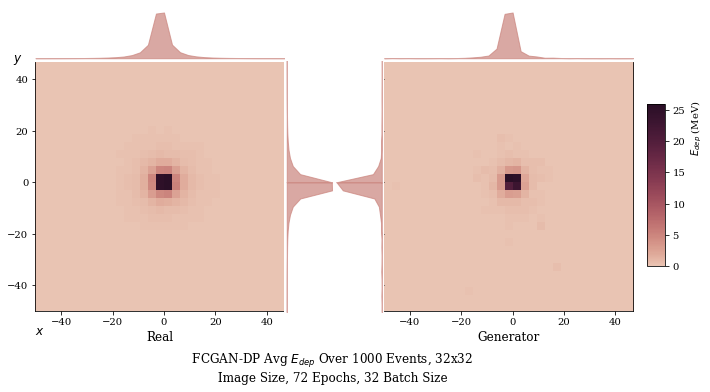

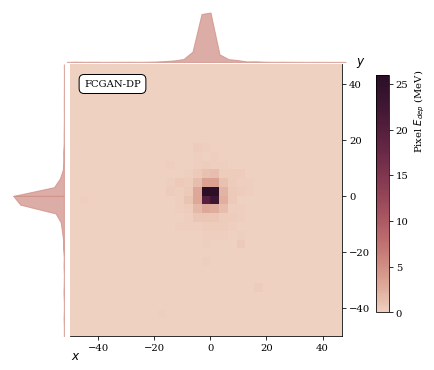

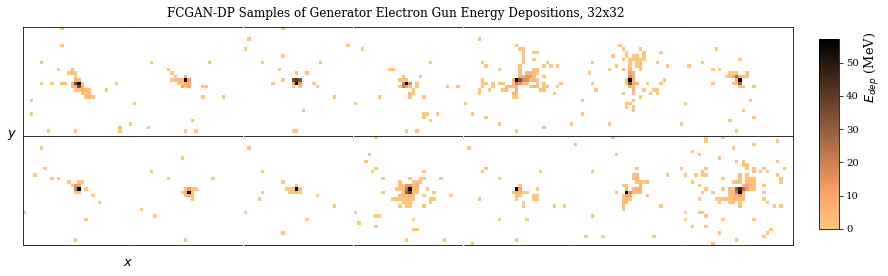

0.14710113 0.19438825148172373
(32,)


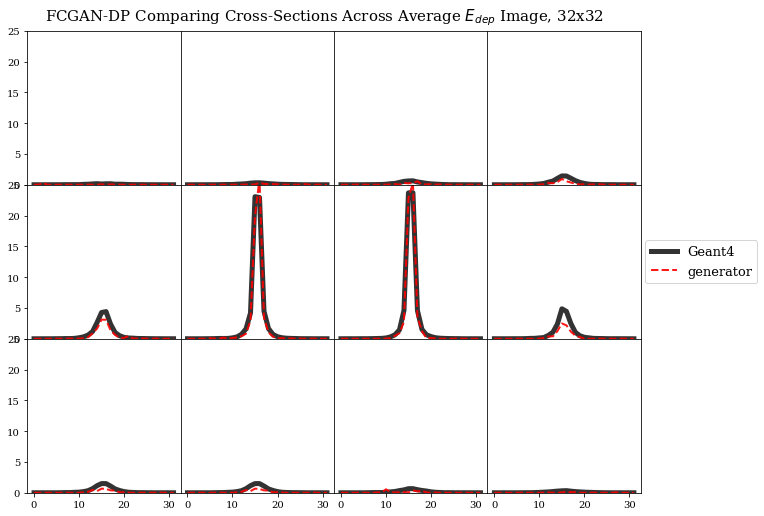

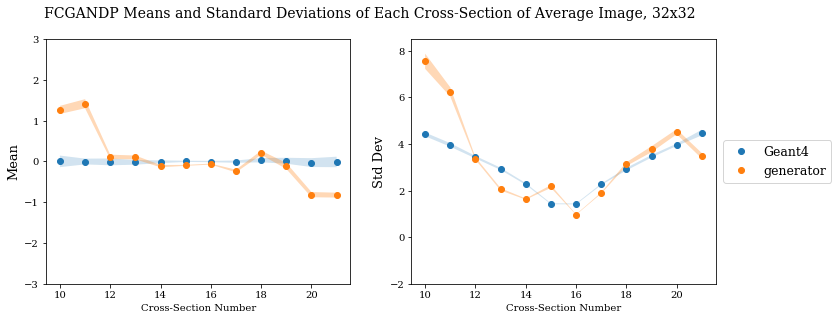

[72/100][0/938] Loss_D: 0.2033 Loss_G: 5.9307 D(x): 0.9518 D(G(z)): 0.0491 / 0.0156
[72/100][100/938] Loss_D: 0.4303 Loss_G: 4.4179 D(x): 0.8862 D(G(z)): 0.1482 / 0.0337
[72/100][200/938] Loss_D: 0.1949 Loss_G: 5.3710 D(x): 0.9349 D(G(z)): 0.0850 / 0.0175
[72/100][300/938] Loss_D: 0.3243 Loss_G: 4.7440 D(x): 0.9034 D(G(z)): 0.0818 / 0.0332
[72/100][400/938] Loss_D: 0.1493 Loss_G: 4.5756 D(x): 0.9648 D(G(z)): 0.0861 / 0.0371
[72/100][500/938] Loss_D: 0.2049 Loss_G: 4.5297 D(x): 0.9338 D(G(z)): 0.0892 / 0.0231
[72/100][600/938] Loss_D: 0.3095 Loss_G: 5.9780 D(x): 0.9197 D(G(z)): 0.0478 / 0.0156
[72/100][700/938] Loss_D: 0.5048 Loss_G: 4.7285 D(x): 0.9522 D(G(z)): 0.1975 / 0.0348
[72/100][800/938] Loss_D: 0.1672 Loss_G: 4.3828 D(x): 0.9382 D(G(z)): 0.0730 / 0.0373
[72/100][900/938] Loss_D: 0.2909 Loss_G: 5.0739 D(x): 0.8740 D(G(z)): 0.0497 / 0.0162
(32, 32)


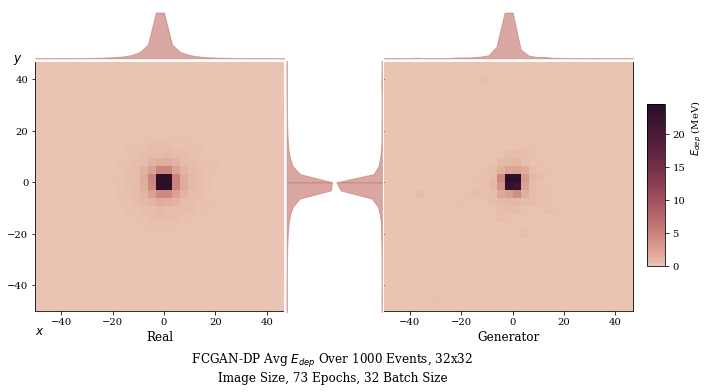

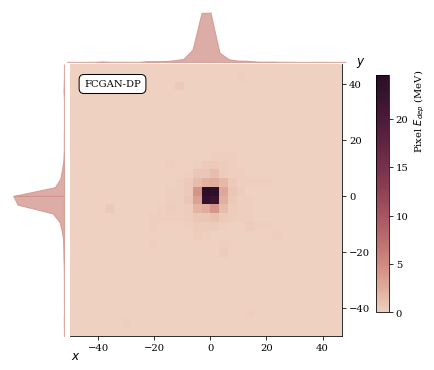

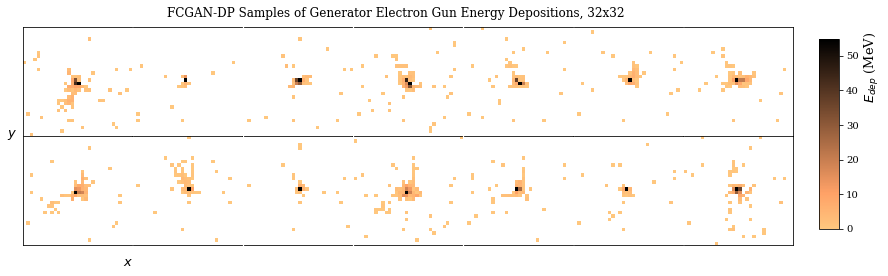

0.15003699 0.19622403345767975
(32,)


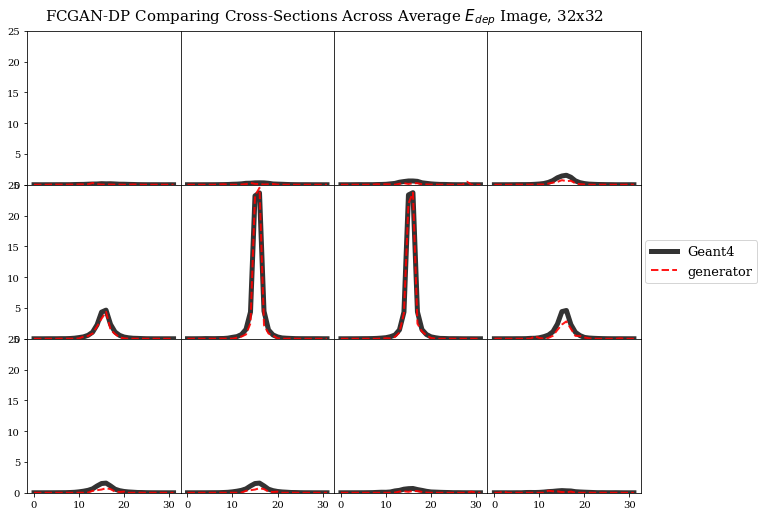

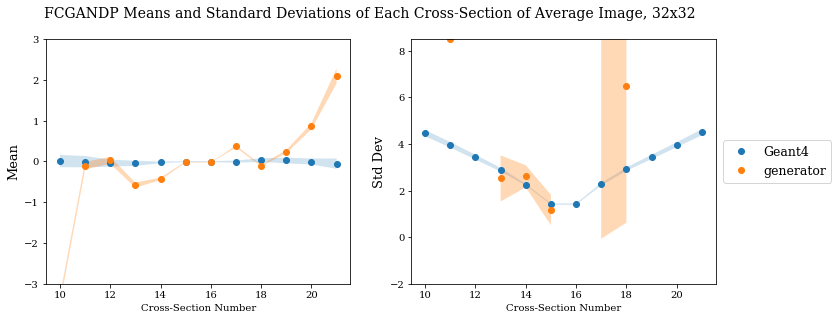

[73/100][0/938] Loss_D: 0.1755 Loss_G: 5.5207 D(x): 0.9549 D(G(z)): 0.0919 / 0.0229
[73/100][100/938] Loss_D: 0.2100 Loss_G: 5.2020 D(x): 0.9197 D(G(z)): 0.0826 / 0.0240
[73/100][200/938] Loss_D: 0.4230 Loss_G: 4.6560 D(x): 0.8418 D(G(z)): 0.0727 / 0.0350
[73/100][300/938] Loss_D: 0.3911 Loss_G: 4.9649 D(x): 0.9267 D(G(z)): 0.1774 / 0.0266
[73/100][400/938] Loss_D: 0.0430 Loss_G: 6.4734 D(x): 0.9761 D(G(z)): 0.0146 / 0.0077
[73/100][500/938] Loss_D: 0.3210 Loss_G: 4.9723 D(x): 0.9645 D(G(z)): 0.1297 / 0.0346
[73/100][600/938] Loss_D: 0.3604 Loss_G: 4.6197 D(x): 0.8079 D(G(z)): 0.0319 / 0.0335
[73/100][700/938] Loss_D: 0.2049 Loss_G: 5.2754 D(x): 0.9340 D(G(z)): 0.0572 / 0.0245
[73/100][800/938] Loss_D: 0.1620 Loss_G: 5.3420 D(x): 0.9488 D(G(z)): 0.0526 / 0.0174
[73/100][900/938] Loss_D: 0.3644 Loss_G: 5.1476 D(x): 0.9108 D(G(z)): 0.0912 / 0.0219
(32, 32)


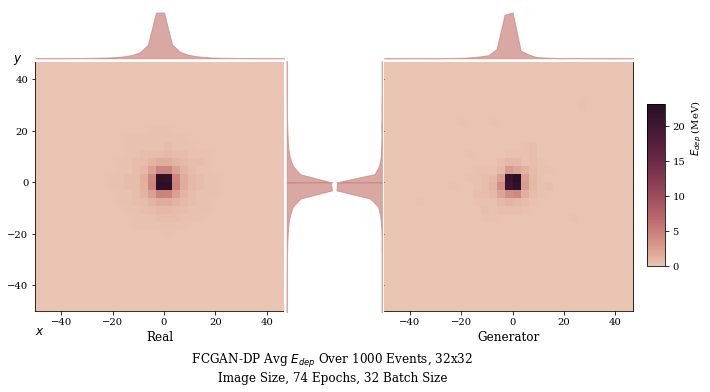

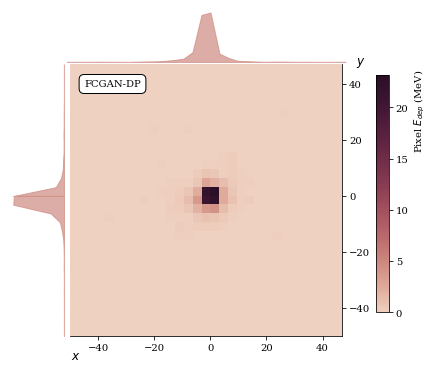

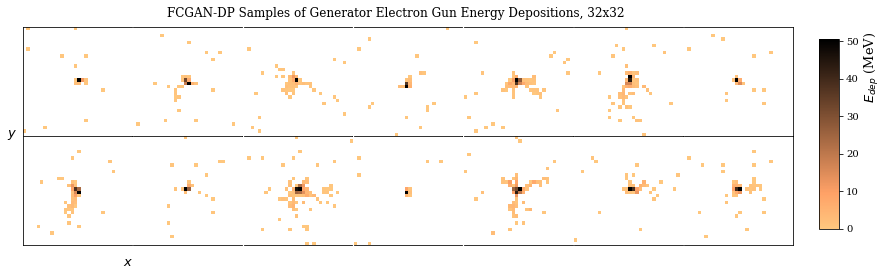

0.1397568 0.1985685723928916
(32,)


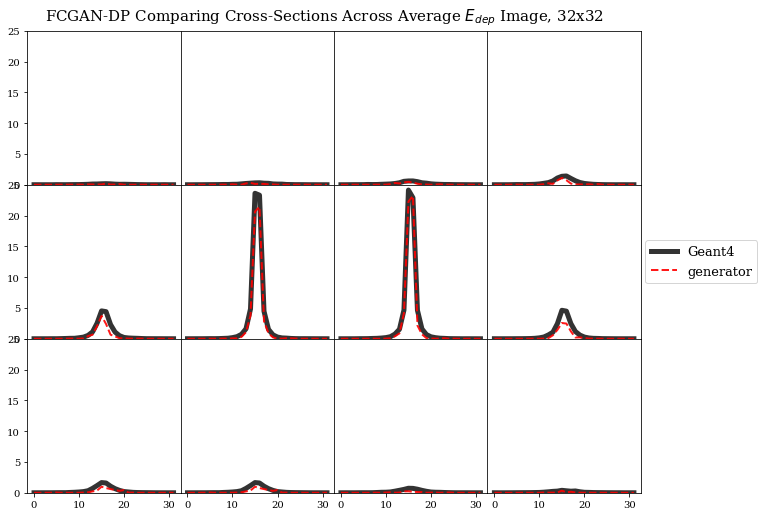

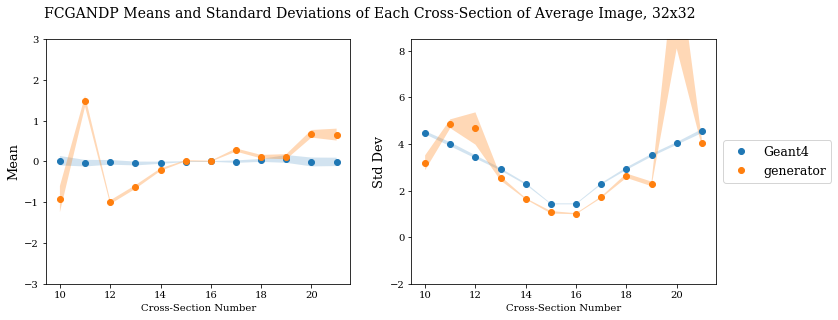

[74/100][0/938] Loss_D: 0.1267 Loss_G: 5.2176 D(x): 0.9515 D(G(z)): 0.0572 / 0.0174
[74/100][100/938] Loss_D: 0.3705 Loss_G: 5.1306 D(x): 0.8628 D(G(z)): 0.0863 / 0.0272
[74/100][200/938] Loss_D: 0.1409 Loss_G: 5.2232 D(x): 0.9571 D(G(z)): 0.0488 / 0.0227
[74/100][300/938] Loss_D: 0.4127 Loss_G: 5.8242 D(x): 0.9125 D(G(z)): 0.1144 / 0.0112
[74/100][400/938] Loss_D: 0.3169 Loss_G: 5.2973 D(x): 0.9185 D(G(z)): 0.0900 / 0.0251
[74/100][500/938] Loss_D: 0.1654 Loss_G: 5.8028 D(x): 0.9465 D(G(z)): 0.0540 / 0.0141
[74/100][600/938] Loss_D: 0.2675 Loss_G: 4.6981 D(x): 0.9675 D(G(z)): 0.1253 / 0.0273
[74/100][700/938] Loss_D: 0.2075 Loss_G: 5.8427 D(x): 0.9322 D(G(z)): 0.0893 / 0.0089
[74/100][800/938] Loss_D: 0.1846 Loss_G: 4.9906 D(x): 0.9546 D(G(z)): 0.1000 / 0.0254
[74/100][900/938] Loss_D: 0.2466 Loss_G: 5.3655 D(x): 0.9126 D(G(z)): 0.0499 / 0.0226
(32, 32)


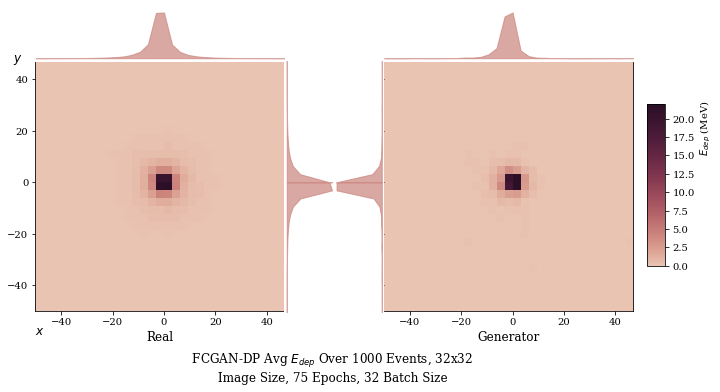

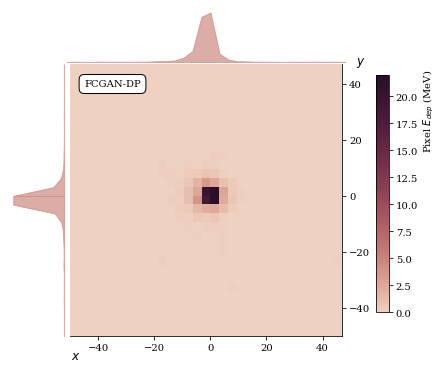

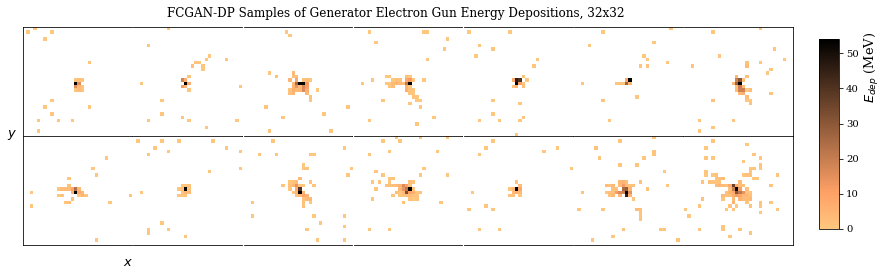

0.12727973 0.19325893198559663
(32,)


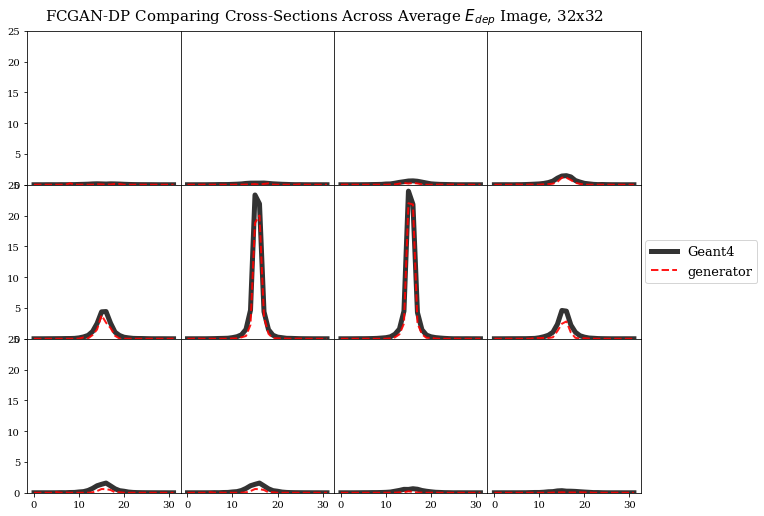

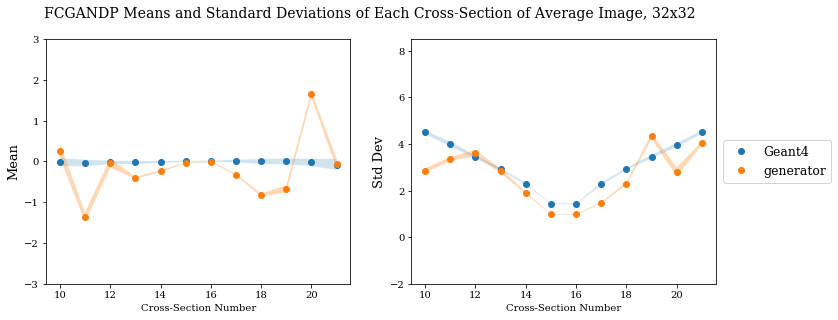

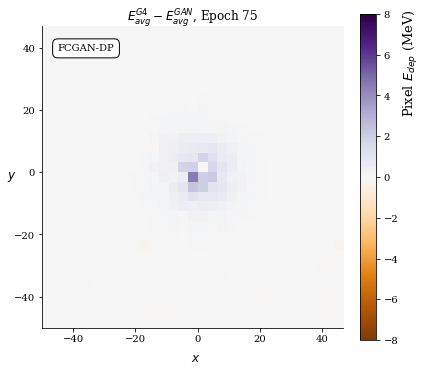

[75/100][0/938] Loss_D: 0.2646 Loss_G: 5.5198 D(x): 0.9286 D(G(z)): 0.1162 / 0.0309
[75/100][100/938] Loss_D: 0.2773 Loss_G: 4.7168 D(x): 0.9210 D(G(z)): 0.0655 / 0.0212
[75/100][200/938] Loss_D: 0.2183 Loss_G: 4.5638 D(x): 0.9317 D(G(z)): 0.0792 / 0.0337
[75/100][300/938] Loss_D: 0.3149 Loss_G: 5.1728 D(x): 0.8908 D(G(z)): 0.0766 / 0.0263
[75/100][400/938] Loss_D: 0.0911 Loss_G: 5.3795 D(x): 0.9554 D(G(z)): 0.0370 / 0.0233
[75/100][500/938] Loss_D: 0.1913 Loss_G: 4.9816 D(x): 0.9487 D(G(z)): 0.0895 / 0.0286
[75/100][600/938] Loss_D: 0.2474 Loss_G: 5.2189 D(x): 0.9096 D(G(z)): 0.0710 / 0.0154
[75/100][700/938] Loss_D: 0.0969 Loss_G: 5.7690 D(x): 0.9498 D(G(z)): 0.0315 / 0.0137
[75/100][800/938] Loss_D: 0.0970 Loss_G: 4.8298 D(x): 0.9509 D(G(z)): 0.0333 / 0.0266
[75/100][900/938] Loss_D: 0.1766 Loss_G: 6.1813 D(x): 0.8975 D(G(z)): 0.0260 / 0.0106
(32, 32)


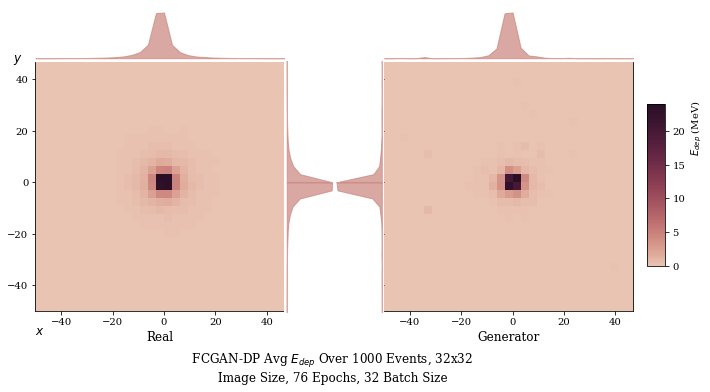

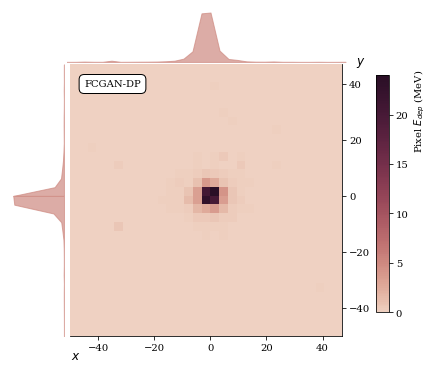

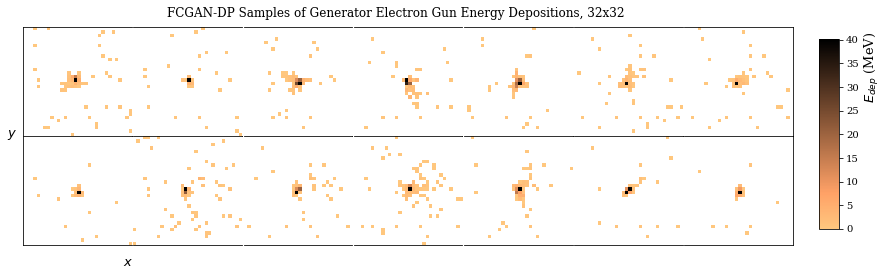

0.1396709 0.19583187391818824
(32,)


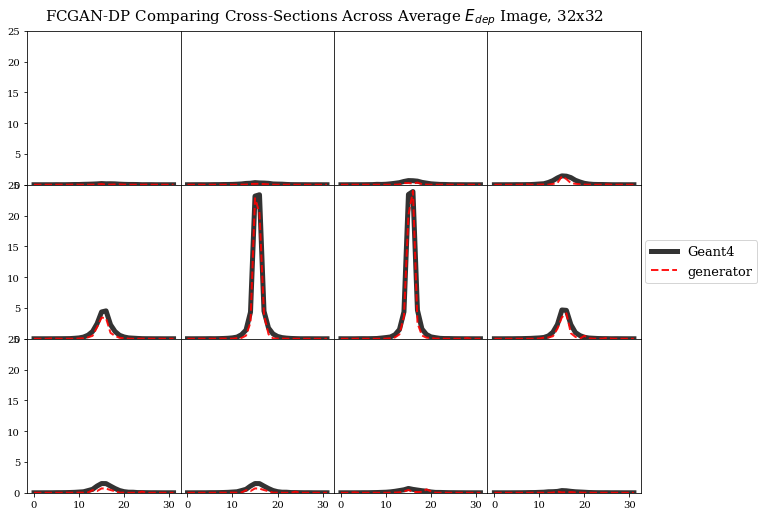

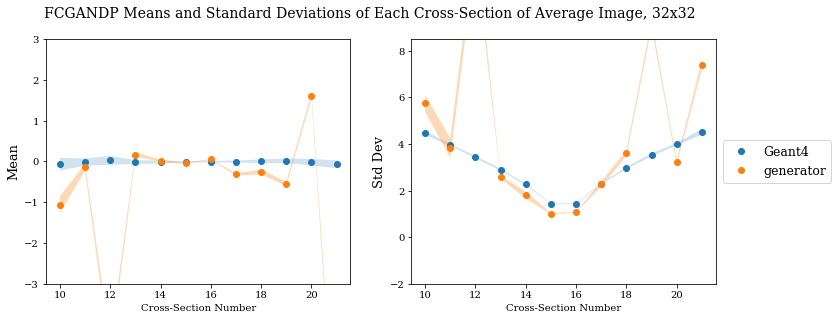

[76/100][0/938] Loss_D: 0.2288 Loss_G: 6.0804 D(x): 0.9357 D(G(z)): 0.0870 / 0.0176
[76/100][100/938] Loss_D: 0.2550 Loss_G: 4.8026 D(x): 0.9316 D(G(z)): 0.0819 / 0.0324
[76/100][200/938] Loss_D: 0.3437 Loss_G: 5.3488 D(x): 0.8750 D(G(z)): 0.0750 / 0.0154
[76/100][300/938] Loss_D: 0.1319 Loss_G: 5.5181 D(x): 0.9437 D(G(z)): 0.0416 / 0.0203
[76/100][400/938] Loss_D: 0.0955 Loss_G: 6.0026 D(x): 0.9789 D(G(z)): 0.0461 / 0.0156
[76/100][500/938] Loss_D: 0.0970 Loss_G: 5.4854 D(x): 0.9626 D(G(z)): 0.0461 / 0.0225
[76/100][600/938] Loss_D: 0.1372 Loss_G: 4.8082 D(x): 0.9514 D(G(z)): 0.0573 / 0.0199
[76/100][700/938] Loss_D: 0.2923 Loss_G: 4.7960 D(x): 0.9473 D(G(z)): 0.0795 / 0.0290
[76/100][800/938] Loss_D: 0.1094 Loss_G: 5.7029 D(x): 0.9538 D(G(z)): 0.0503 / 0.0198
[76/100][900/938] Loss_D: 0.1075 Loss_G: 5.8655 D(x): 0.9357 D(G(z)): 0.0183 / 0.0121
(32, 32)


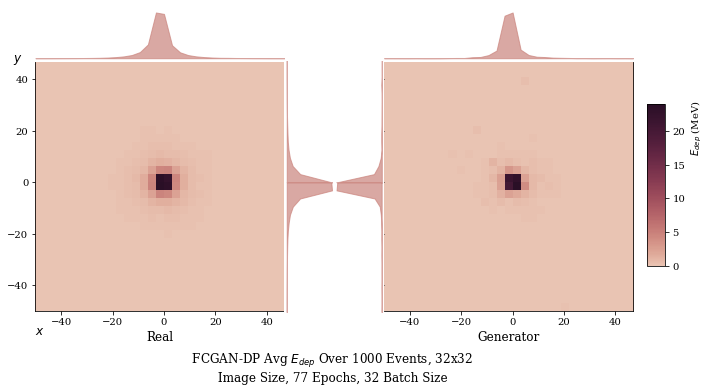

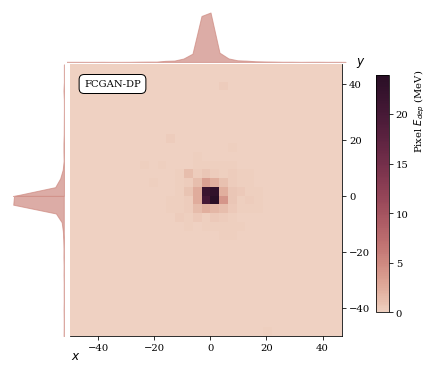

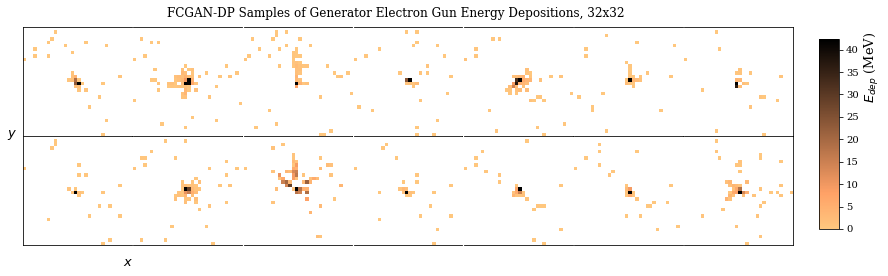

0.13314512 0.19627398712244054
(32,)


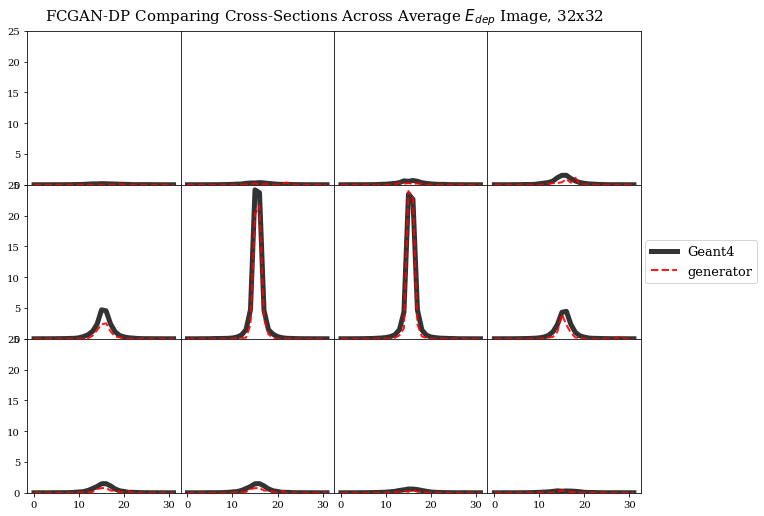

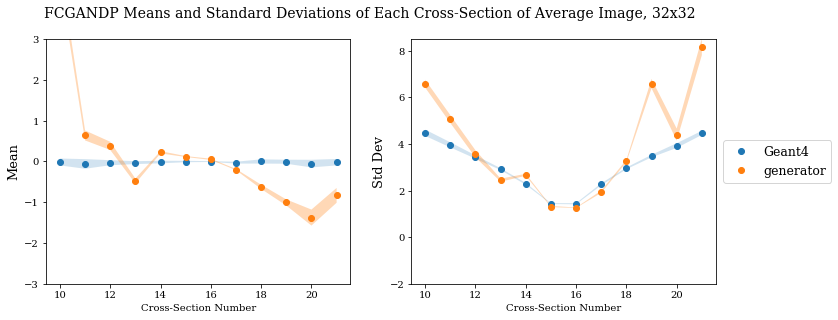

[77/100][0/938] Loss_D: 0.1842 Loss_G: 5.8231 D(x): 0.9433 D(G(z)): 0.0764 / 0.0110
[77/100][100/938] Loss_D: 0.2864 Loss_G: 5.5696 D(x): 0.8910 D(G(z)): 0.0581 / 0.0196
[77/100][200/938] Loss_D: 0.0896 Loss_G: 5.2572 D(x): 0.9810 D(G(z)): 0.0546 / 0.0164
[77/100][300/938] Loss_D: 0.5437 Loss_G: 6.6611 D(x): 0.9214 D(G(z)): 0.1403 / 0.0103
[77/100][400/938] Loss_D: 0.1655 Loss_G: 5.8314 D(x): 0.9356 D(G(z)): 0.0621 / 0.0235
[77/100][500/938] Loss_D: 0.0885 Loss_G: 4.8087 D(x): 0.9873 D(G(z)): 0.0541 / 0.0345
[77/100][600/938] Loss_D: 0.4446 Loss_G: 5.4714 D(x): 0.9284 D(G(z)): 0.1378 / 0.0209
[77/100][700/938] Loss_D: 0.1847 Loss_G: 6.6207 D(x): 0.9258 D(G(z)): 0.0523 / 0.0105
[77/100][800/938] Loss_D: 0.1302 Loss_G: 5.5013 D(x): 0.9454 D(G(z)): 0.0525 / 0.0102
[77/100][900/938] Loss_D: 0.1686 Loss_G: 5.2451 D(x): 0.9327 D(G(z)): 0.0480 / 0.0199
(32, 32)


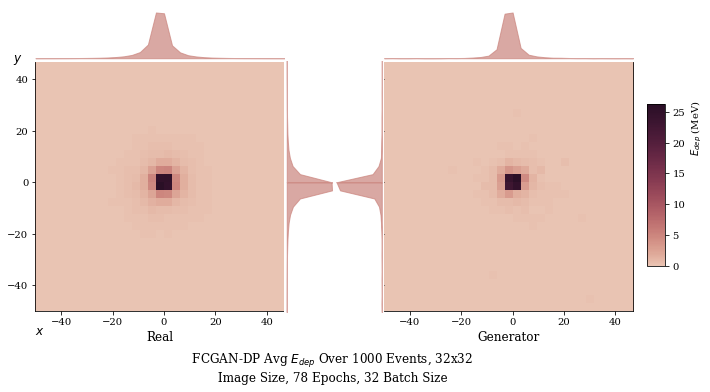

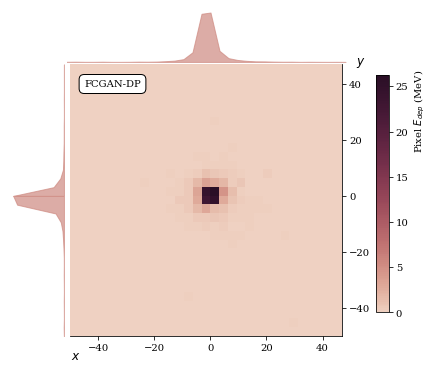

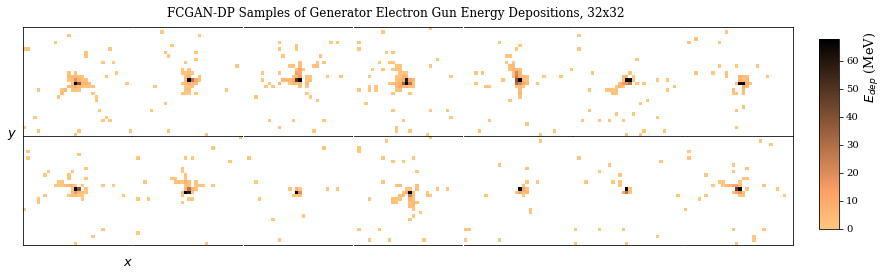

0.15322796 0.19442636529014384
(32,)


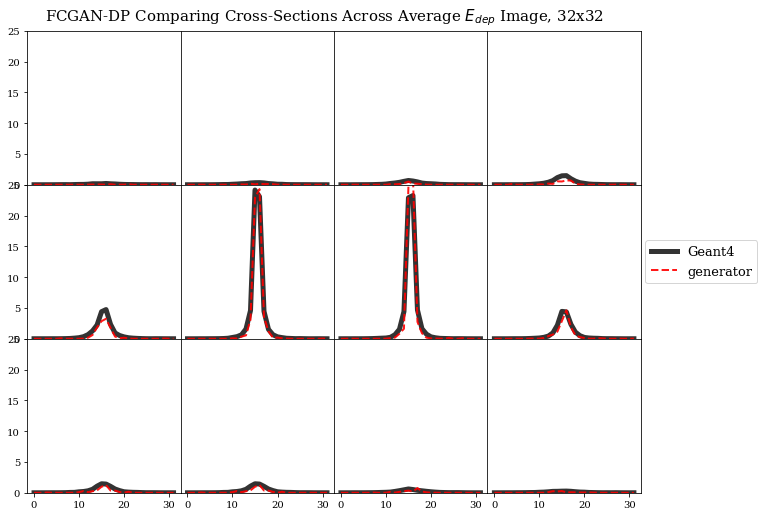

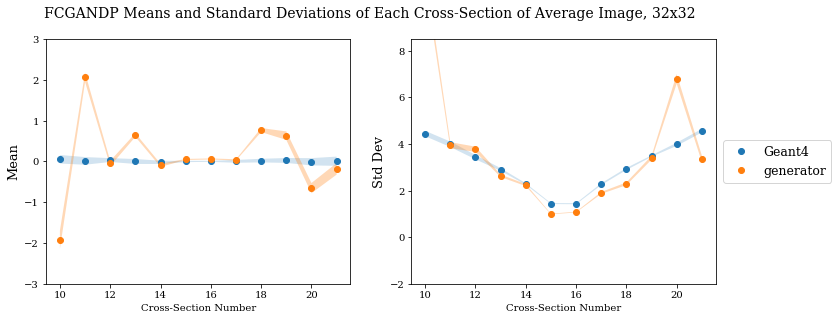

[78/100][0/938] Loss_D: 0.0971 Loss_G: 5.7902 D(x): 0.9739 D(G(z)): 0.0538 / 0.0158
[78/100][100/938] Loss_D: 0.2745 Loss_G: 5.3150 D(x): 0.8955 D(G(z)): 0.0224 / 0.0145
[78/100][200/938] Loss_D: 0.3048 Loss_G: 5.1710 D(x): 0.8872 D(G(z)): 0.0964 / 0.0291
[78/100][300/938] Loss_D: 0.2783 Loss_G: 5.1313 D(x): 0.9357 D(G(z)): 0.1035 / 0.0195
[78/100][400/938] Loss_D: 0.1122 Loss_G: 6.2323 D(x): 0.9656 D(G(z)): 0.0544 / 0.0087
[78/100][500/938] Loss_D: 0.2604 Loss_G: 5.4940 D(x): 0.8986 D(G(z)): 0.0615 / 0.0158
[78/100][600/938] Loss_D: 0.1987 Loss_G: 5.9137 D(x): 0.9466 D(G(z)): 0.0595 / 0.0112
[78/100][700/938] Loss_D: 0.2046 Loss_G: 6.1522 D(x): 0.9266 D(G(z)): 0.0710 / 0.0154
[78/100][800/938] Loss_D: 0.1308 Loss_G: 6.1119 D(x): 0.9667 D(G(z)): 0.0683 / 0.0082
[78/100][900/938] Loss_D: 0.2308 Loss_G: 5.6482 D(x): 0.9248 D(G(z)): 0.0666 / 0.0162
(32, 32)


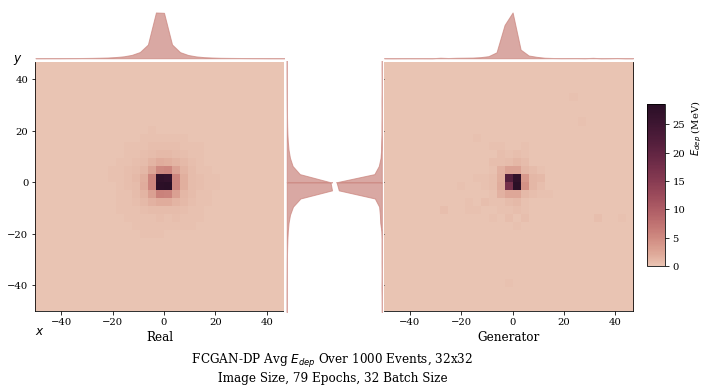

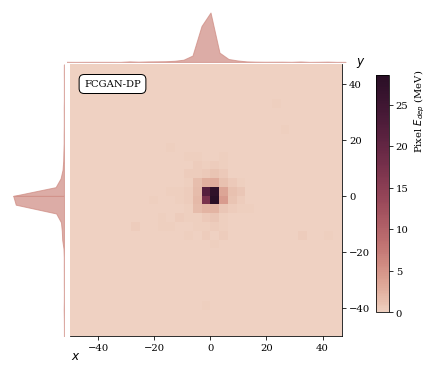

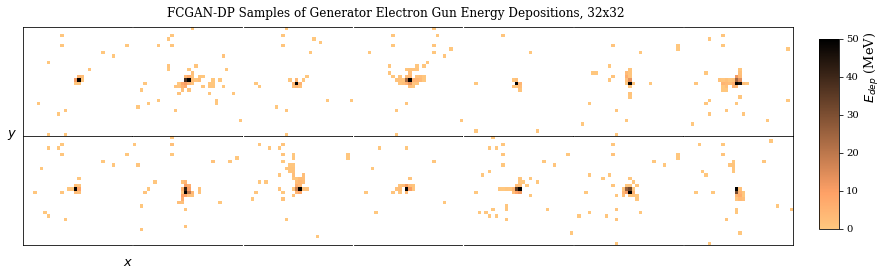

0.1455085 0.19737431769785724
(32,)


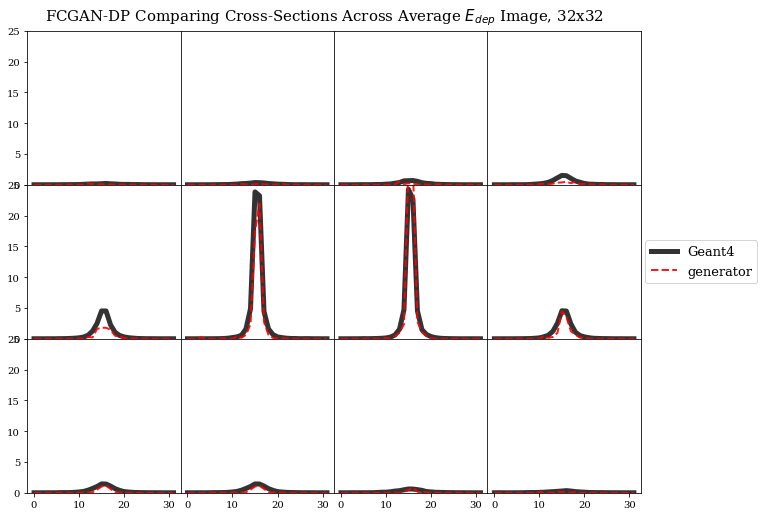

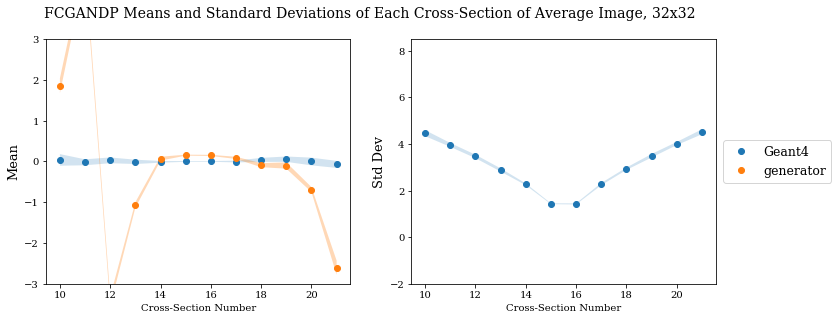

[79/100][0/938] Loss_D: 0.1756 Loss_G: 6.6045 D(x): 0.9652 D(G(z)): 0.0584 / 0.0138
[79/100][100/938] Loss_D: 0.2452 Loss_G: 6.2870 D(x): 0.9367 D(G(z)): 0.0768 / 0.0127
[79/100][200/938] Loss_D: 0.8223 Loss_G: 6.1053 D(x): 0.9545 D(G(z)): 0.1633 / 0.0187
[79/100][300/938] Loss_D: 0.1049 Loss_G: 5.3455 D(x): 0.9719 D(G(z)): 0.0619 / 0.0227
[79/100][400/938] Loss_D: 0.1666 Loss_G: 6.0504 D(x): 0.9874 D(G(z)): 0.0686 / 0.0158
[79/100][500/938] Loss_D: 0.2655 Loss_G: 5.5400 D(x): 0.9624 D(G(z)): 0.1241 / 0.0206
[79/100][600/938] Loss_D: 0.2495 Loss_G: 5.1215 D(x): 0.9075 D(G(z)): 0.0634 / 0.0160
[79/100][700/938] Loss_D: 0.1352 Loss_G: 5.7586 D(x): 0.9593 D(G(z)): 0.0398 / 0.0134
[79/100][800/938] Loss_D: 0.0991 Loss_G: 5.3644 D(x): 0.9686 D(G(z)): 0.0471 / 0.0118
[79/100][900/938] Loss_D: 0.1990 Loss_G: 6.1773 D(x): 0.9122 D(G(z)): 0.0521 / 0.0087
(32, 32)


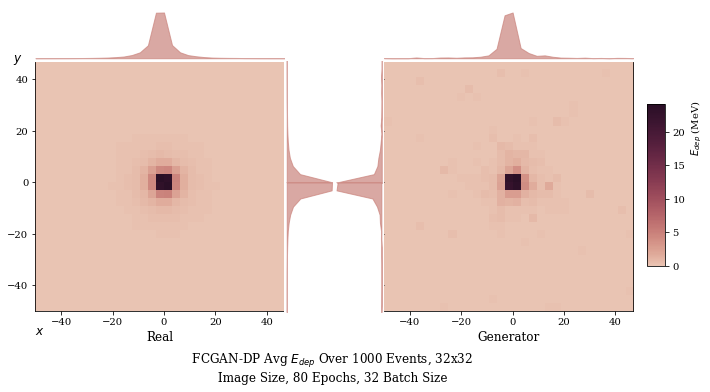

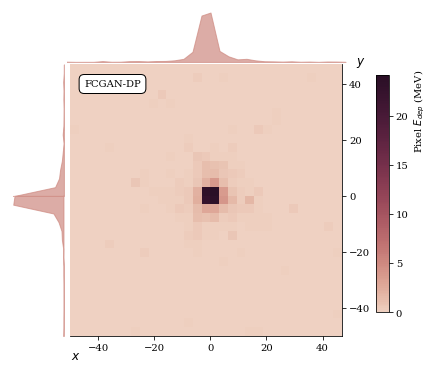

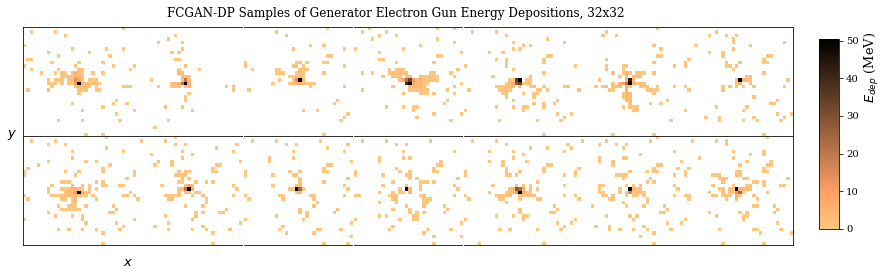

0.16771373 0.19550440348304438
(32,)


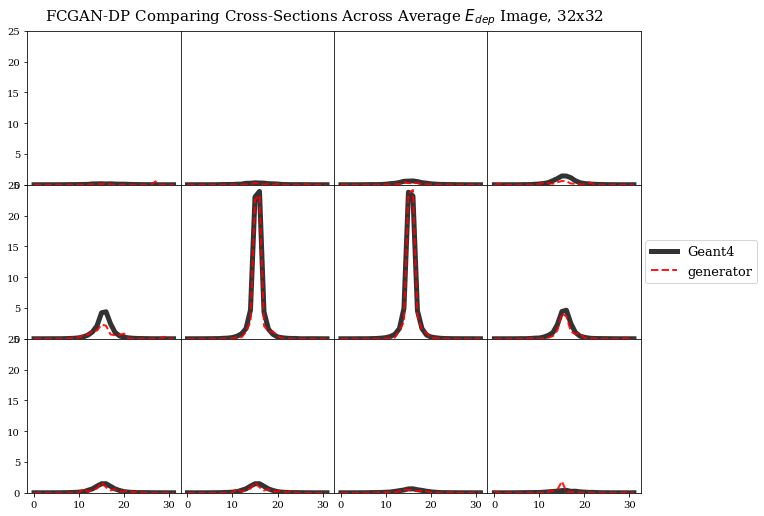

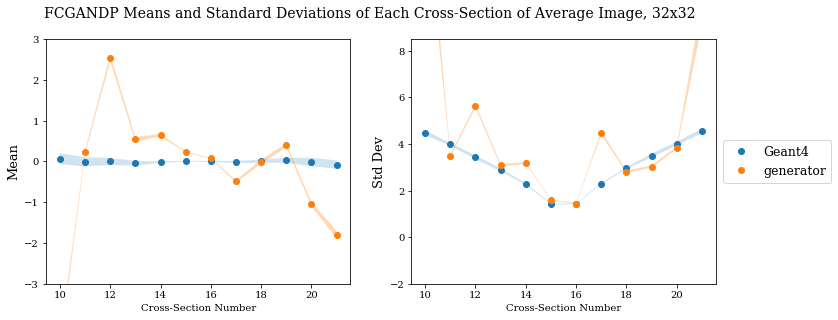

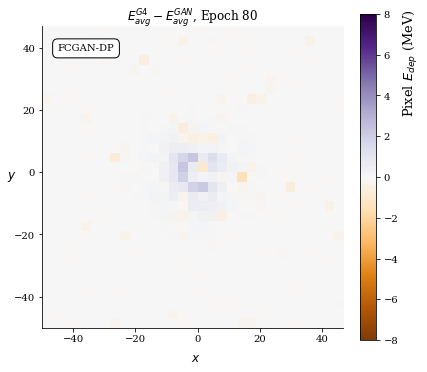

[80/100][0/938] Loss_D: 0.3829 Loss_G: 8.7969 D(x): 0.9297 D(G(z)): 0.1412 / 0.0050
[80/100][100/938] Loss_D: 0.1042 Loss_G: 8.1760 D(x): 0.9452 D(G(z)): 0.0250 / 0.0071
[80/100][200/938] Loss_D: 0.1842 Loss_G: 6.1486 D(x): 0.8829 D(G(z)): 0.0233 / 0.0136
[80/100][300/938] Loss_D: 0.2548 Loss_G: 5.8179 D(x): 0.8908 D(G(z)): 0.0285 / 0.0147
[80/100][400/938] Loss_D: 0.1335 Loss_G: 6.0949 D(x): 0.9356 D(G(z)): 0.0447 / 0.0173
[80/100][500/938] Loss_D: 0.3060 Loss_G: 5.2502 D(x): 0.8823 D(G(z)): 0.0738 / 0.0372
[80/100][600/938] Loss_D: 0.1340 Loss_G: 4.5831 D(x): 0.9537 D(G(z)): 0.0656 / 0.0297
[80/100][700/938] Loss_D: 0.1633 Loss_G: 6.6306 D(x): 0.9004 D(G(z)): 0.0193 / 0.0151
[80/100][800/938] Loss_D: 0.2492 Loss_G: 5.8873 D(x): 0.8831 D(G(z)): 0.0579 / 0.0317
[80/100][900/938] Loss_D: 0.0743 Loss_G: 5.6711 D(x): 0.9546 D(G(z)): 0.0149 / 0.0115
(32, 32)


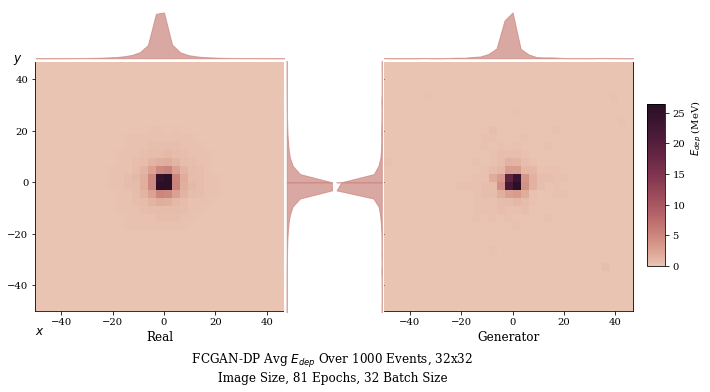

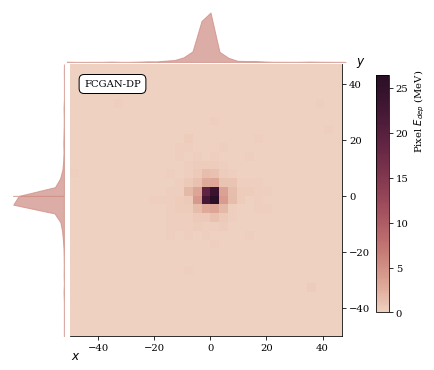

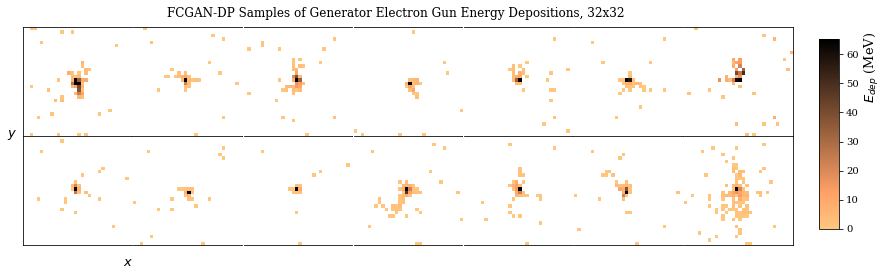

0.15466514 0.19441587740047783
(32,)


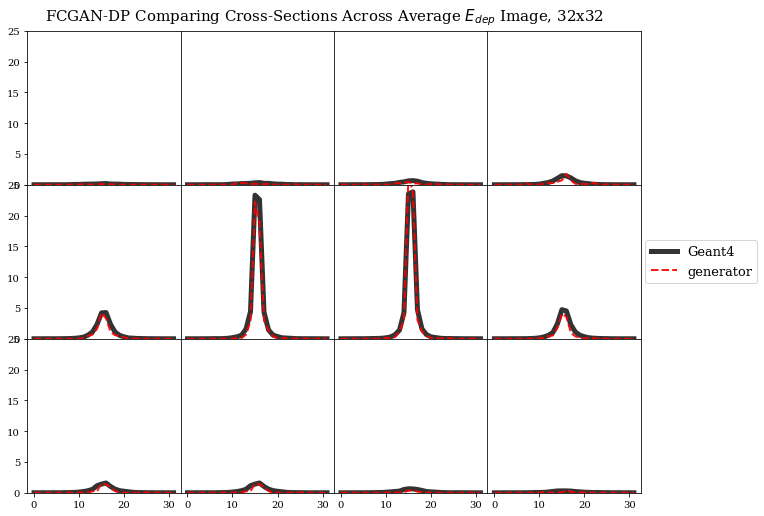

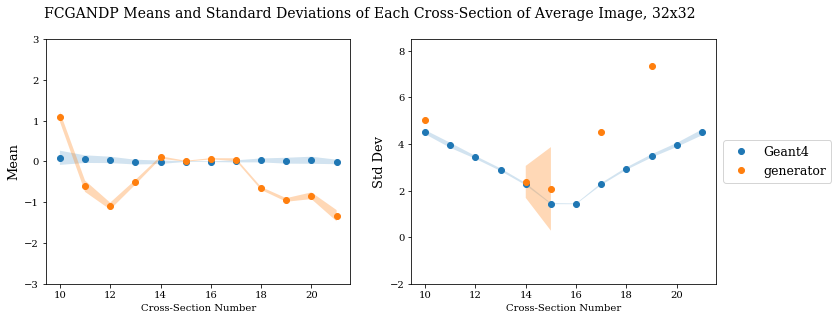

[81/100][0/938] Loss_D: 0.4907 Loss_G: 5.7667 D(x): 0.8544 D(G(z)): 0.0647 / 0.0237
[81/100][100/938] Loss_D: 0.1384 Loss_G: 5.2353 D(x): 0.9189 D(G(z)): 0.0344 / 0.0150
[81/100][200/938] Loss_D: 0.3253 Loss_G: 4.2289 D(x): 0.9023 D(G(z)): 0.1394 / 0.0365
[81/100][300/938] Loss_D: 0.1674 Loss_G: 5.0975 D(x): 0.9318 D(G(z)): 0.0492 / 0.0185
[81/100][400/938] Loss_D: 0.1365 Loss_G: 6.5386 D(x): 0.9703 D(G(z)): 0.0566 / 0.0174
[81/100][500/938] Loss_D: 0.3678 Loss_G: 5.7081 D(x): 0.9217 D(G(z)): 0.1284 / 0.0262
[81/100][600/938] Loss_D: 0.4337 Loss_G: 5.1102 D(x): 0.9492 D(G(z)): 0.1634 / 0.0236
[81/100][700/938] Loss_D: 0.1632 Loss_G: 6.2054 D(x): 0.9499 D(G(z)): 0.0746 / 0.0104
[81/100][800/938] Loss_D: 0.1853 Loss_G: 5.9818 D(x): 0.9134 D(G(z)): 0.0228 / 0.0133
[81/100][900/938] Loss_D: 0.3419 Loss_G: 4.8618 D(x): 0.8753 D(G(z)): 0.0913 / 0.0284
(32, 32)


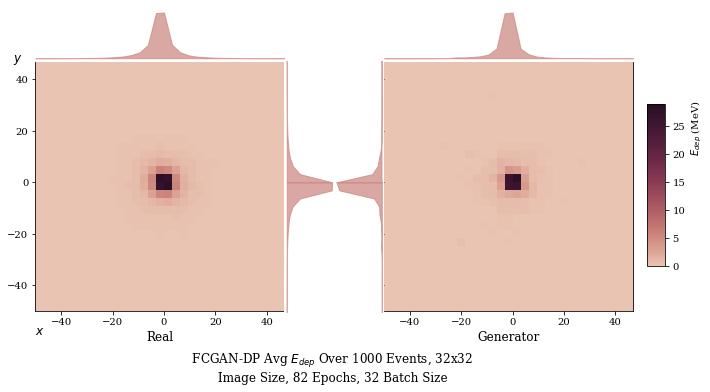

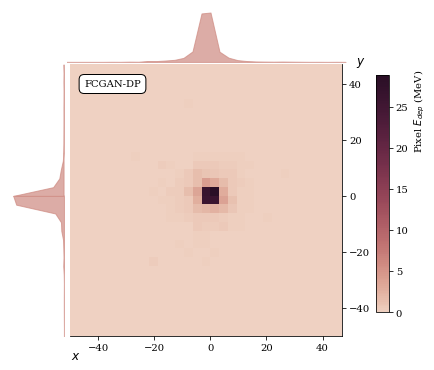

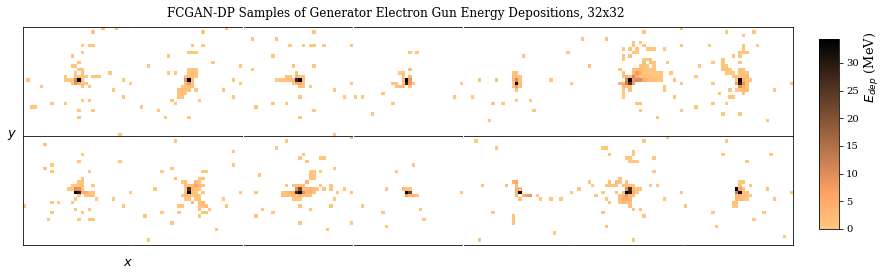

0.17470941 0.1962450001034382
(32,)


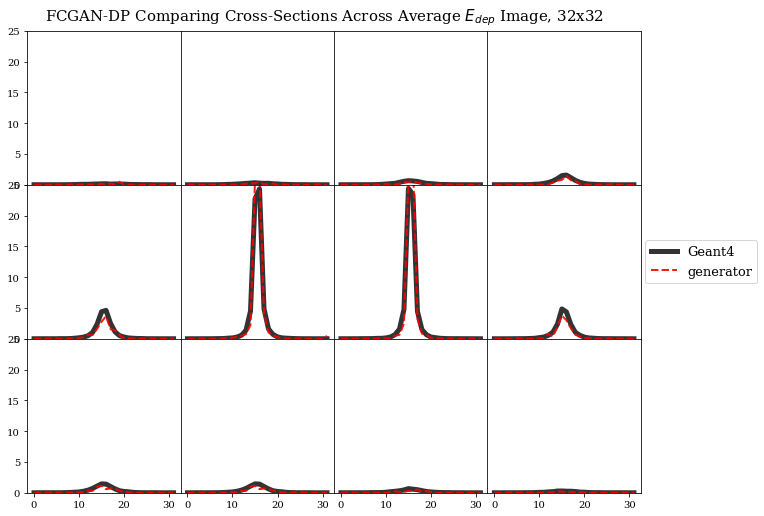

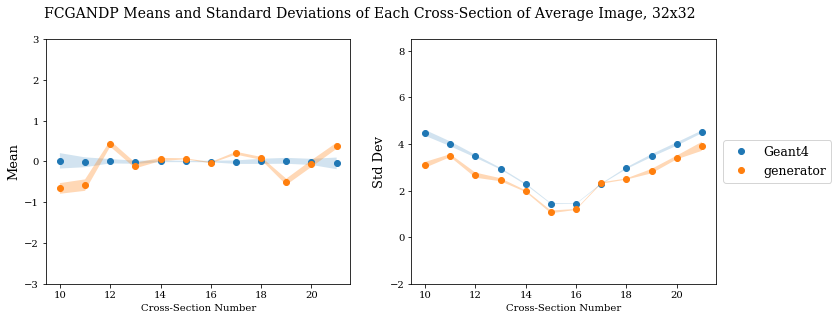

[82/100][0/938] Loss_D: 0.1654 Loss_G: 6.9432 D(x): 0.9624 D(G(z)): 0.0653 / 0.0095
[82/100][100/938] Loss_D: 0.4523 Loss_G: 6.3389 D(x): 0.8620 D(G(z)): 0.1091 / 0.0169
[82/100][200/938] Loss_D: 0.2313 Loss_G: 5.2005 D(x): 0.9383 D(G(z)): 0.0858 / 0.0158
[82/100][300/938] Loss_D: 0.2711 Loss_G: 5.4271 D(x): 0.9337 D(G(z)): 0.1147 / 0.0156
[82/100][400/938] Loss_D: 0.0851 Loss_G: 5.8328 D(x): 0.9639 D(G(z)): 0.0374 / 0.0225
[82/100][500/938] Loss_D: 0.3789 Loss_G: 4.8868 D(x): 0.8463 D(G(z)): 0.0809 / 0.0436
[82/100][600/938] Loss_D: 0.3274 Loss_G: 5.2960 D(x): 0.9571 D(G(z)): 0.1352 / 0.0389
[82/100][700/938] Loss_D: 0.0939 Loss_G: 6.3260 D(x): 0.9610 D(G(z)): 0.0401 / 0.0094
[82/100][800/938] Loss_D: 0.3037 Loss_G: 5.6302 D(x): 0.9373 D(G(z)): 0.0832 / 0.0361
[82/100][900/938] Loss_D: 0.1656 Loss_G: 4.7274 D(x): 0.9358 D(G(z)): 0.0555 / 0.0315
(32, 32)


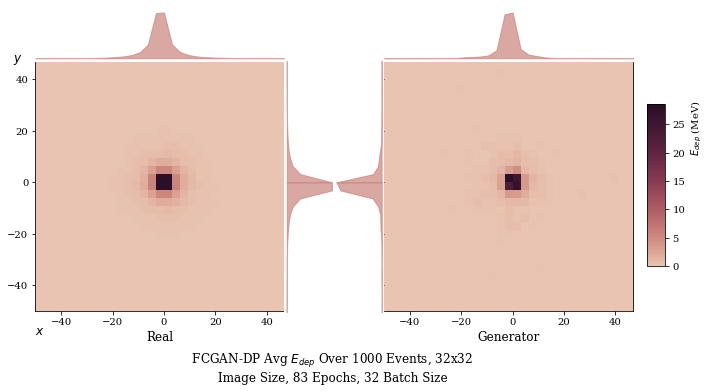

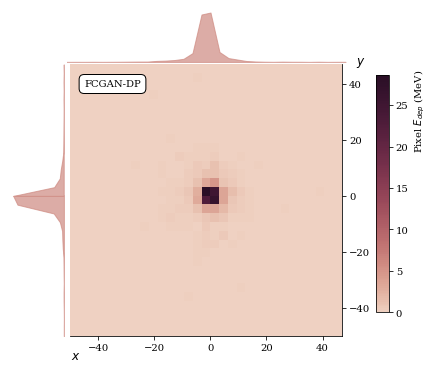

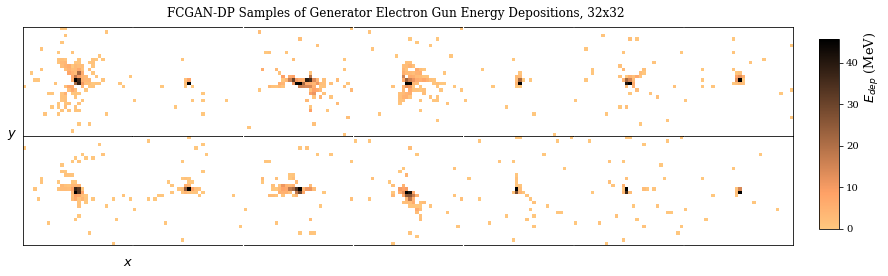

0.17300999 0.19533530054127707
(32,)


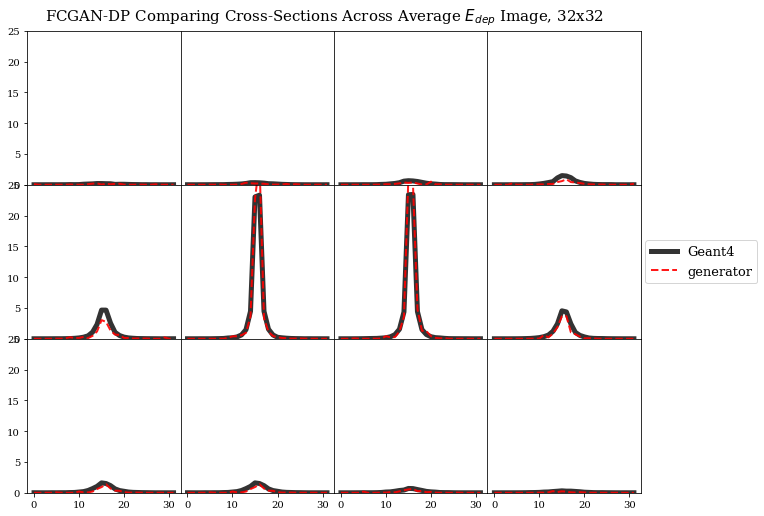

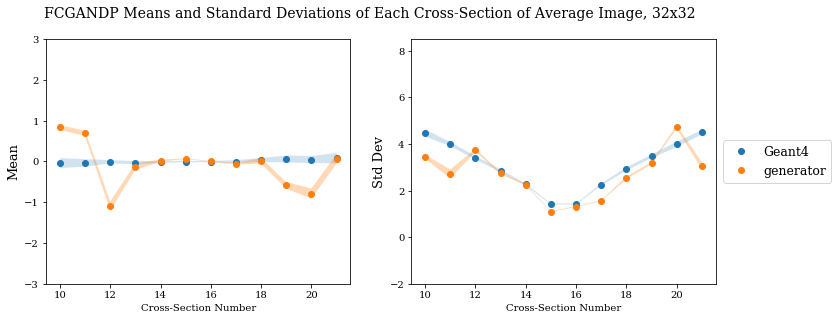

[83/100][0/938] Loss_D: 0.2257 Loss_G: 6.8565 D(x): 0.9383 D(G(z)): 0.0575 / 0.0139
[83/100][100/938] Loss_D: 0.4487 Loss_G: 4.8383 D(x): 0.9024 D(G(z)): 0.1062 / 0.0463
[83/100][200/938] Loss_D: 0.0878 Loss_G: 6.5460 D(x): 0.9852 D(G(z)): 0.0616 / 0.0083
[83/100][300/938] Loss_D: 0.3713 Loss_G: 4.4113 D(x): 0.9489 D(G(z)): 0.1742 / 0.0486
[83/100][400/938] Loss_D: 0.3181 Loss_G: 4.7698 D(x): 0.9334 D(G(z)): 0.1018 / 0.0247
[83/100][500/938] Loss_D: 0.3090 Loss_G: 5.4262 D(x): 0.8520 D(G(z)): 0.0229 / 0.0137
[83/100][600/938] Loss_D: 0.2220 Loss_G: 4.4795 D(x): 0.9639 D(G(z)): 0.1161 / 0.0340
[83/100][700/938] Loss_D: 0.1191 Loss_G: 6.1166 D(x): 0.9492 D(G(z)): 0.0500 / 0.0157
[83/100][800/938] Loss_D: 0.1067 Loss_G: 5.8269 D(x): 0.9661 D(G(z)): 0.0452 / 0.0130
[83/100][900/938] Loss_D: 0.4831 Loss_G: 6.4004 D(x): 0.9213 D(G(z)): 0.1427 / 0.0093
(32, 32)


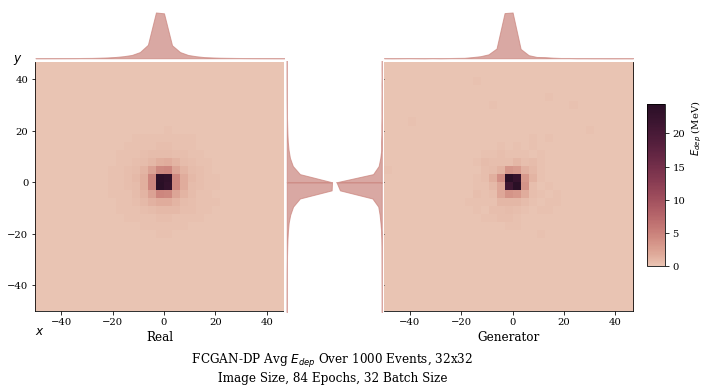

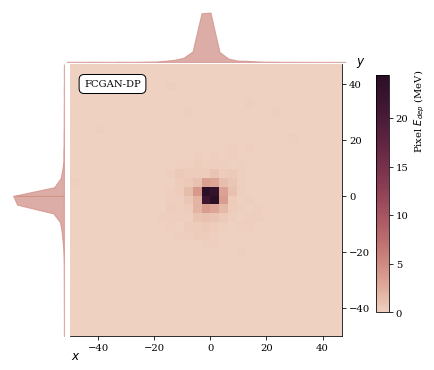

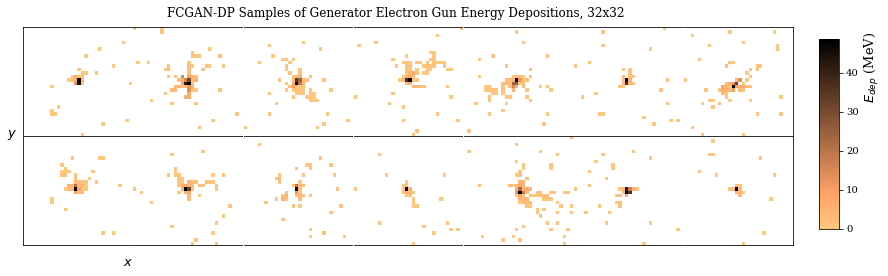

0.15200599 0.19417723485092098
(32,)


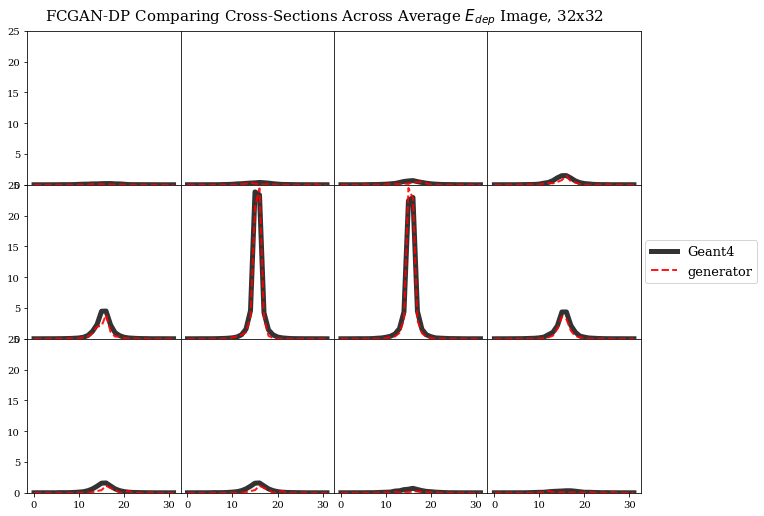

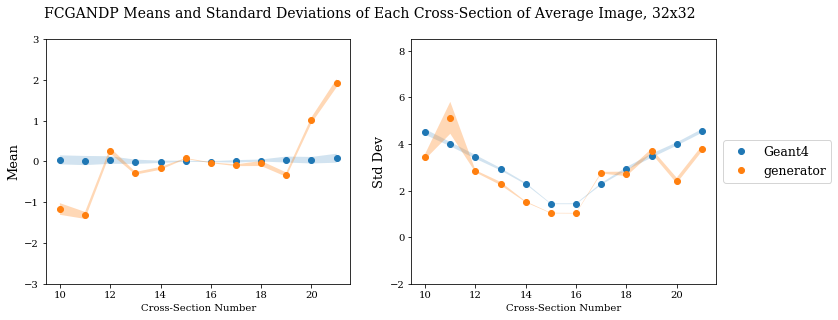

[84/100][0/938] Loss_D: 0.1915 Loss_G: 5.6384 D(x): 0.9227 D(G(z)): 0.0653 / 0.0134
[84/100][100/938] Loss_D: 0.3084 Loss_G: 6.0657 D(x): 0.8479 D(G(z)): 0.0446 / 0.0141
[84/100][200/938] Loss_D: 0.2872 Loss_G: 6.3319 D(x): 0.8840 D(G(z)): 0.0245 / 0.0075
[84/100][300/938] Loss_D: 0.3281 Loss_G: 5.2707 D(x): 0.9541 D(G(z)): 0.1635 / 0.0327
[84/100][400/938] Loss_D: 0.2144 Loss_G: 6.4996 D(x): 0.9778 D(G(z)): 0.0753 / 0.0139
[84/100][500/938] Loss_D: 0.4106 Loss_G: 6.0510 D(x): 0.8996 D(G(z)): 0.1102 / 0.0219
[84/100][600/938] Loss_D: 0.1855 Loss_G: 5.0736 D(x): 0.9426 D(G(z)): 0.0865 / 0.0165
[84/100][700/938] Loss_D: 0.2475 Loss_G: 6.2246 D(x): 0.9064 D(G(z)): 0.0433 / 0.0134
[84/100][800/938] Loss_D: 0.2639 Loss_G: 5.9029 D(x): 0.9688 D(G(z)): 0.1071 / 0.0373
[84/100][900/938] Loss_D: 0.1030 Loss_G: 6.5592 D(x): 0.9377 D(G(z)): 0.0244 / 0.0105
(32, 32)


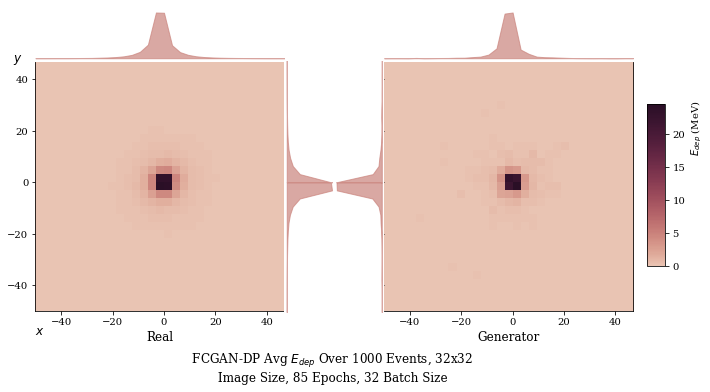

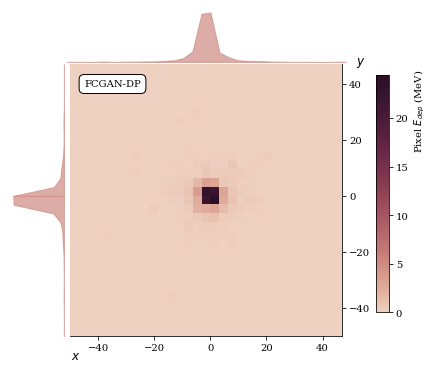

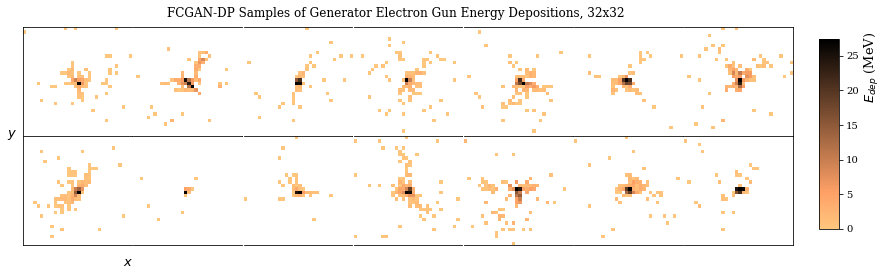

0.1507314 0.19459526648986913
(32,)


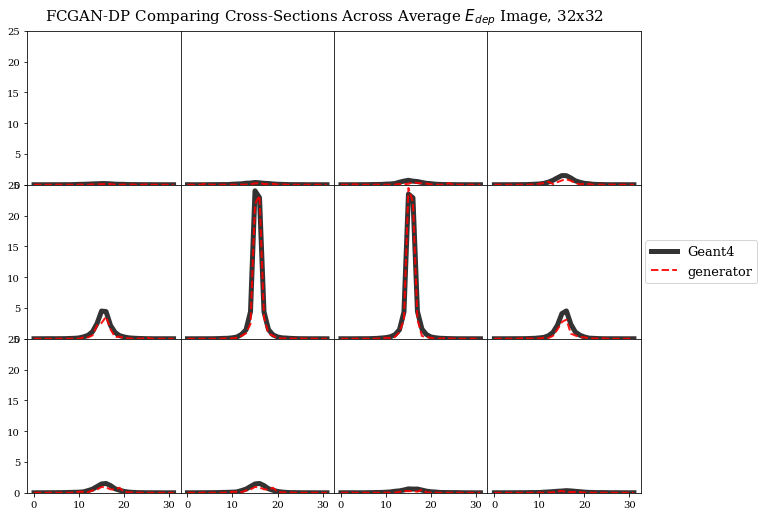

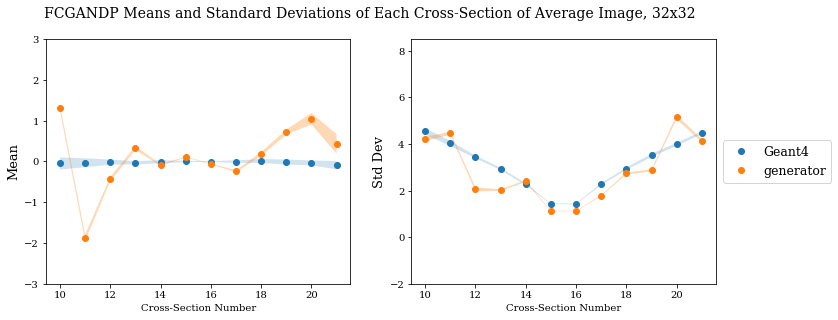

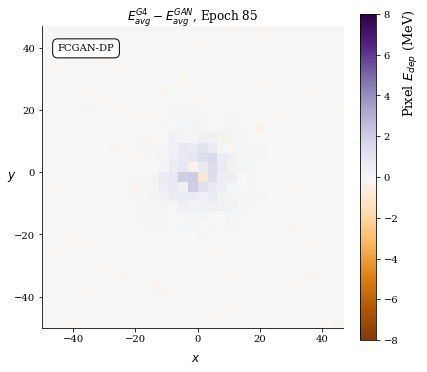

[85/100][0/938] Loss_D: 0.1582 Loss_G: 6.1416 D(x): 0.9328 D(G(z)): 0.0582 / 0.0162
[85/100][100/938] Loss_D: 0.1815 Loss_G: 6.2111 D(x): 0.9242 D(G(z)): 0.0602 / 0.0129
[85/100][200/938] Loss_D: 0.2259 Loss_G: 5.6551 D(x): 0.9347 D(G(z)): 0.0821 / 0.0204
[85/100][300/938] Loss_D: 0.2543 Loss_G: 5.0018 D(x): 0.8849 D(G(z)): 0.0660 / 0.0311
[85/100][400/938] Loss_D: 0.1782 Loss_G: 6.0235 D(x): 0.9891 D(G(z)): 0.1019 / 0.0097
[85/100][500/938] Loss_D: 0.1083 Loss_G: 6.3476 D(x): 0.9579 D(G(z)): 0.0392 / 0.0127
[85/100][600/938] Loss_D: 0.3778 Loss_G: 6.4296 D(x): 0.8361 D(G(z)): 0.0576 / 0.0137
[85/100][700/938] Loss_D: 0.1057 Loss_G: 7.0258 D(x): 0.9542 D(G(z)): 0.0215 / 0.0092
[85/100][800/938] Loss_D: 0.1879 Loss_G: 7.3236 D(x): 0.9136 D(G(z)): 0.0239 / 0.0097
[85/100][900/938] Loss_D: 0.1846 Loss_G: 6.3074 D(x): 0.8942 D(G(z)): 0.0345 / 0.0170
(32, 32)


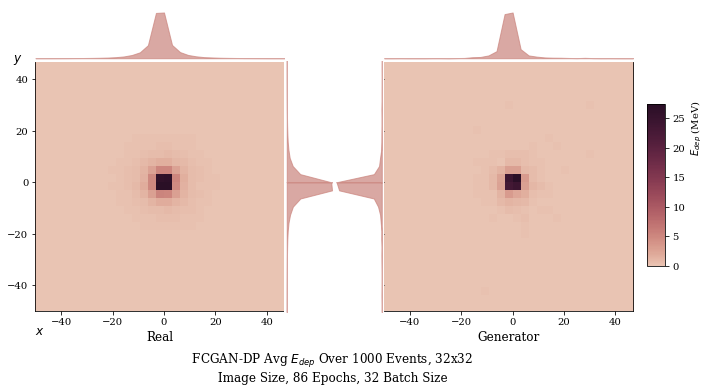

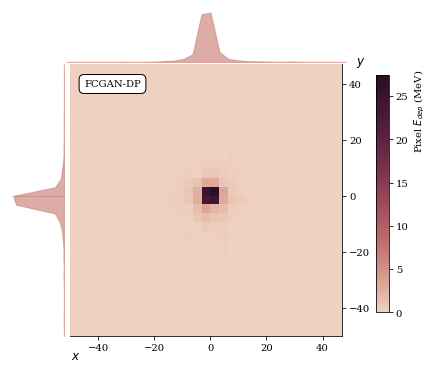

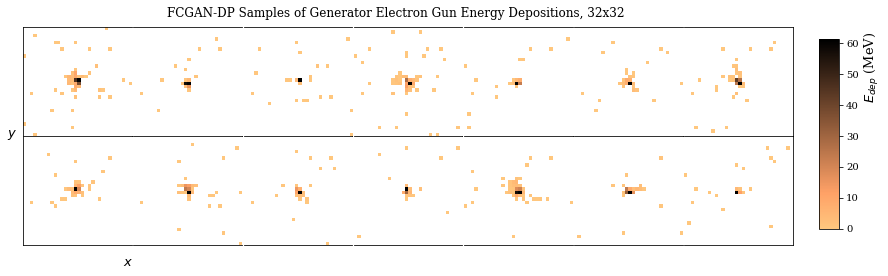

0.15324867 0.1959639795361145
(32,)


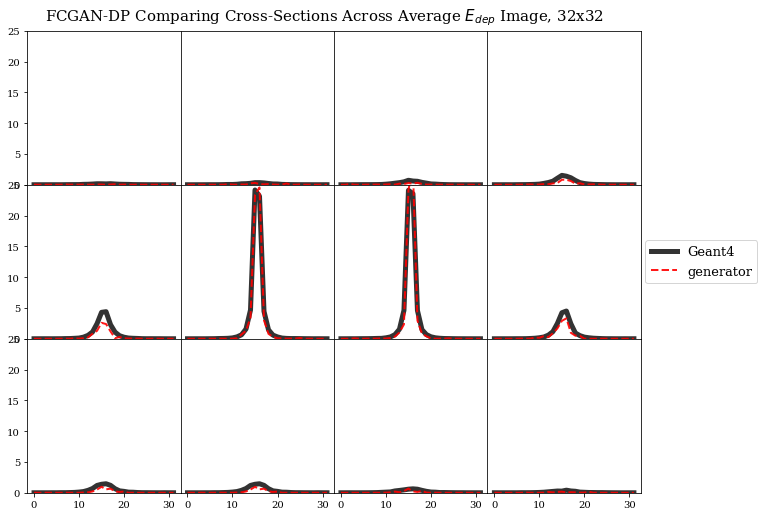

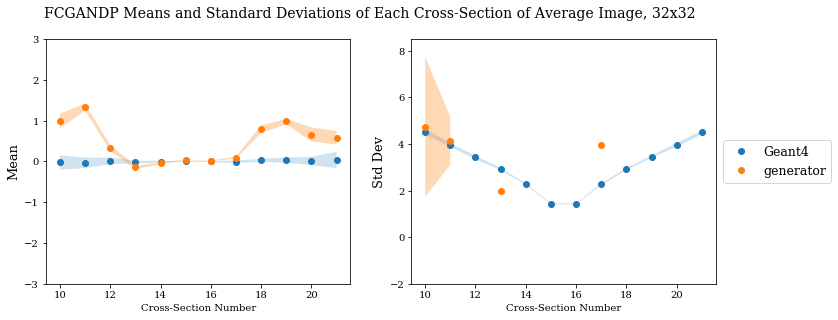

[86/100][0/938] Loss_D: 0.2119 Loss_G: 6.2657 D(x): 0.9585 D(G(z)): 0.0909 / 0.0166
[86/100][100/938] Loss_D: 0.1580 Loss_G: 5.3571 D(x): 0.9426 D(G(z)): 0.0721 / 0.0220
[86/100][200/938] Loss_D: 0.1556 Loss_G: 5.5754 D(x): 0.9343 D(G(z)): 0.0656 / 0.0298
[86/100][300/938] Loss_D: 0.2516 Loss_G: 4.6517 D(x): 0.9051 D(G(z)): 0.0528 / 0.0312
[86/100][400/938] Loss_D: 0.1269 Loss_G: 5.7131 D(x): 0.9856 D(G(z)): 0.0737 / 0.0128
[86/100][500/938] Loss_D: 0.2386 Loss_G: 6.3590 D(x): 0.9583 D(G(z)): 0.1154 / 0.0200
[86/100][600/938] Loss_D: 0.2119 Loss_G: 5.7471 D(x): 0.9406 D(G(z)): 0.0912 / 0.0194
[86/100][700/938] Loss_D: 0.1275 Loss_G: 6.0103 D(x): 0.9346 D(G(z)): 0.0299 / 0.0127
[86/100][800/938] Loss_D: 0.1370 Loss_G: 6.1089 D(x): 0.9683 D(G(z)): 0.0728 / 0.0156
[86/100][900/938] Loss_D: 0.2789 Loss_G: 5.9017 D(x): 0.9055 D(G(z)): 0.0577 / 0.0201
(32, 32)


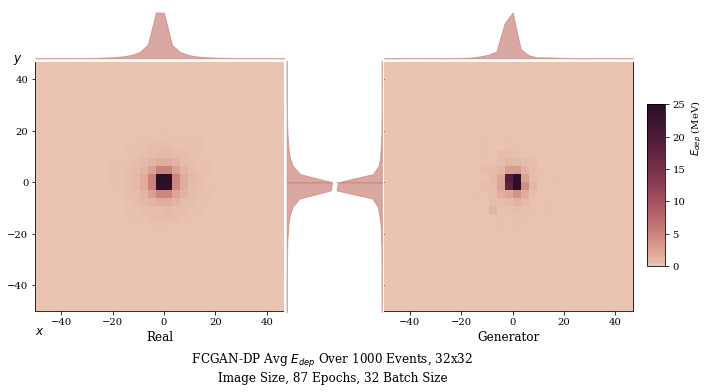

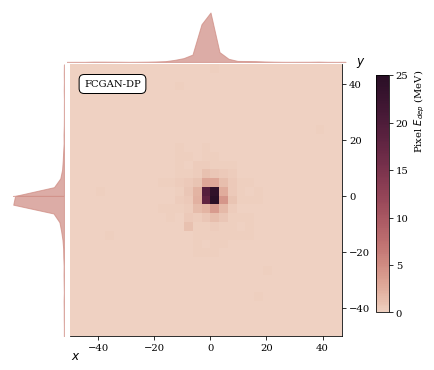

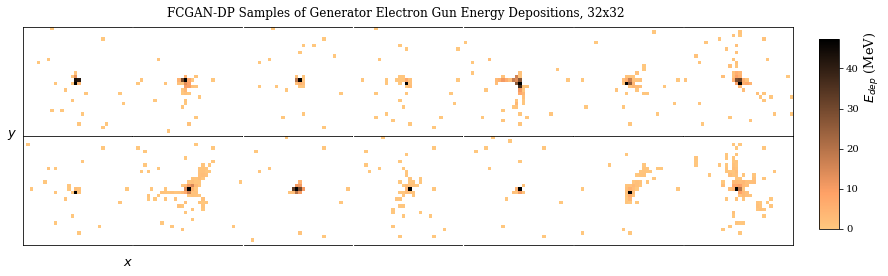

0.14165695 0.19880734253459761
(32,)


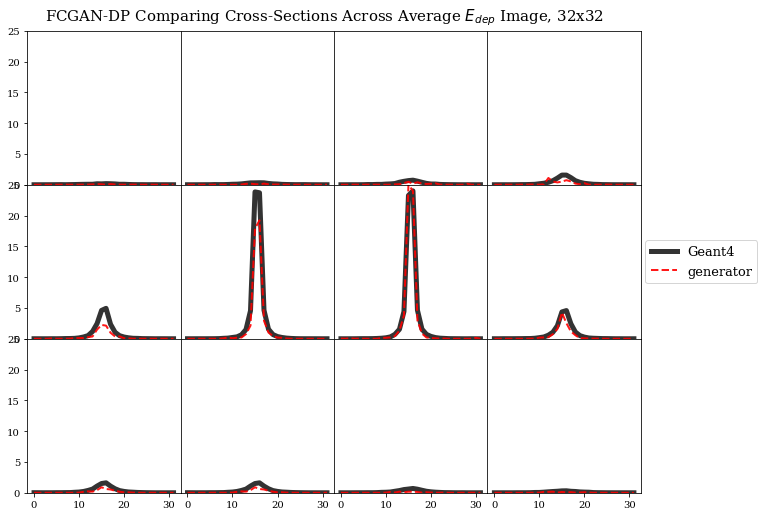

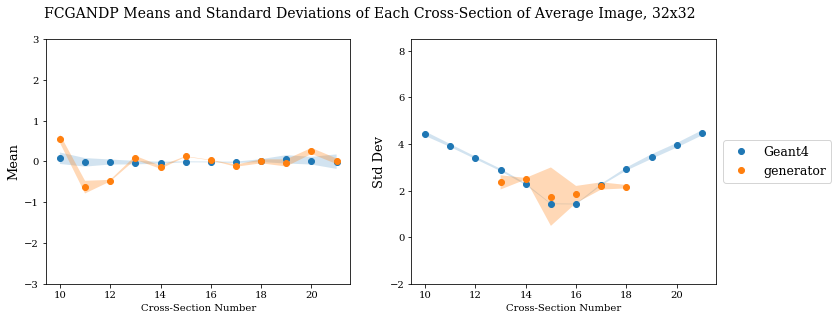

[87/100][0/938] Loss_D: 0.2862 Loss_G: 5.5406 D(x): 0.9701 D(G(z)): 0.1166 / 0.0246
[87/100][100/938] Loss_D: 0.3434 Loss_G: 4.6755 D(x): 0.8854 D(G(z)): 0.0556 / 0.0324
[87/100][200/938] Loss_D: 0.3669 Loss_G: 4.5943 D(x): 0.8593 D(G(z)): 0.0841 / 0.0399
[87/100][300/938] Loss_D: 0.1674 Loss_G: 6.1316 D(x): 0.9390 D(G(z)): 0.0700 / 0.0122
[87/100][400/938] Loss_D: 0.2765 Loss_G: 6.7510 D(x): 0.9549 D(G(z)): 0.0908 / 0.0311
[87/100][500/938] Loss_D: 0.3921 Loss_G: 5.4793 D(x): 0.9238 D(G(z)): 0.0996 / 0.0245
[87/100][600/938] Loss_D: 0.2610 Loss_G: 6.0262 D(x): 0.9338 D(G(z)): 0.0970 / 0.0234
[87/100][700/938] Loss_D: 0.2383 Loss_G: 5.4556 D(x): 0.9560 D(G(z)): 0.1166 / 0.0143
[87/100][800/938] Loss_D: 0.2169 Loss_G: 6.5627 D(x): 0.9378 D(G(z)): 0.0735 / 0.0120
[87/100][900/938] Loss_D: 0.3412 Loss_G: 5.4776 D(x): 0.9173 D(G(z)): 0.0856 / 0.0152
(32, 32)


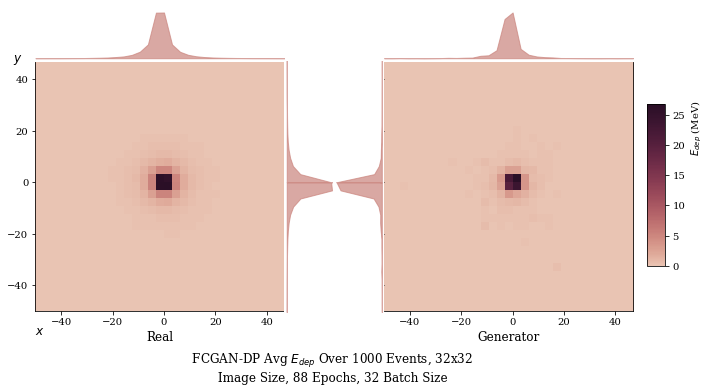

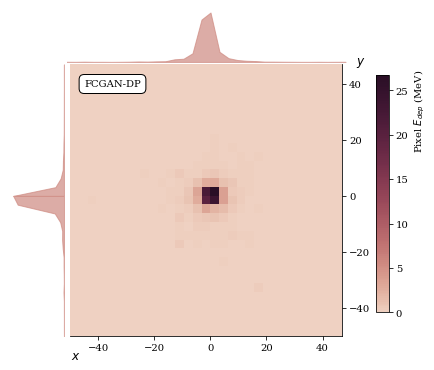

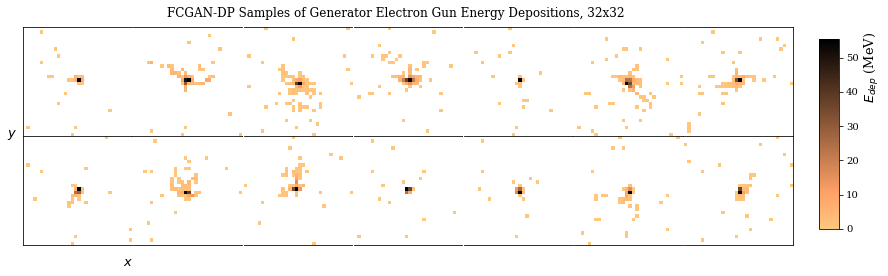

0.14937687 0.19643135930019542
(32,)


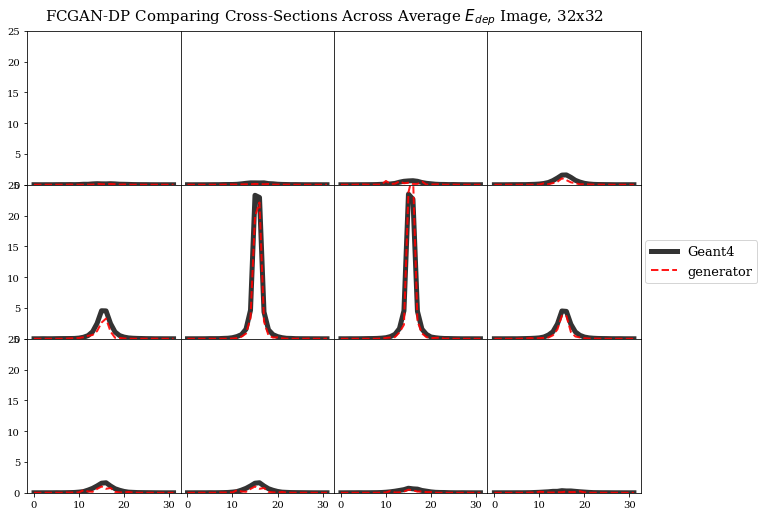

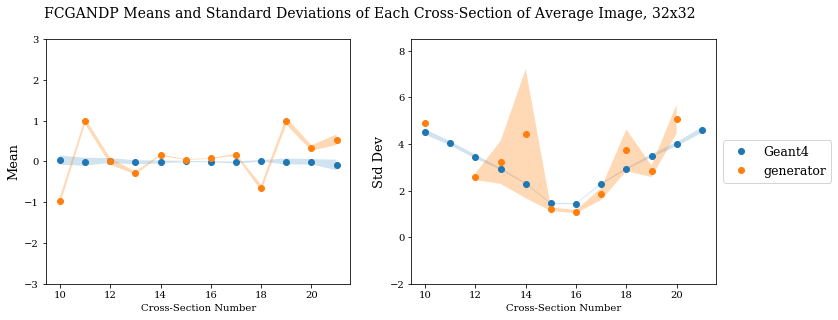

[88/100][0/938] Loss_D: 0.1427 Loss_G: 5.5206 D(x): 0.9589 D(G(z)): 0.0780 / 0.0246
[88/100][100/938] Loss_D: 0.1617 Loss_G: 5.7592 D(x): 0.9407 D(G(z)): 0.0553 / 0.0154
[88/100][200/938] Loss_D: 0.3318 Loss_G: 5.7823 D(x): 0.9713 D(G(z)): 0.1590 / 0.0123
[88/100][300/938] Loss_D: 0.3333 Loss_G: 5.7937 D(x): 0.8959 D(G(z)): 0.0583 / 0.0151
[88/100][400/938] Loss_D: 0.2230 Loss_G: 6.1853 D(x): 0.9060 D(G(z)): 0.0120 / 0.0115
[88/100][500/938] Loss_D: 0.1499 Loss_G: 6.4696 D(x): 0.9328 D(G(z)): 0.0323 / 0.0152
[88/100][600/938] Loss_D: 0.2249 Loss_G: 5.3693 D(x): 0.9233 D(G(z)): 0.0839 / 0.0200
[88/100][700/938] Loss_D: 0.1594 Loss_G: 5.7829 D(x): 0.9567 D(G(z)): 0.0549 / 0.0296
[88/100][800/938] Loss_D: 0.1028 Loss_G: 6.0843 D(x): 0.9803 D(G(z)): 0.0579 / 0.0134
[88/100][900/938] Loss_D: 0.1042 Loss_G: 6.7577 D(x): 0.9727 D(G(z)): 0.0556 / 0.0091
(32, 32)


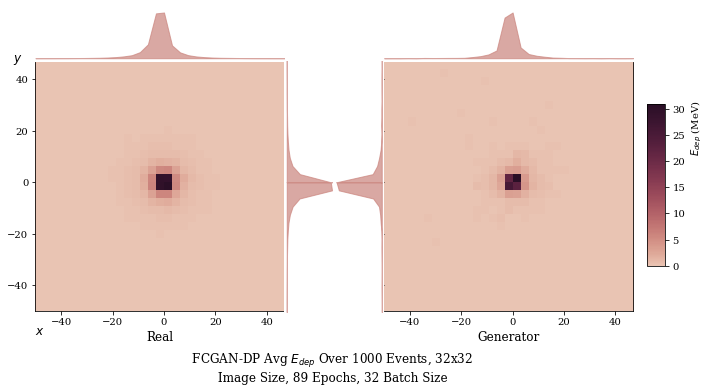

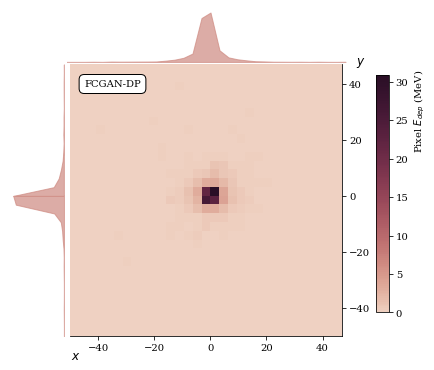

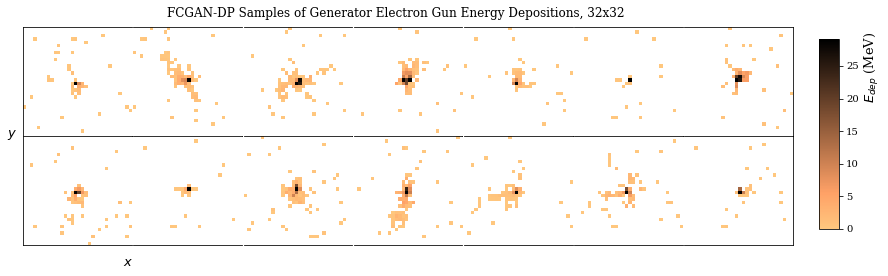

0.17120148 0.19249065095093973
(32,)


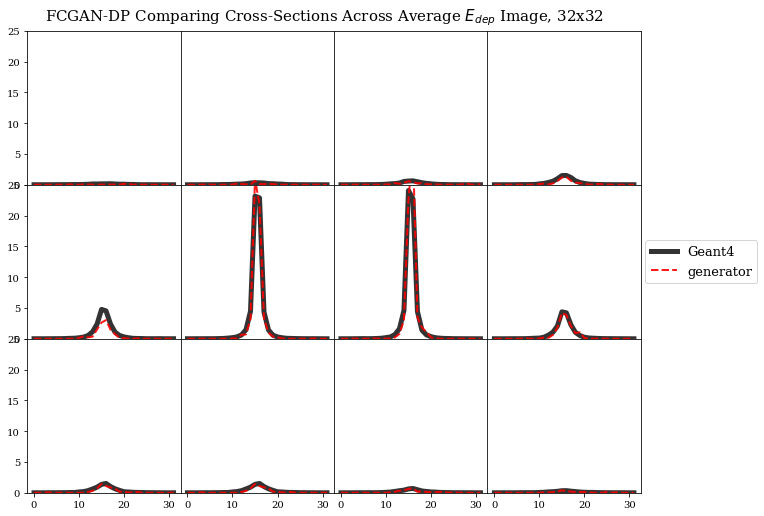

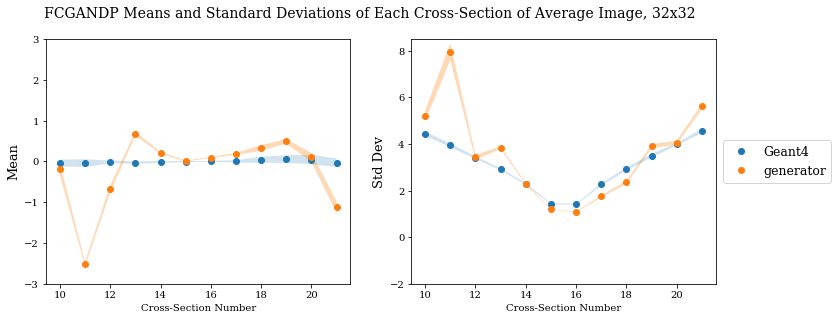

[89/100][0/938] Loss_D: 0.0461 Loss_G: 7.2880 D(x): 0.9814 D(G(z)): 0.0225 / 0.0059
[89/100][100/938] Loss_D: 0.1641 Loss_G: 5.6319 D(x): 0.9420 D(G(z)): 0.0605 / 0.0182
[89/100][200/938] Loss_D: 0.3459 Loss_G: 6.3641 D(x): 0.9736 D(G(z)): 0.1422 / 0.0385
[89/100][300/938] Loss_D: 0.1973 Loss_G: 6.2313 D(x): 0.9208 D(G(z)): 0.0489 / 0.0114
[89/100][400/938] Loss_D: 0.0895 Loss_G: 6.7023 D(x): 0.9873 D(G(z)): 0.0379 / 0.0053
[89/100][500/938] Loss_D: 0.1671 Loss_G: 7.1574 D(x): 0.9260 D(G(z)): 0.0275 / 0.0162
[89/100][600/938] Loss_D: 0.2480 Loss_G: 6.4517 D(x): 0.9105 D(G(z)): 0.0831 / 0.0118
[89/100][700/938] Loss_D: 0.0985 Loss_G: 6.3164 D(x): 0.9499 D(G(z)): 0.0360 / 0.0079
[89/100][800/938] Loss_D: 0.2329 Loss_G: 6.3510 D(x): 0.9106 D(G(z)): 0.0687 / 0.0151
[89/100][900/938] Loss_D: 0.1169 Loss_G: 5.7944 D(x): 0.9465 D(G(z)): 0.0489 / 0.0116
(32, 32)


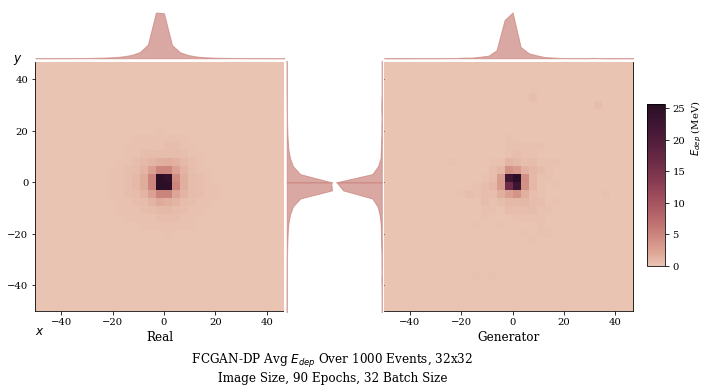

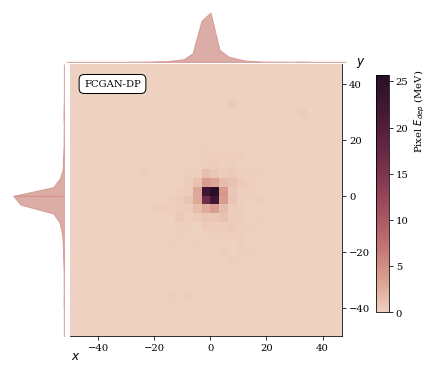

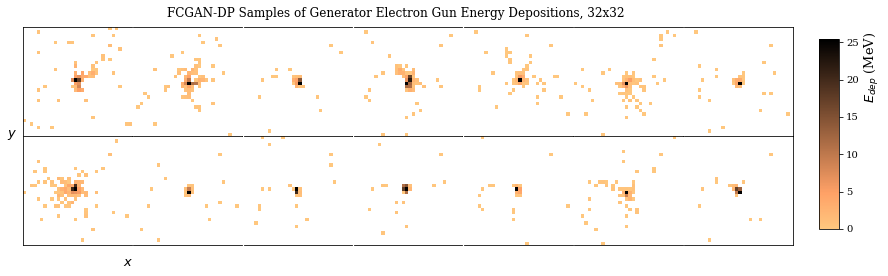

0.15066984 0.1934898248116923
(32,)


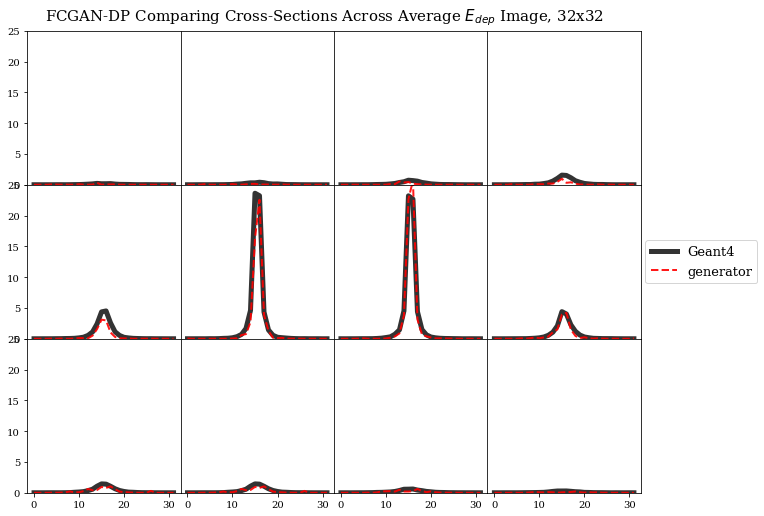

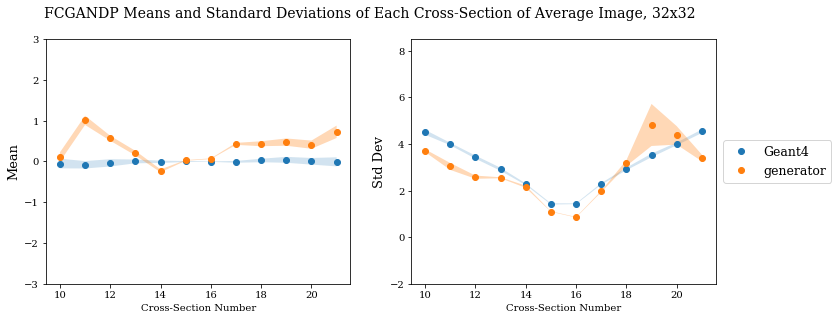

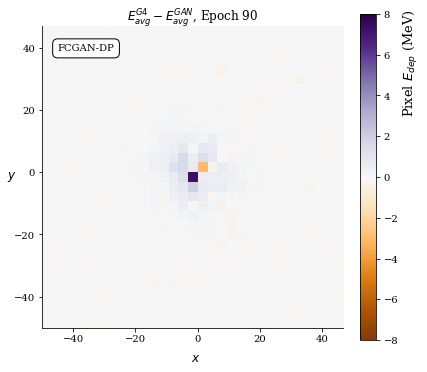

[90/100][0/938] Loss_D: 0.1466 Loss_G: 5.1692 D(x): 0.9749 D(G(z)): 0.0897 / 0.0175
[90/100][100/938] Loss_D: 0.2726 Loss_G: 5.7768 D(x): 0.9281 D(G(z)): 0.0765 / 0.0166
[90/100][200/938] Loss_D: 0.1817 Loss_G: 5.7088 D(x): 0.9366 D(G(z)): 0.0599 / 0.0166
[90/100][300/938] Loss_D: 0.3272 Loss_G: 6.8125 D(x): 0.9532 D(G(z)): 0.0705 / 0.0080
[90/100][400/938] Loss_D: 0.2909 Loss_G: 6.0134 D(x): 0.9385 D(G(z)): 0.0827 / 0.0194
[90/100][500/938] Loss_D: 0.2129 Loss_G: 6.5229 D(x): 0.9730 D(G(z)): 0.0827 / 0.0196
[90/100][600/938] Loss_D: 0.3178 Loss_G: 5.7707 D(x): 0.8728 D(G(z)): 0.0805 / 0.0181
[90/100][700/938] Loss_D: 0.3662 Loss_G: 5.7463 D(x): 0.9175 D(G(z)): 0.1091 / 0.0175
[90/100][800/938] Loss_D: 0.1003 Loss_G: 6.9988 D(x): 0.9373 D(G(z)): 0.0188 / 0.0094
[90/100][900/938] Loss_D: 0.1101 Loss_G: 5.2737 D(x): 0.9637 D(G(z)): 0.0534 / 0.0177
(32, 32)


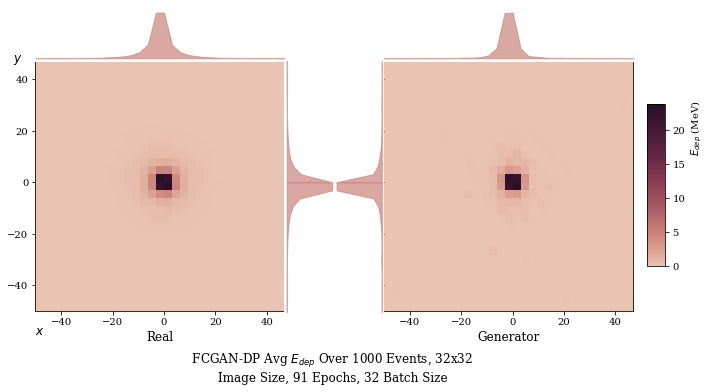

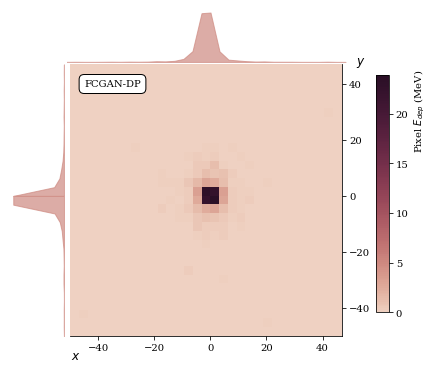

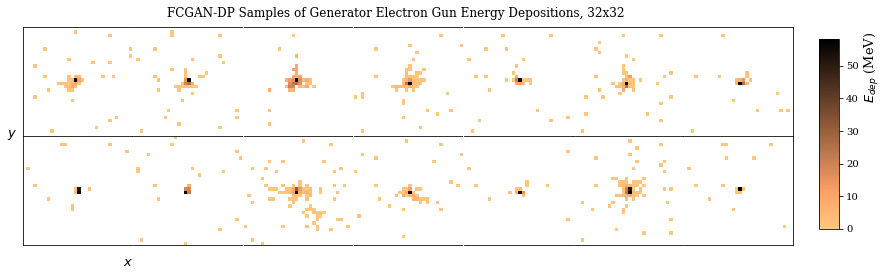

0.14735612 0.19818997976178343
(32,)


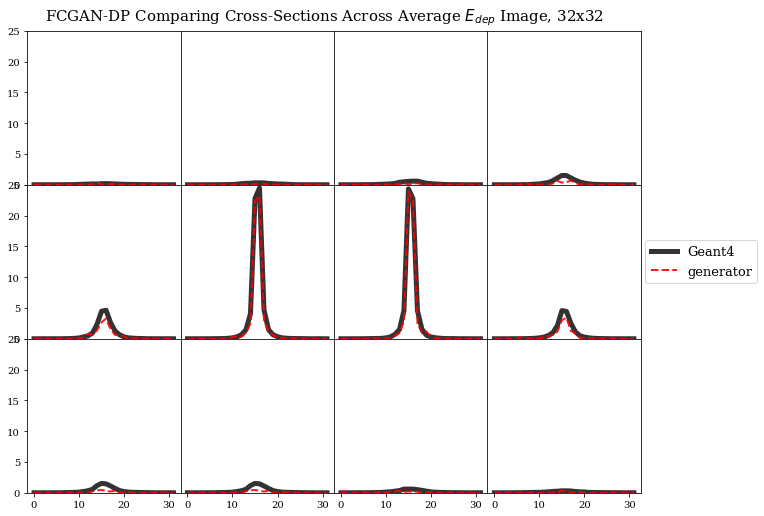

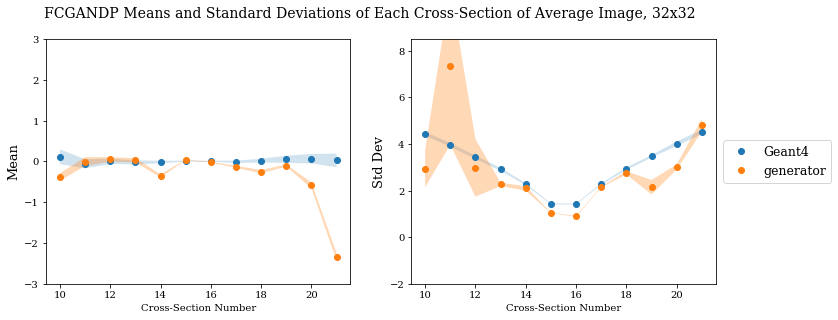

[91/100][0/938] Loss_D: 0.2709 Loss_G: 6.9665 D(x): 0.9732 D(G(z)): 0.1241 / 0.0111
[91/100][100/938] Loss_D: 0.4402 Loss_G: 5.4845 D(x): 0.8717 D(G(z)): 0.0935 / 0.0129
[91/100][200/938] Loss_D: 0.2679 Loss_G: 5.8459 D(x): 0.9601 D(G(z)): 0.0971 / 0.0137
[91/100][300/938] Loss_D: 0.3153 Loss_G: 6.3521 D(x): 0.9046 D(G(z)): 0.0433 / 0.0095
[91/100][400/938] Loss_D: 0.2473 Loss_G: 7.1033 D(x): 0.9841 D(G(z)): 0.0727 / 0.0255
[91/100][500/938] Loss_D: 0.1530 Loss_G: 6.9747 D(x): 0.9495 D(G(z)): 0.0333 / 0.0122
[91/100][600/938] Loss_D: 0.2994 Loss_G: 7.1567 D(x): 0.9236 D(G(z)): 0.1028 / 0.0082
[91/100][700/938] Loss_D: 0.1602 Loss_G: 6.6619 D(x): 0.9396 D(G(z)): 0.0525 / 0.0216
[91/100][800/938] Loss_D: 0.2196 Loss_G: 6.3917 D(x): 0.9322 D(G(z)): 0.0247 / 0.0108
[91/100][900/938] Loss_D: 0.2306 Loss_G: 7.2312 D(x): 0.9411 D(G(z)): 0.0510 / 0.0051
(32, 32)


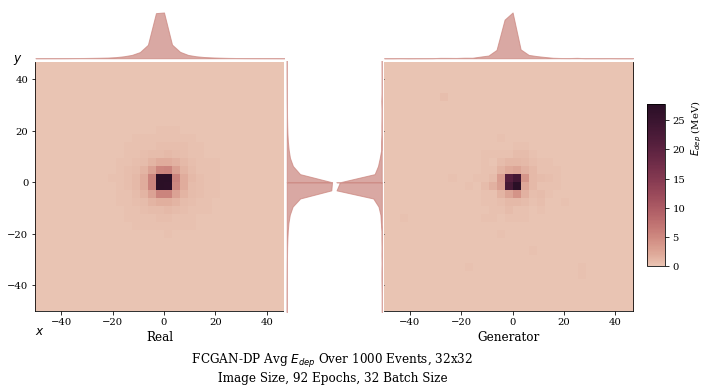

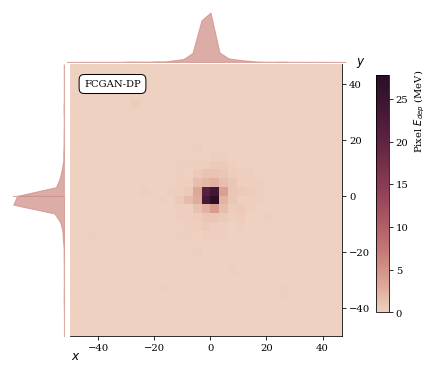

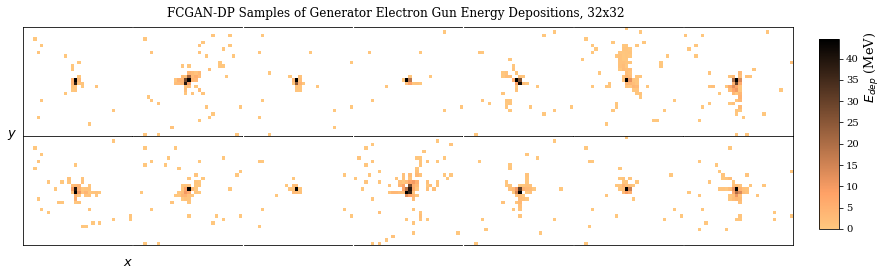

0.15380147 0.19849736680889013
(32,)


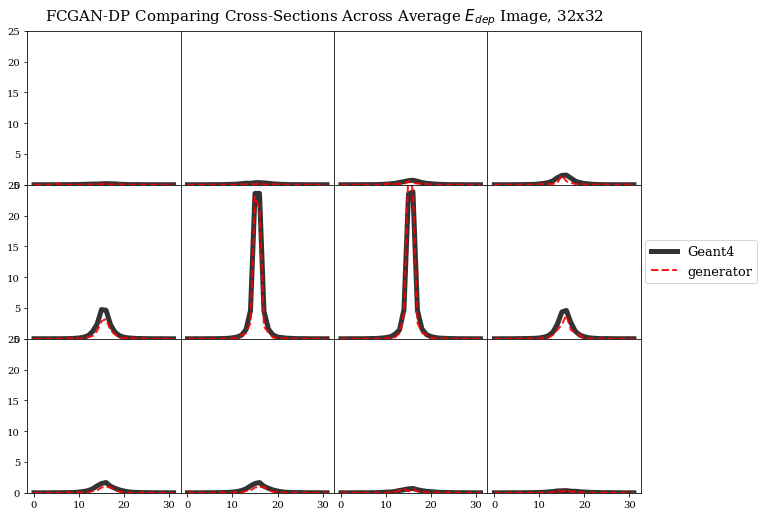

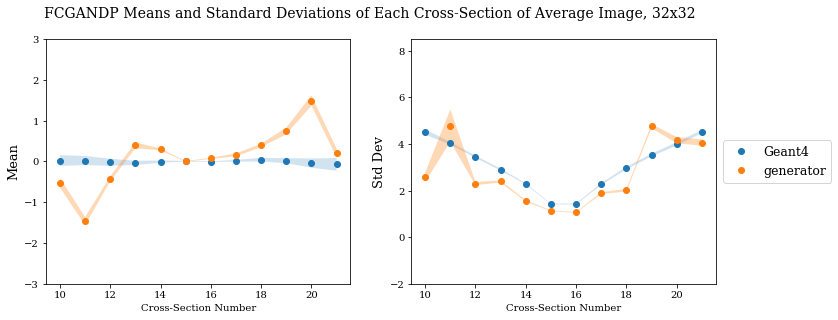

[92/100][0/938] Loss_D: 0.0691 Loss_G: 6.8850 D(x): 0.9479 D(G(z)): 0.0093 / 0.0083
[92/100][100/938] Loss_D: 0.0977 Loss_G: 7.7192 D(x): 0.9546 D(G(z)): 0.0318 / 0.0083
[92/100][200/938] Loss_D: 0.0676 Loss_G: 5.8050 D(x): 0.9807 D(G(z)): 0.0343 / 0.0111
[92/100][300/938] Loss_D: 0.1516 Loss_G: 6.0391 D(x): 0.9511 D(G(z)): 0.0534 / 0.0142
[92/100][400/938] Loss_D: 0.1106 Loss_G: 7.7249 D(x): 0.9370 D(G(z)): 0.0095 / 0.0062
[92/100][500/938] Loss_D: 0.1250 Loss_G: 6.6552 D(x): 0.9577 D(G(z)): 0.0291 / 0.0092
[92/100][600/938] Loss_D: 0.2360 Loss_G: 5.4871 D(x): 0.8741 D(G(z)): 0.0395 / 0.0233
[92/100][700/938] Loss_D: 0.0698 Loss_G: 7.7926 D(x): 0.9589 D(G(z)): 0.0195 / 0.0074
[92/100][800/938] Loss_D: 0.1559 Loss_G: 6.9668 D(x): 0.9759 D(G(z)): 0.0863 / 0.0101
[92/100][900/938] Loss_D: 0.1749 Loss_G: 7.1589 D(x): 0.9446 D(G(z)): 0.0490 / 0.0074
(32, 32)


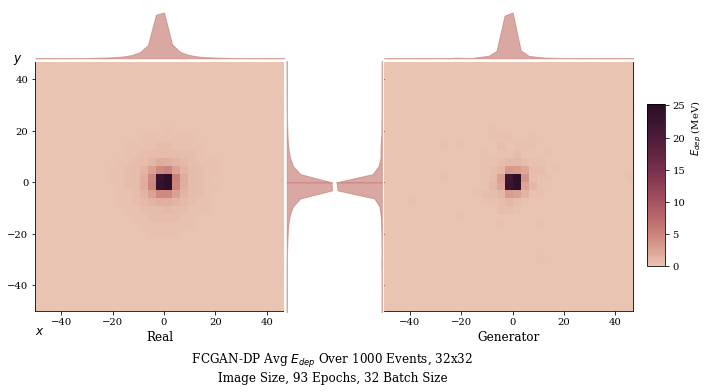

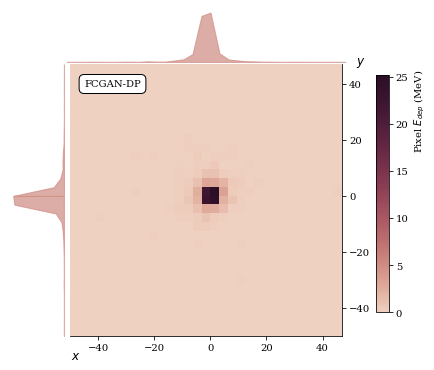

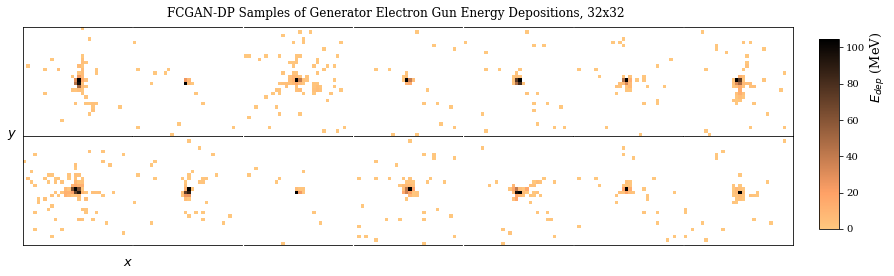

0.14257345 0.19778440335937203
(32,)


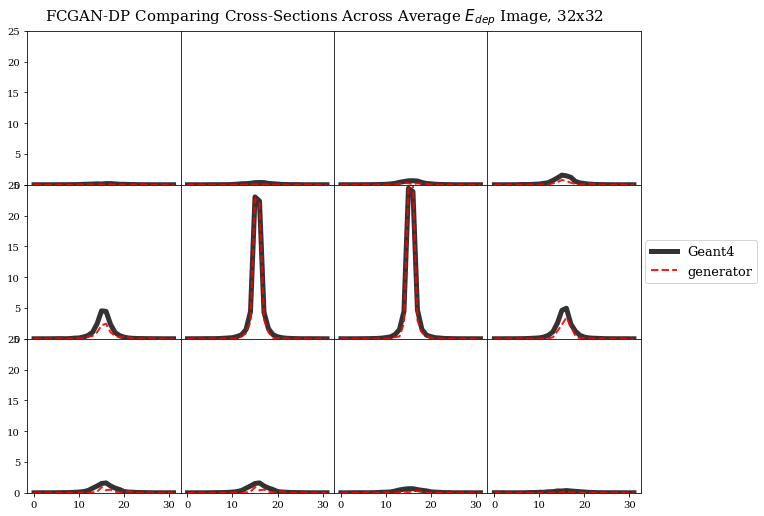

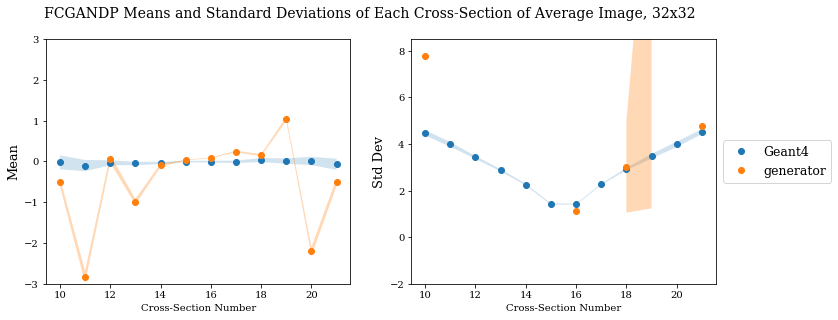

[93/100][0/938] Loss_D: 0.2143 Loss_G: 5.9564 D(x): 0.9871 D(G(z)): 0.0736 / 0.0178
[93/100][100/938] Loss_D: 0.3334 Loss_G: 7.4412 D(x): 0.8879 D(G(z)): 0.0883 / 0.0057
[93/100][200/938] Loss_D: 0.2394 Loss_G: 5.6294 D(x): 0.9878 D(G(z)): 0.0945 / 0.0216
[93/100][300/938] Loss_D: 0.3281 Loss_G: 5.0090 D(x): 0.9075 D(G(z)): 0.0569 / 0.0218
[93/100][400/938] Loss_D: 0.1686 Loss_G: 7.1831 D(x): 0.9795 D(G(z)): 0.0831 / 0.0064
[93/100][500/938] Loss_D: 0.1328 Loss_G: 7.1417 D(x): 0.9288 D(G(z)): 0.0237 / 0.0091
[93/100][600/938] Loss_D: 0.1461 Loss_G: 6.6630 D(x): 0.9527 D(G(z)): 0.0578 / 0.0119
[93/100][700/938] Loss_D: 0.1564 Loss_G: 7.4652 D(x): 0.9443 D(G(z)): 0.0581 / 0.0148
[93/100][800/938] Loss_D: 0.1248 Loss_G: 6.4403 D(x): 0.9581 D(G(z)): 0.0453 / 0.0066
[93/100][900/938] Loss_D: 0.2402 Loss_G: 5.6317 D(x): 0.9322 D(G(z)): 0.0443 / 0.0311
(32, 32)


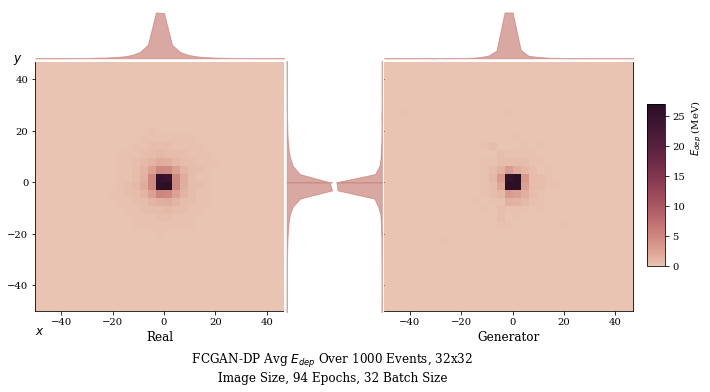

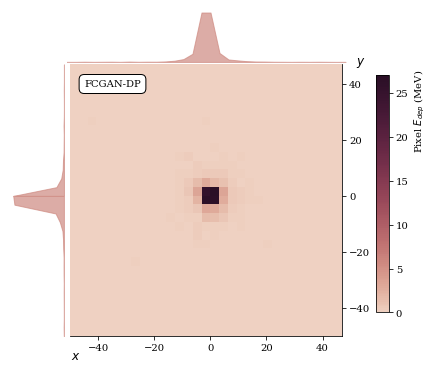

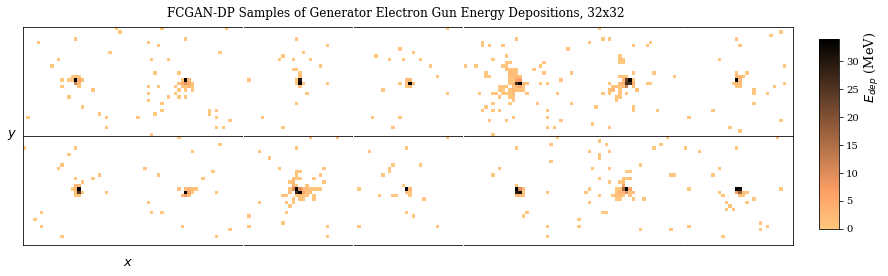

0.15643221 0.192553064305984
(32,)


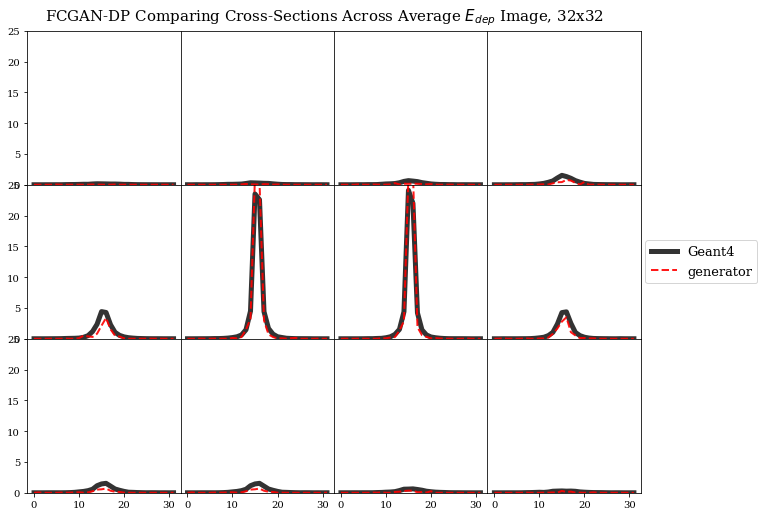

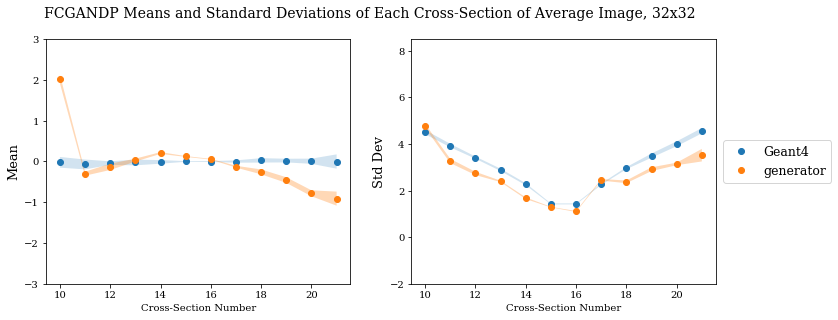

[94/100][0/938] Loss_D: 0.3393 Loss_G: 6.2970 D(x): 0.9427 D(G(z)): 0.0743 / 0.0102
[94/100][100/938] Loss_D: 0.0738 Loss_G: 6.6424 D(x): 0.9591 D(G(z)): 0.0204 / 0.0080
[94/100][200/938] Loss_D: 0.0884 Loss_G: 5.3748 D(x): 0.9723 D(G(z)): 0.0469 / 0.0197
[94/100][300/938] Loss_D: 0.1708 Loss_G: 8.2659 D(x): 0.9426 D(G(z)): 0.0302 / 0.0051
[94/100][400/938] Loss_D: 0.3786 Loss_G: 6.9755 D(x): 0.9928 D(G(z)): 0.1143 / 0.0174
[94/100][500/938] Loss_D: 0.0925 Loss_G: 5.7943 D(x): 0.9675 D(G(z)): 0.0463 / 0.0127
[94/100][600/938] Loss_D: 0.3869 Loss_G: 6.6665 D(x): 0.8650 D(G(z)): 0.0534 / 0.0098
[94/100][700/938] Loss_D: 0.0856 Loss_G: 5.8738 D(x): 0.9712 D(G(z)): 0.0375 / 0.0095
[94/100][800/938] Loss_D: 0.1114 Loss_G: 5.9557 D(x): 0.9760 D(G(z)): 0.0501 / 0.0089
[94/100][900/938] Loss_D: 0.1219 Loss_G: 6.3682 D(x): 0.9270 D(G(z)): 0.0246 / 0.0120
(32, 32)


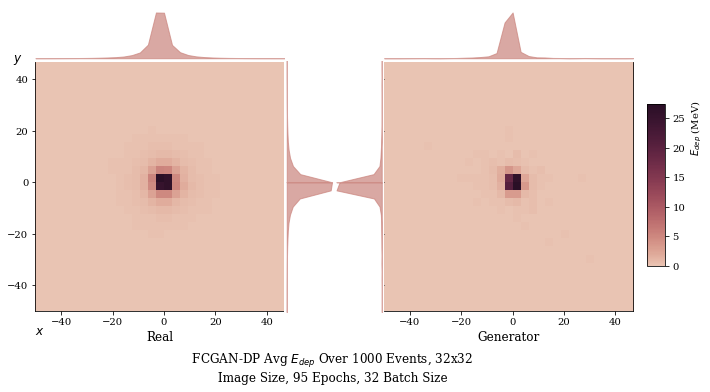

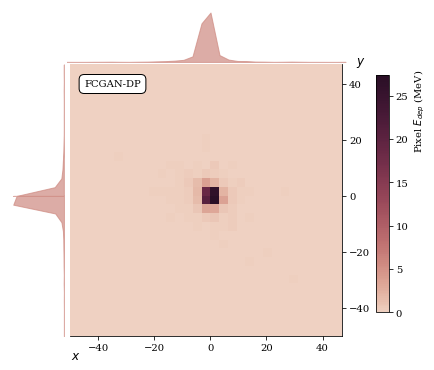

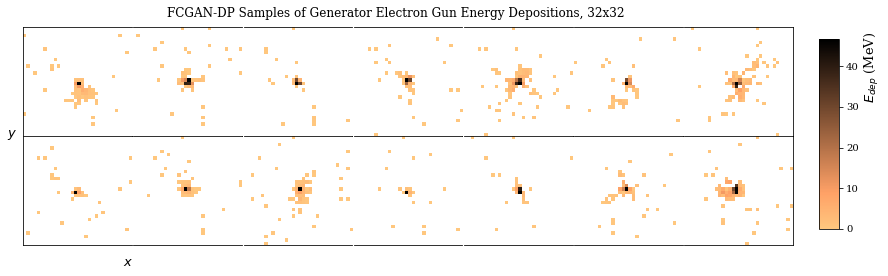

0.13626768 0.19619784445122265
(32,)


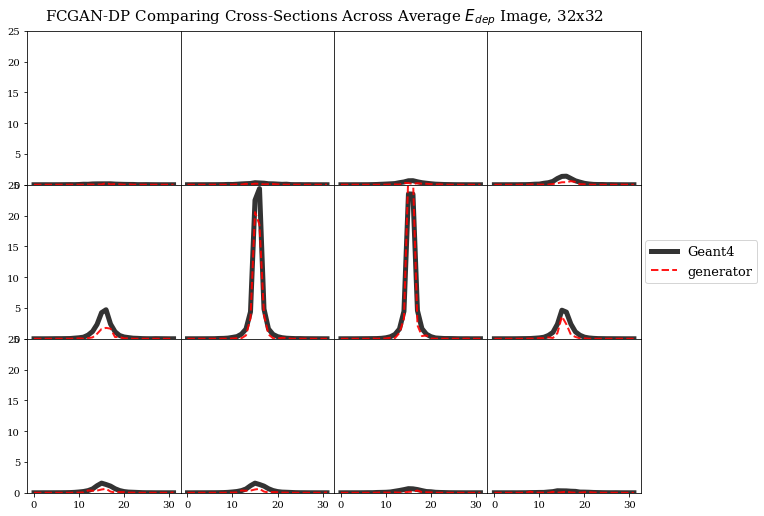

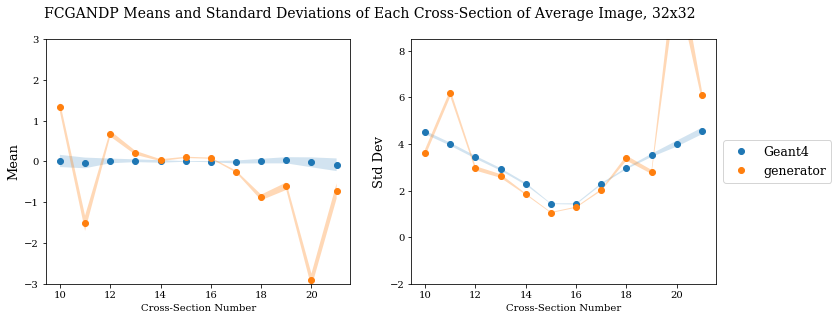

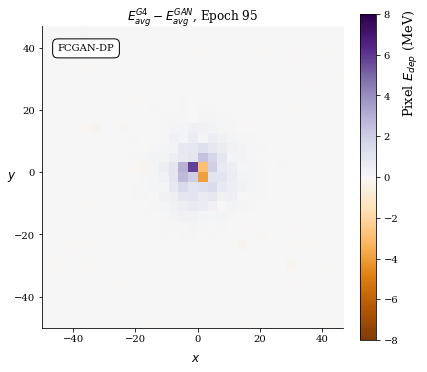

[95/100][0/938] Loss_D: 0.1463 Loss_G: 6.2015 D(x): 0.9679 D(G(z)): 0.0718 / 0.0127
[95/100][100/938] Loss_D: 0.1525 Loss_G: 7.0774 D(x): 0.9444 D(G(z)): 0.0427 / 0.0047
[95/100][200/938] Loss_D: 0.1536 Loss_G: 6.0303 D(x): 0.9694 D(G(z)): 0.0875 / 0.0142
[95/100][300/938] Loss_D: 0.2973 Loss_G: 5.7909 D(x): 0.8731 D(G(z)): 0.0157 / 0.0147
[95/100][400/938] Loss_D: 0.3710 Loss_G: 5.9943 D(x): 0.9905 D(G(z)): 0.0912 / 0.0325
[95/100][500/938] Loss_D: 0.2276 Loss_G: 6.4593 D(x): 0.9037 D(G(z)): 0.0147 / 0.0127
[95/100][600/938] Loss_D: 0.5375 Loss_G: 6.4689 D(x): 0.9486 D(G(z)): 0.2087 / 0.0098
[95/100][700/938] Loss_D: 0.2483 Loss_G: 6.9755 D(x): 0.9397 D(G(z)): 0.0559 / 0.0113
[95/100][800/938] Loss_D: 0.2118 Loss_G: 5.6011 D(x): 0.9587 D(G(z)): 0.1113 / 0.0156
[95/100][900/938] Loss_D: 0.1702 Loss_G: 6.9739 D(x): 0.9114 D(G(z)): 0.0384 / 0.0123
(32, 32)


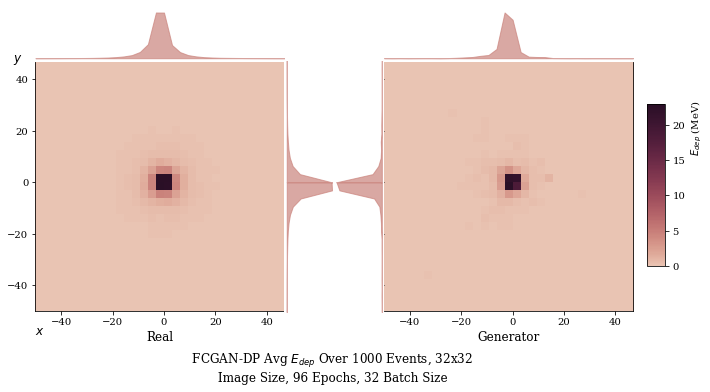

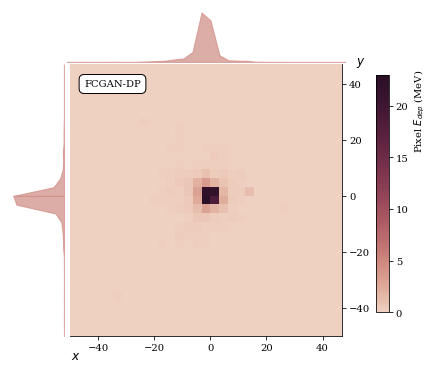

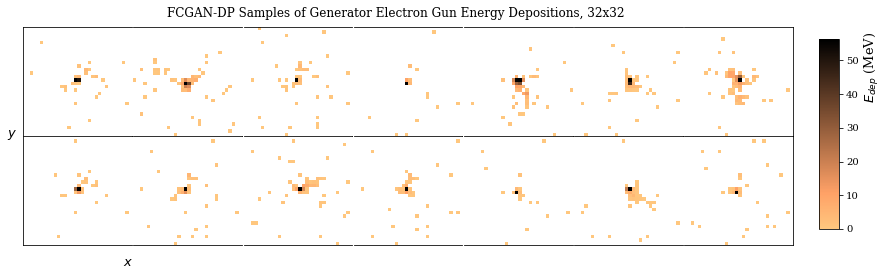

0.13131693 0.1975091536558573
(32,)


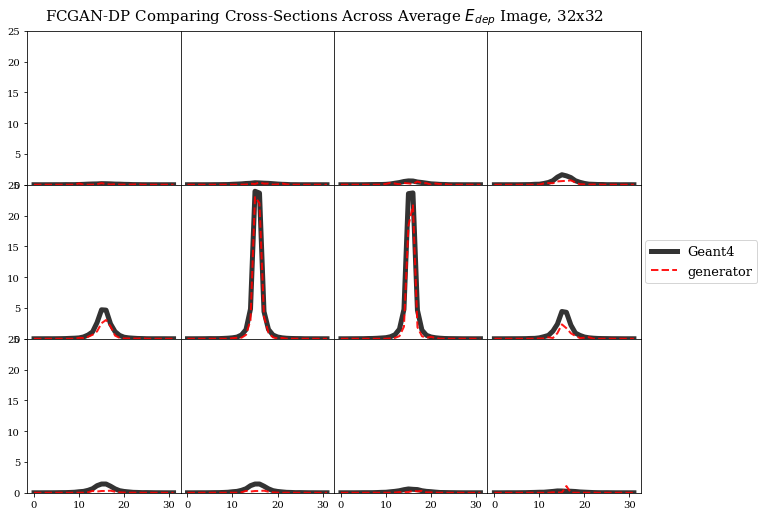

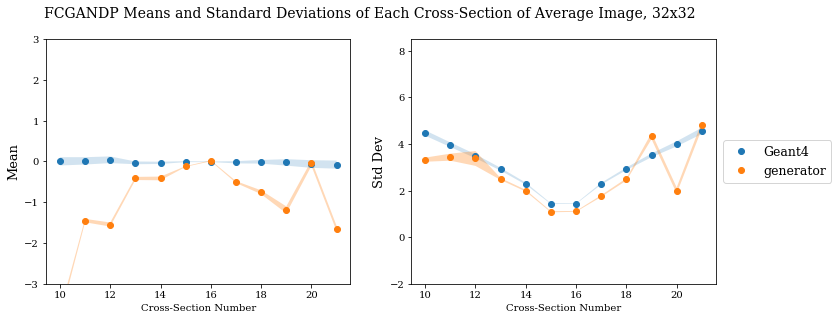

[96/100][0/938] Loss_D: 0.1389 Loss_G: 7.9524 D(x): 0.9733 D(G(z)): 0.0499 / 0.0045
[96/100][100/938] Loss_D: 0.2859 Loss_G: 6.4327 D(x): 0.8910 D(G(z)): 0.0443 / 0.0085
[96/100][200/938] Loss_D: 0.3333 Loss_G: 6.2438 D(x): 0.9470 D(G(z)): 0.1184 / 0.0088
[96/100][300/938] Loss_D: 0.2197 Loss_G: 5.9308 D(x): 0.9018 D(G(z)): 0.0122 / 0.0194
[96/100][400/938] Loss_D: 0.1198 Loss_G: 6.8666 D(x): 0.9574 D(G(z)): 0.0507 / 0.0097
[96/100][500/938] Loss_D: 0.1287 Loss_G: 6.1191 D(x): 0.9613 D(G(z)): 0.0578 / 0.0203
[96/100][600/938] Loss_D: 0.1486 Loss_G: 6.0353 D(x): 0.9092 D(G(z)): 0.0105 / 0.0107
[96/100][700/938] Loss_D: 0.1017 Loss_G: 5.8311 D(x): 0.9592 D(G(z)): 0.0305 / 0.0108
[96/100][800/938] Loss_D: 0.0790 Loss_G: 6.2446 D(x): 0.9851 D(G(z)): 0.0512 / 0.0130
[96/100][900/938] Loss_D: 0.4610 Loss_G: 6.5297 D(x): 0.8968 D(G(z)): 0.1053 / 0.0094
(32, 32)


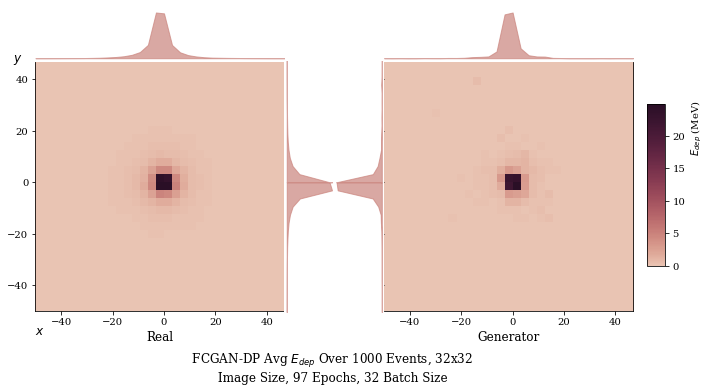

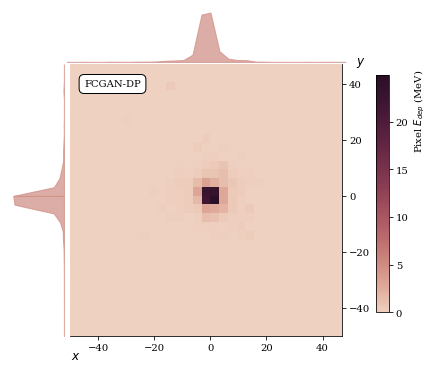

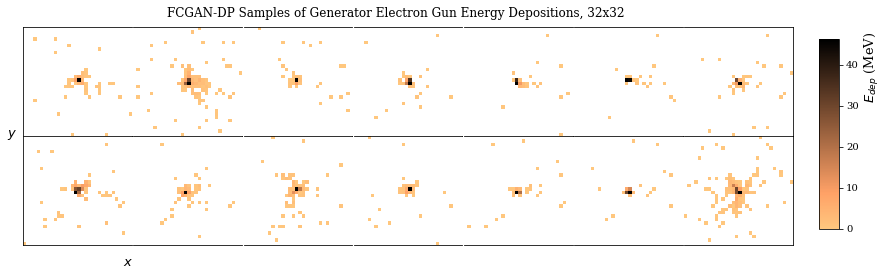

0.14481662 0.1968774422286842
(32,)


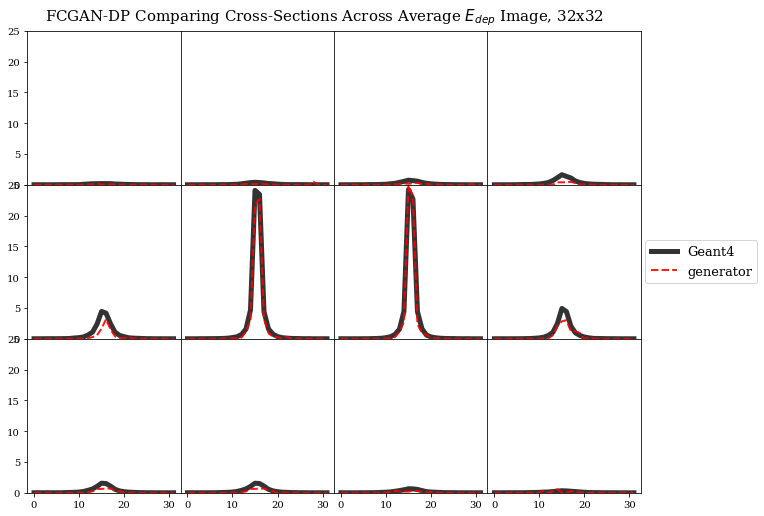

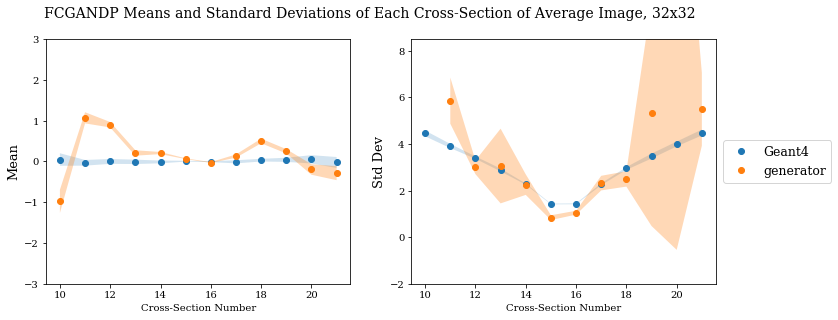

[97/100][0/938] Loss_D: 0.1730 Loss_G: 6.1893 D(x): 0.9631 D(G(z)): 0.0442 / 0.0124
[97/100][100/938] Loss_D: 0.3722 Loss_G: 5.9442 D(x): 0.9060 D(G(z)): 0.0523 / 0.0081
[97/100][200/938] Loss_D: 0.0920 Loss_G: 5.8071 D(x): 0.9785 D(G(z)): 0.0525 / 0.0105
[97/100][300/938] Loss_D: 0.3812 Loss_G: 5.6076 D(x): 0.9490 D(G(z)): 0.0518 / 0.0287
[97/100][400/938] Loss_D: 0.1195 Loss_G: 5.6130 D(x): 0.9571 D(G(z)): 0.0519 / 0.0129
[97/100][500/938] Loss_D: 0.1003 Loss_G: 5.6757 D(x): 0.9769 D(G(z)): 0.0545 / 0.0104
[97/100][600/938] Loss_D: 0.2488 Loss_G: 6.9880 D(x): 0.9173 D(G(z)): 0.0825 / 0.0169
[97/100][700/938] Loss_D: 0.1046 Loss_G: 5.8407 D(x): 0.9390 D(G(z)): 0.0202 / 0.0106
[97/100][800/938] Loss_D: 0.3015 Loss_G: 7.4352 D(x): 0.8810 D(G(z)): 0.0492 / 0.0061
[97/100][900/938] Loss_D: 0.1713 Loss_G: 6.3564 D(x): 0.9033 D(G(z)): 0.0193 / 0.0147
(32, 32)


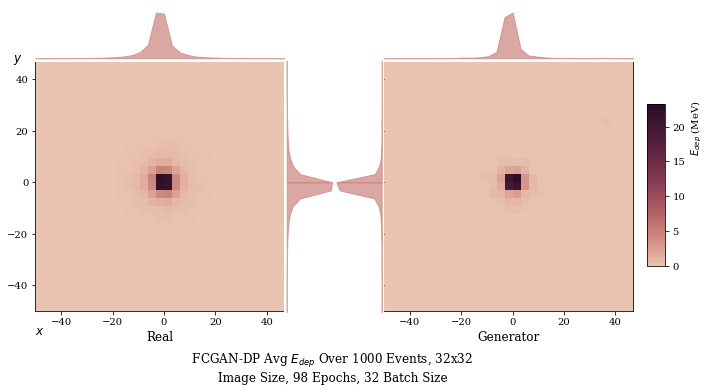

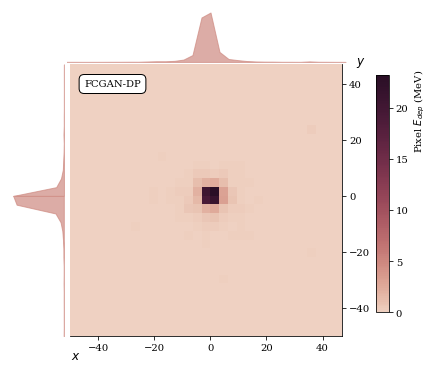

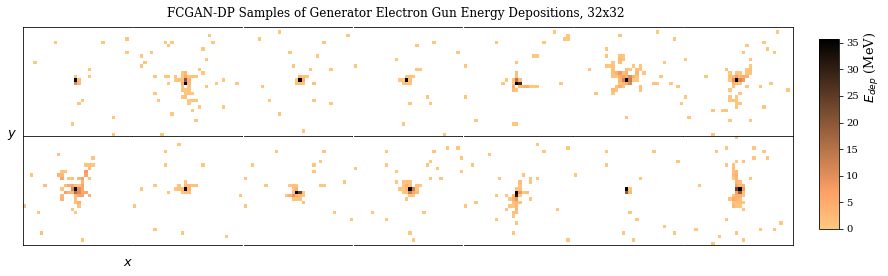

0.1258802 0.19747103752449155
(32,)


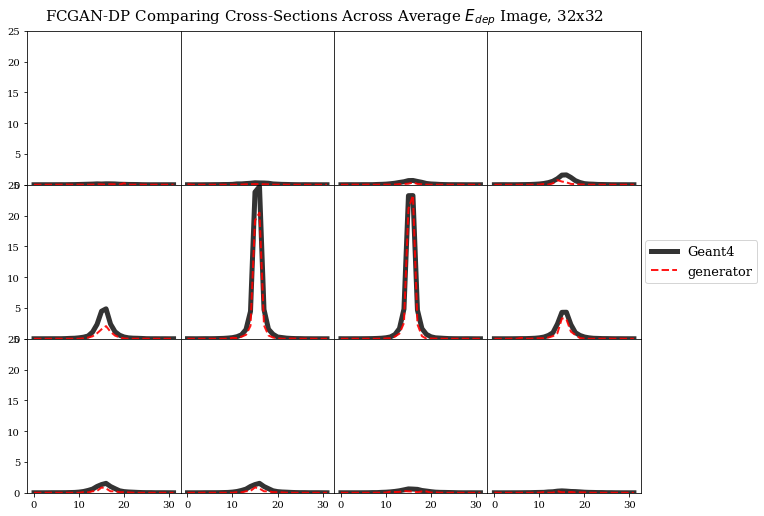

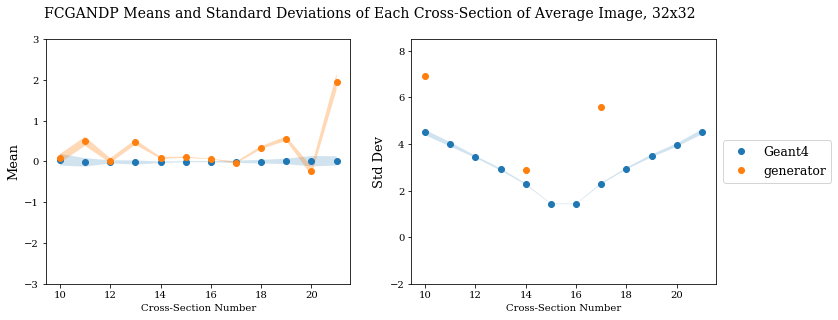

[98/100][0/938] Loss_D: 0.1952 Loss_G: 6.6380 D(x): 0.9607 D(G(z)): 0.0738 / 0.0070
[98/100][100/938] Loss_D: 0.2610 Loss_G: 5.4656 D(x): 0.9154 D(G(z)): 0.0691 / 0.0129
[98/100][200/938] Loss_D: 0.1831 Loss_G: 7.1693 D(x): 0.9874 D(G(z)): 0.0979 / 0.0056
[98/100][300/938] Loss_D: 0.2631 Loss_G: 5.4775 D(x): 0.9330 D(G(z)): 0.0820 / 0.0122
[98/100][400/938] Loss_D: 0.1622 Loss_G: 6.7467 D(x): 0.9711 D(G(z)): 0.0762 / 0.0080
[98/100][500/938] Loss_D: 0.1697 Loss_G: 5.6235 D(x): 0.9876 D(G(z)): 0.0565 / 0.0165
[98/100][600/938] Loss_D: 0.2071 Loss_G: 7.2645 D(x): 0.9700 D(G(z)): 0.0900 / 0.0066
[98/100][700/938] Loss_D: 0.1550 Loss_G: 7.5213 D(x): 0.9687 D(G(z)): 0.0339 / 0.0098
[98/100][800/938] Loss_D: 0.1043 Loss_G: 6.4817 D(x): 0.9487 D(G(z)): 0.0159 / 0.0115
[98/100][900/938] Loss_D: 0.2392 Loss_G: 6.5985 D(x): 0.9345 D(G(z)): 0.0610 / 0.0115
(32, 32)


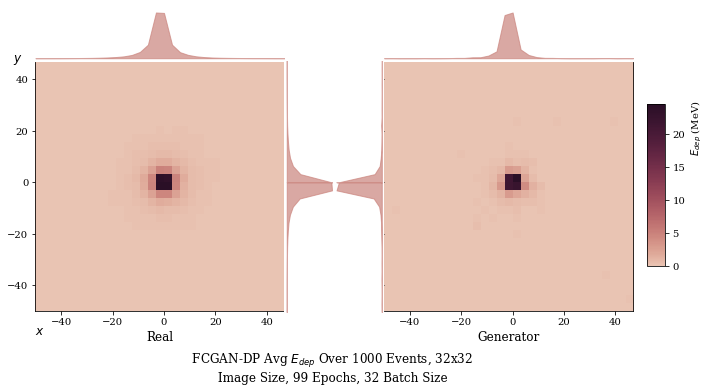

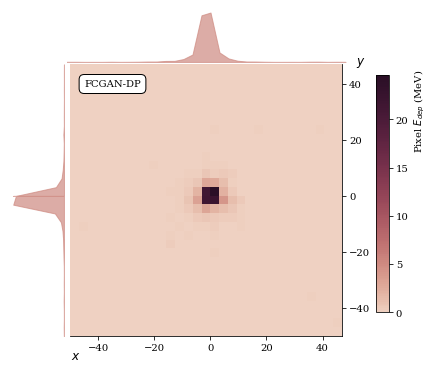

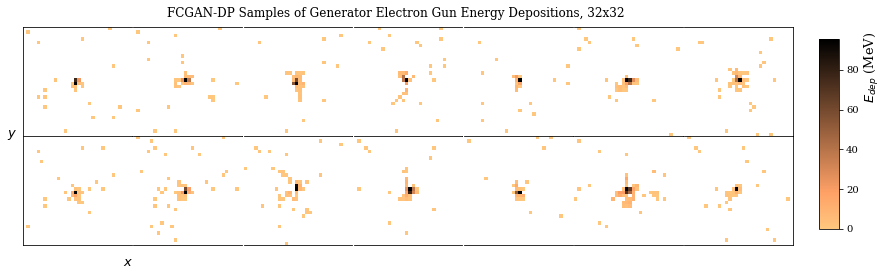

0.13478437 0.19919623946508758
(32,)


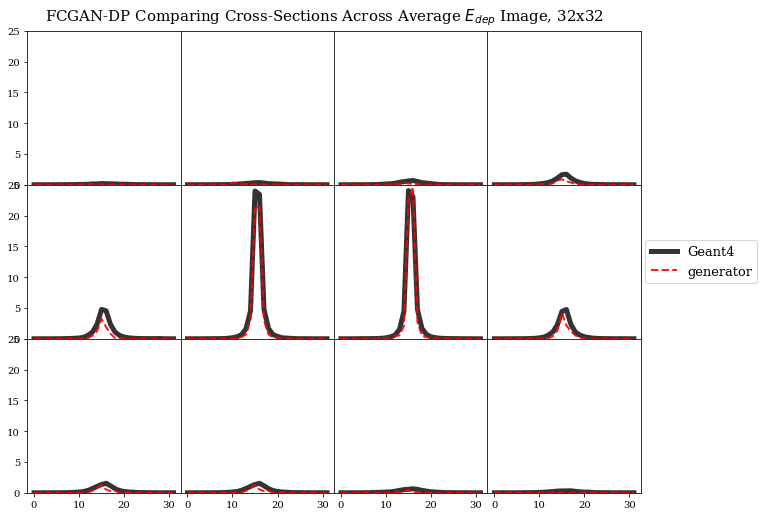

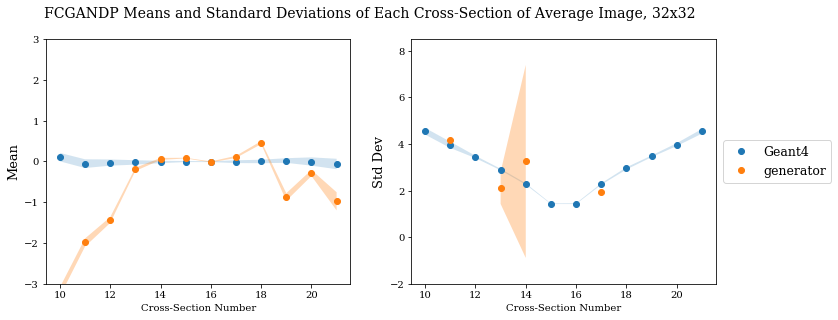

[99/100][0/938] Loss_D: 0.1344 Loss_G: 6.0159 D(x): 0.9780 D(G(z)): 0.0485 / 0.0086
[99/100][100/938] Loss_D: 0.1027 Loss_G: 6.8557 D(x): 0.9469 D(G(z)): 0.0233 / 0.0121
[99/100][200/938] Loss_D: 0.0950 Loss_G: 6.6823 D(x): 0.9777 D(G(z)): 0.0483 / 0.0075
[99/100][300/938] Loss_D: 0.1945 Loss_G: 6.6273 D(x): 0.9342 D(G(z)): 0.0425 / 0.0094
[99/100][400/938] Loss_D: 0.1898 Loss_G: 6.5327 D(x): 0.9849 D(G(z)): 0.0685 / 0.0083
[99/100][500/938] Loss_D: 0.1778 Loss_G: 7.0844 D(x): 0.9335 D(G(z)): 0.0094 / 0.0063
[99/100][600/938] Loss_D: 0.1208 Loss_G: 6.7141 D(x): 0.9327 D(G(z)): 0.0232 / 0.0069
[99/100][700/938] Loss_D: 0.0394 Loss_G: 6.4161 D(x): 0.9772 D(G(z)): 0.0112 / 0.0088
[99/100][800/938] Loss_D: 0.1781 Loss_G: 6.5775 D(x): 0.9399 D(G(z)): 0.0203 / 0.0101
[99/100][900/938] Loss_D: 0.1042 Loss_G: 7.1297 D(x): 0.9336 D(G(z)): 0.0154 / 0.0070
(32, 32)


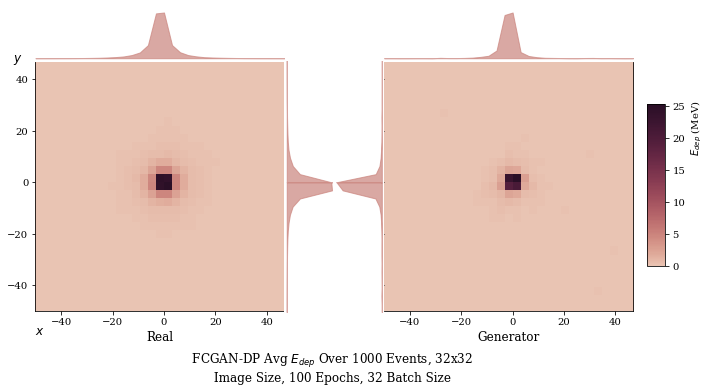

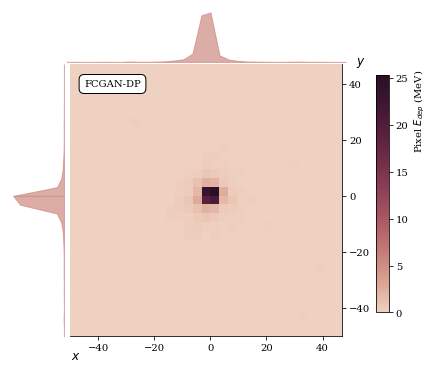

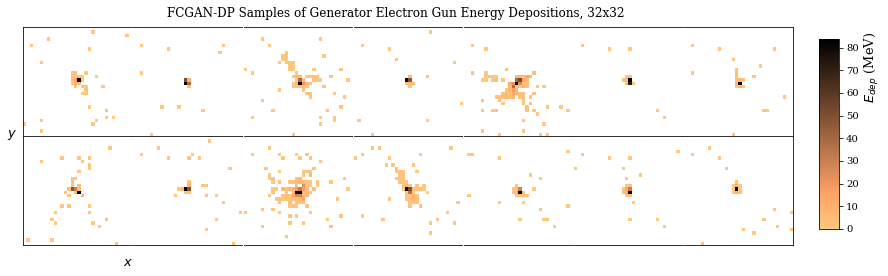

0.12659669 0.20216222594828628
(32,)


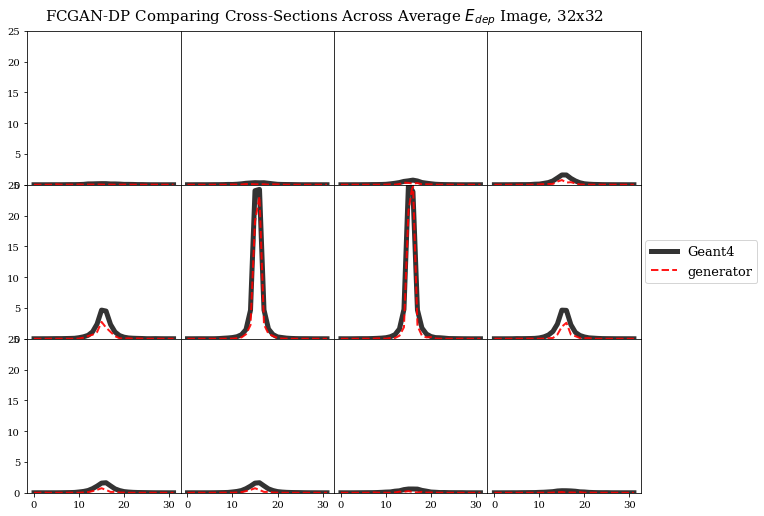

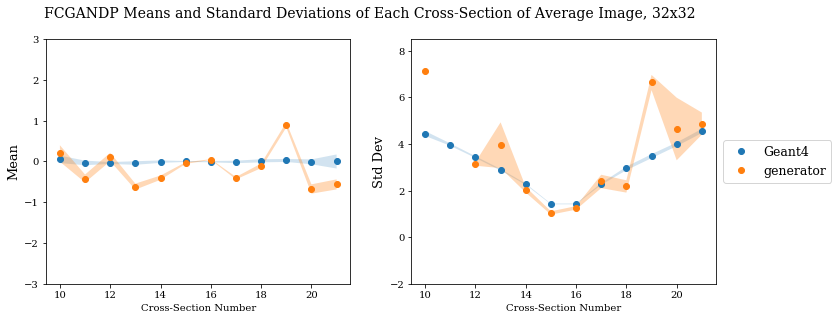

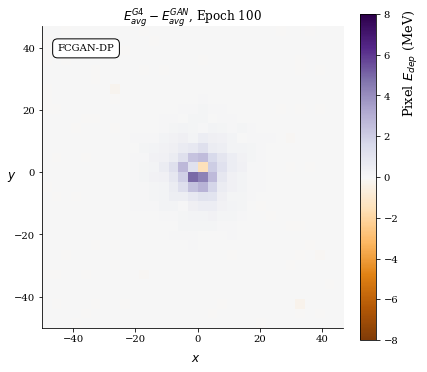

[100/100][0/938] Loss_D: 0.2591 Loss_G: 6.2329 D(x): 0.9847 D(G(z)): 0.0921 / 0.0162
[100/100][100/938] Loss_D: 0.1210 Loss_G: 6.3075 D(x): 0.9327 D(G(z)): 0.0226 / 0.0093
[100/100][200/938] Loss_D: 0.2139 Loss_G: 5.7328 D(x): 0.9650 D(G(z)): 0.0660 / 0.0119
[100/100][300/938] Loss_D: 0.2318 Loss_G: 6.2580 D(x): 0.9395 D(G(z)): 0.0461 / 0.0094
[100/100][400/938] Loss_D: 0.1438 Loss_G: 6.1637 D(x): 0.9718 D(G(z)): 0.0767 / 0.0112
[100/100][500/938] Loss_D: 0.0493 Loss_G: 7.2924 D(x): 0.9668 D(G(z)): 0.0110 / 0.0098
[100/100][600/938] Loss_D: 0.1346 Loss_G: 6.3554 D(x): 0.9853 D(G(z)): 0.0812 / 0.0053
[100/100][700/938] Loss_D: 0.0461 Loss_G: 8.6656 D(x): 0.9687 D(G(z)): 0.0101 / 0.0054
[100/100][800/938] Loss_D: 0.0393 Loss_G: 6.3652 D(x): 0.9754 D(G(z)): 0.0128 / 0.0073
[100/100][900/938] Loss_D: 0.1751 Loss_G: 6.9820 D(x): 0.9468 D(G(z)): 0.0593 / 0.0049
(32, 32)


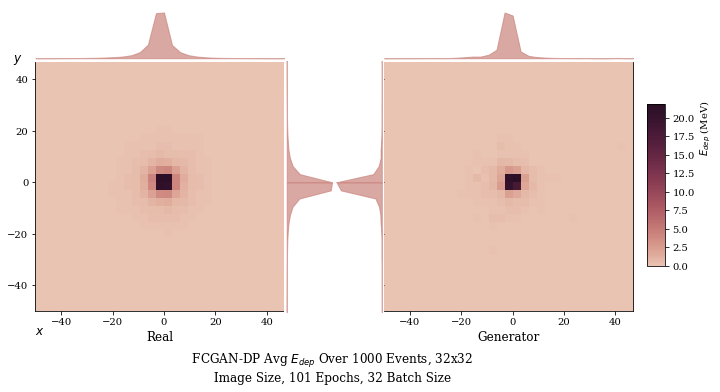

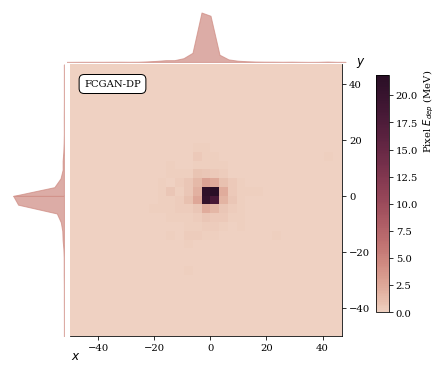

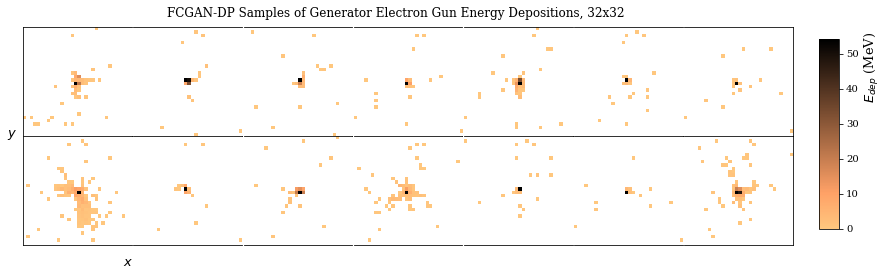

0.124497764 0.193696655285448
(32,)


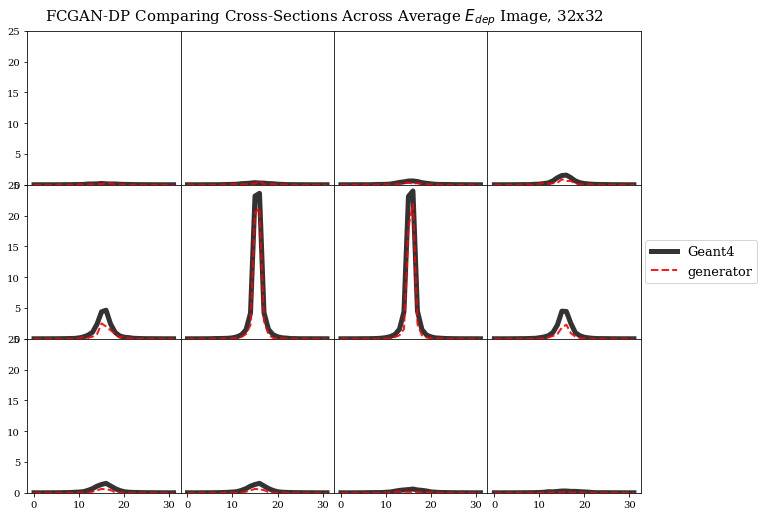

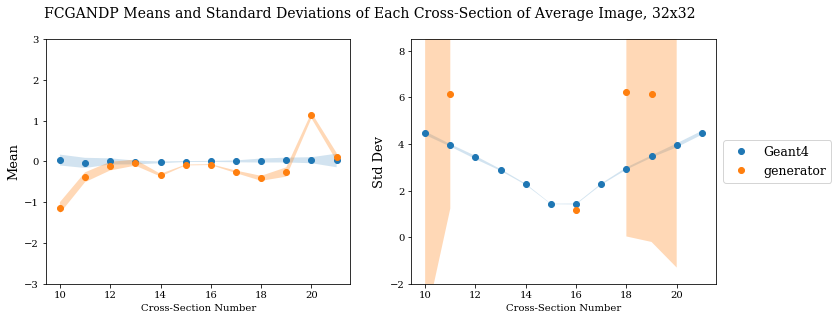

[101/100][0/938] Loss_D: 0.1278 Loss_G: 6.8545 D(x): 0.9772 D(G(z)): 0.0602 / 0.0070
[101/100][100/938] Loss_D: 0.3275 Loss_G: 6.4256 D(x): 0.9102 D(G(z)): 0.0886 / 0.0096
[101/100][200/938] Loss_D: 0.0629 Loss_G: 6.6438 D(x): 0.9771 D(G(z)): 0.0318 / 0.0094
[101/100][300/938] Loss_D: 0.1922 Loss_G: 6.4471 D(x): 0.9381 D(G(z)): 0.0066 / 0.0063
[101/100][400/938] Loss_D: 0.0973 Loss_G: 7.3221 D(x): 0.9812 D(G(z)): 0.0477 / 0.0035
[101/100][500/938] Loss_D: 0.2494 Loss_G: 7.1838 D(x): 0.9630 D(G(z)): 0.0694 / 0.0064
[101/100][600/938] Loss_D: 0.0783 Loss_G: 5.6036 D(x): 0.9666 D(G(z)): 0.0361 / 0.0165
[101/100][700/938] Loss_D: 0.0431 Loss_G: 6.9575 D(x): 0.9808 D(G(z)): 0.0192 / 0.0054
[101/100][800/938] Loss_D: 0.1060 Loss_G: 6.9541 D(x): 0.9439 D(G(z)): 0.0162 / 0.0116
[101/100][900/938] Loss_D: 0.2330 Loss_G: 7.3233 D(x): 0.9231 D(G(z)): 0.0787 / 0.0042
(32, 32)


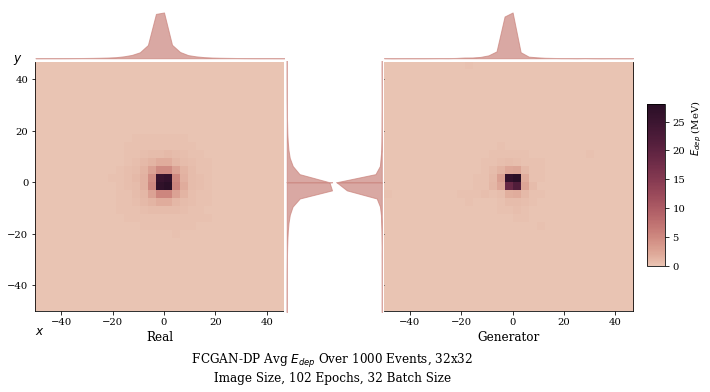

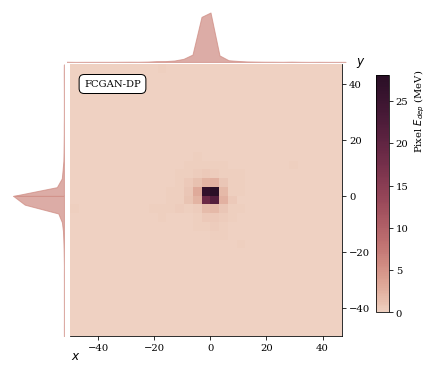

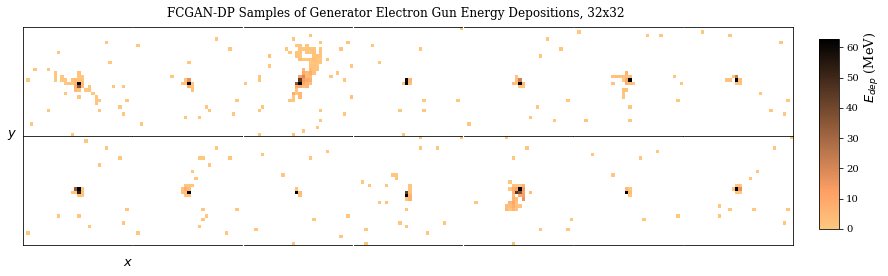

0.13334844 0.1939900345086939
(32,)


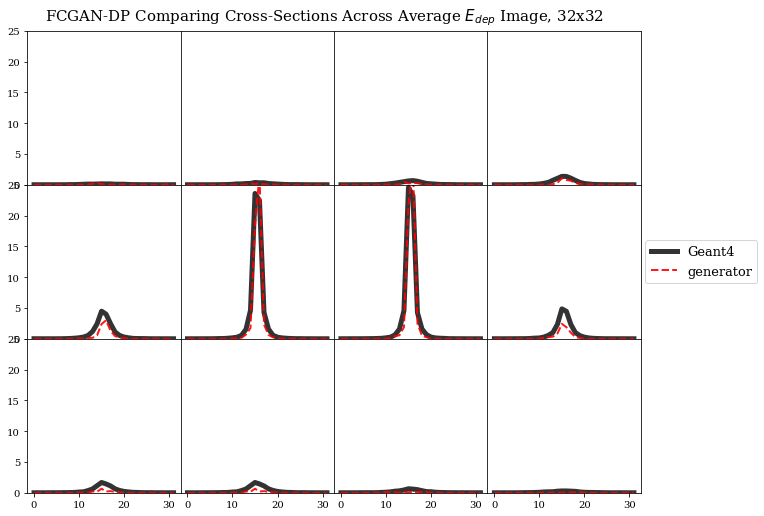

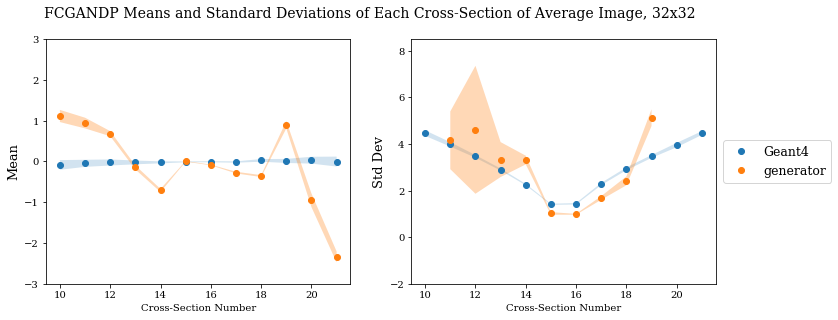

[102/100][0/938] Loss_D: 0.1795 Loss_G: 6.2169 D(x): 0.9852 D(G(z)): 0.1031 / 0.0157
[102/100][100/938] Loss_D: 0.2066 Loss_G: 7.7953 D(x): 0.9390 D(G(z)): 0.0730 / 0.0052
[102/100][200/938] Loss_D: 0.0456 Loss_G: 6.1565 D(x): 0.9772 D(G(z)): 0.0195 / 0.0120
[102/100][300/938] Loss_D: 0.1400 Loss_G: 4.9767 D(x): 0.9427 D(G(z)): 0.0445 / 0.0188
[102/100][400/938] Loss_D: 0.0576 Loss_G: 6.7632 D(x): 0.9831 D(G(z)): 0.0343 / 0.0100
[102/100][500/938] Loss_D: 0.1554 Loss_G: 7.1363 D(x): 0.9613 D(G(z)): 0.0586 / 0.0057
[102/100][600/938] Loss_D: 0.0822 Loss_G: 6.6612 D(x): 0.9651 D(G(z)): 0.0258 / 0.0111
[102/100][700/938] Loss_D: 0.0375 Loss_G: 7.7730 D(x): 0.9728 D(G(z)): 0.0057 / 0.0029
[102/100][800/938] Loss_D: 0.1782 Loss_G: 7.2798 D(x): 0.9562 D(G(z)): 0.0644 / 0.0078
[102/100][900/938] Loss_D: 0.1333 Loss_G: 6.8651 D(x): 0.9622 D(G(z)): 0.0403 / 0.0099
(32, 32)


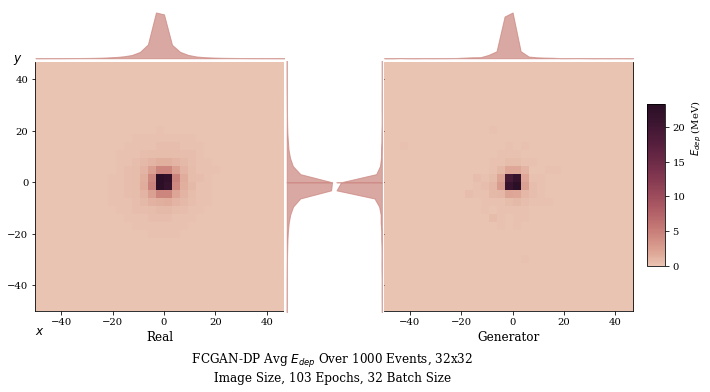

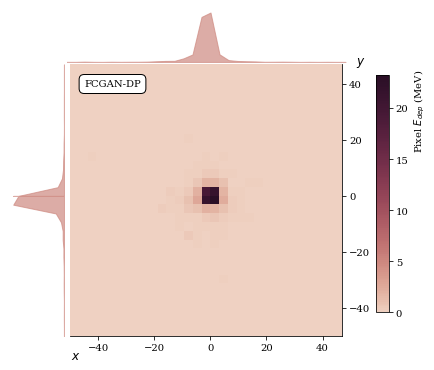

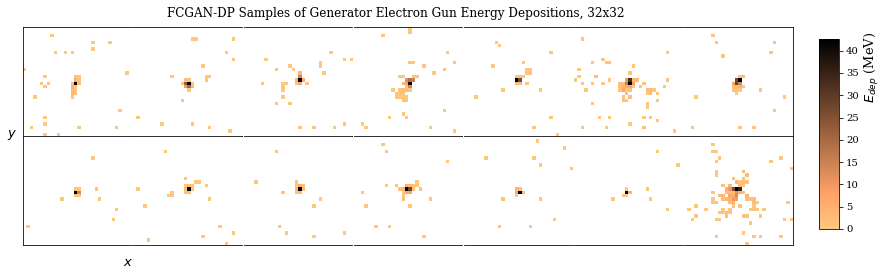

0.12322196 0.194993914966601
(32,)


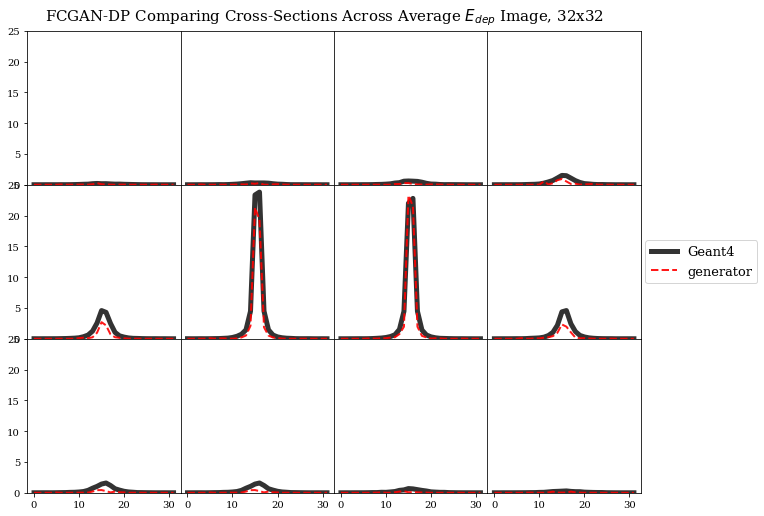

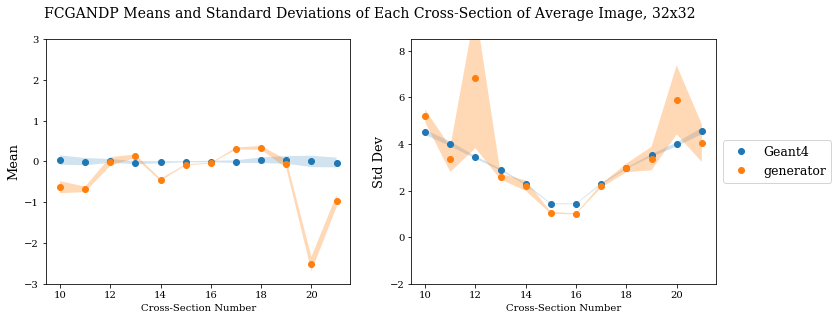

[103/100][0/938] Loss_D: 0.0823 Loss_G: 7.3551 D(x): 0.9734 D(G(z)): 0.0385 / 0.0052
[103/100][100/938] Loss_D: 0.0681 Loss_G: 7.3494 D(x): 0.9525 D(G(z)): 0.0062 / 0.0060
[103/100][200/938] Loss_D: 0.0838 Loss_G: 5.8965 D(x): 0.9555 D(G(z)): 0.0263 / 0.0129
[103/100][300/938] Loss_D: 0.1407 Loss_G: 7.6893 D(x): 0.9517 D(G(z)): 0.0512 / 0.0086
[103/100][400/938] Loss_D: 0.1683 Loss_G: 6.7700 D(x): 0.9424 D(G(z)): 0.0604 / 0.0076
[103/100][500/938] Loss_D: 0.1413 Loss_G: 6.9868 D(x): 0.9843 D(G(z)): 0.0483 / 0.0077
[103/100][600/938] Loss_D: 0.2846 Loss_G: 7.2939 D(x): 0.9543 D(G(z)): 0.0855 / 0.0108
[103/100][700/938] Loss_D: 0.0328 Loss_G: 9.0242 D(x): 0.9846 D(G(z)): 0.0156 / 0.0062
[103/100][800/938] Loss_D: 0.0654 Loss_G: 8.2295 D(x): 0.9764 D(G(z)): 0.0354 / 0.0026
[103/100][900/938] Loss_D: 0.2056 Loss_G: 7.4176 D(x): 0.9019 D(G(z)): 0.0038 / 0.0038
(32, 32)


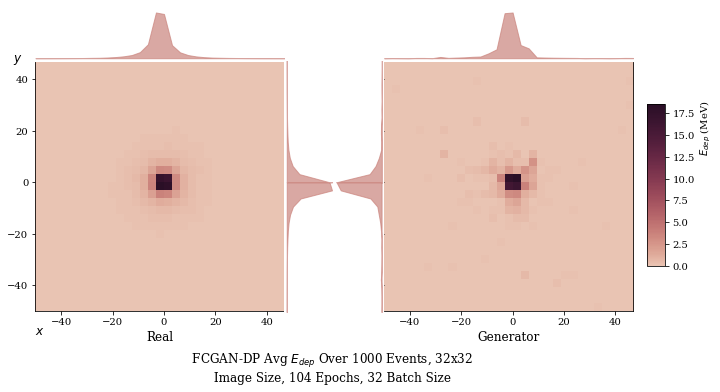

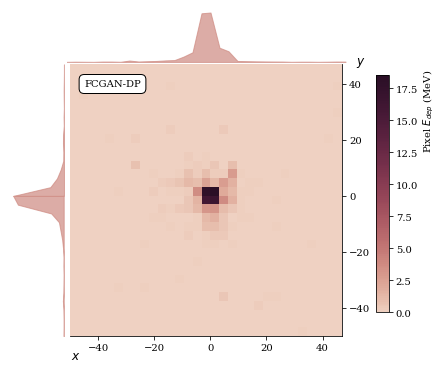

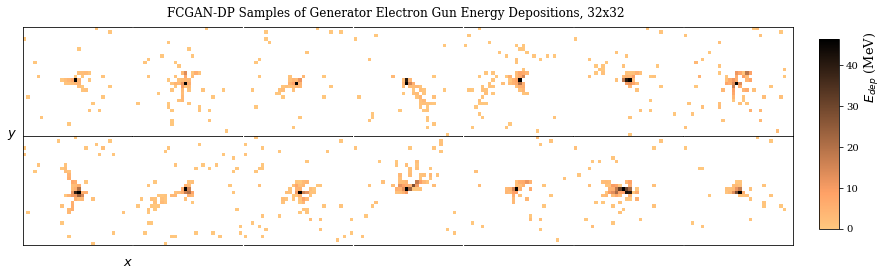

0.13052097 0.19802946710485708
(32,)


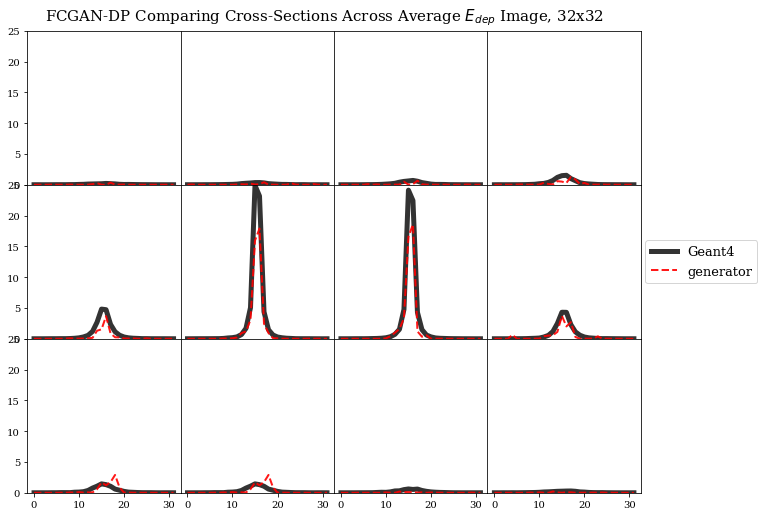

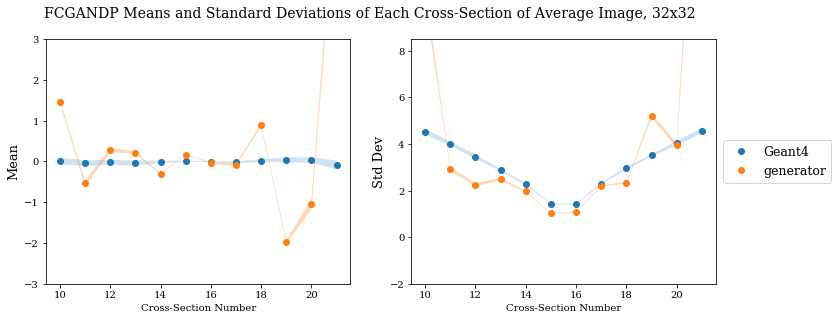

[104/100][0/938] Loss_D: 0.3155 Loss_G: 7.3903 D(x): 0.9117 D(G(z)): 0.0477 / 0.0061
[104/100][100/938] Loss_D: 0.0936 Loss_G: 9.7237 D(x): 0.9498 D(G(z)): 0.0155 / 0.0079
[104/100][200/938] Loss_D: 0.0521 Loss_G: 8.4729 D(x): 0.9645 D(G(z)): 0.0046 / 0.0027
[104/100][300/938] Loss_D: 0.1474 Loss_G: 7.6400 D(x): 0.9734 D(G(z)): 0.0532 / 0.0047
[104/100][400/938] Loss_D: 0.0997 Loss_G: 7.6222 D(x): 0.9529 D(G(z)): 0.0306 / 0.0053
[104/100][500/938] Loss_D: 0.0794 Loss_G: 8.8018 D(x): 0.9629 D(G(z)): 0.0272 / 0.0028
[104/100][600/938] Loss_D: 0.1274 Loss_G: 6.6642 D(x): 0.9424 D(G(z)): 0.0260 / 0.0132
[104/100][700/938] Loss_D: 0.2587 Loss_G: 9.3437 D(x): 0.9405 D(G(z)): 0.0550 / 0.0266
[104/100][800/938] Loss_D: 0.2231 Loss_G: 7.1640 D(x): 0.9304 D(G(z)): 0.0865 / 0.0104
[104/100][900/938] Loss_D: 0.5478 Loss_G: 7.5288 D(x): 0.9514 D(G(z)): 0.1725 / 0.0170
(32, 32)


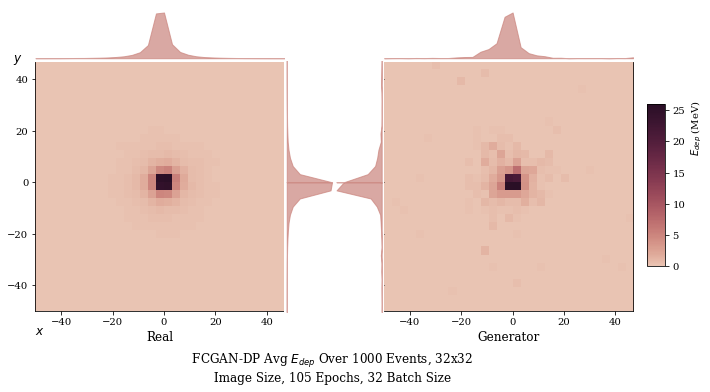

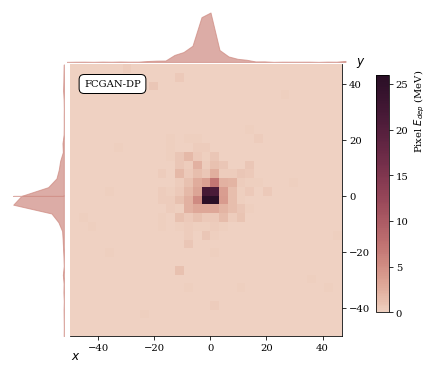

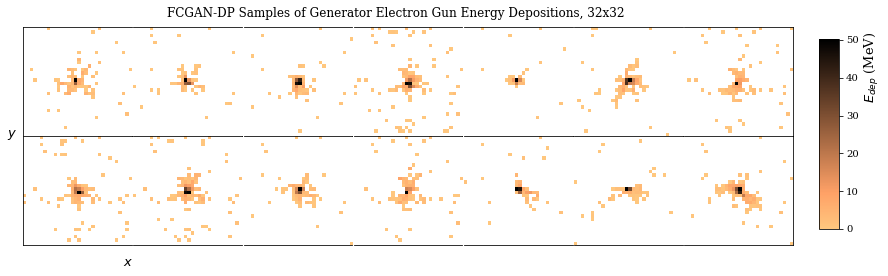

0.20081834 0.19623882405403725
(32,)


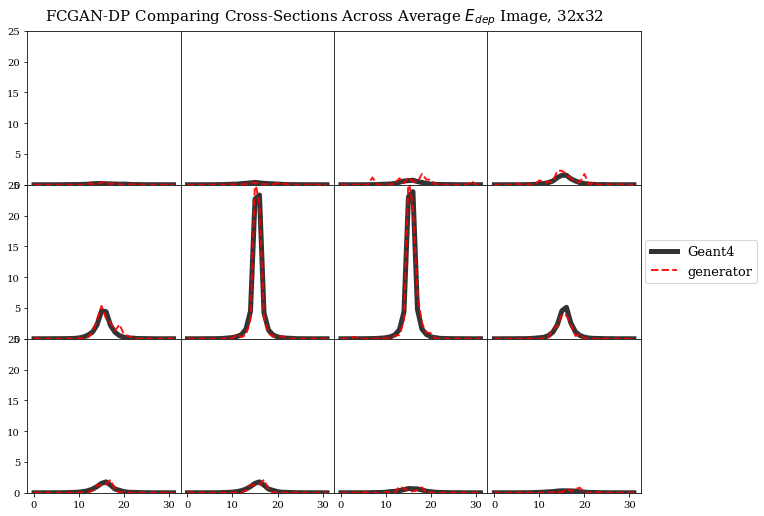

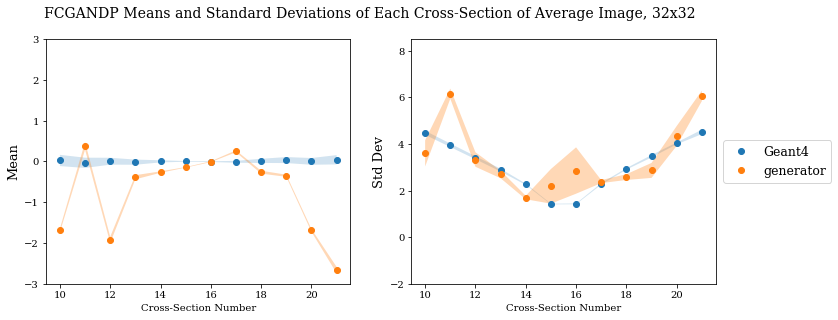

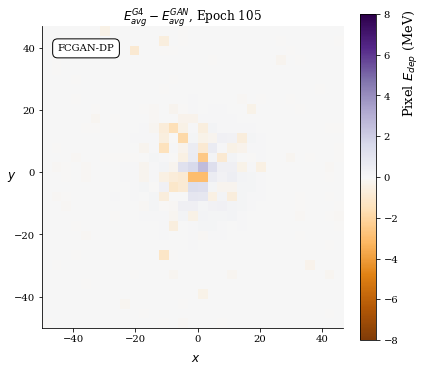

[105/100][0/938] Loss_D: 0.1751 Loss_G: 7.0815 D(x): 0.9416 D(G(z)): 0.0434 / 0.0164
[105/100][100/938] Loss_D: 0.2847 Loss_G: 7.9158 D(x): 0.9199 D(G(z)): 0.0335 / 0.0083
[105/100][200/938] Loss_D: 0.0878 Loss_G: 8.9634 D(x): 0.9616 D(G(z)): 0.0401 / 0.0057
[105/100][300/938] Loss_D: 0.1934 Loss_G: 6.6573 D(x): 0.9082 D(G(z)): 0.0404 / 0.0082
[105/100][400/938] Loss_D: 0.1807 Loss_G: 7.4481 D(x): 0.9272 D(G(z)): 0.0489 / 0.0104
[105/100][500/938] Loss_D: 0.3236 Loss_G: 8.9609 D(x): 0.9159 D(G(z)): 0.0144 / 0.0078
[105/100][600/938] Loss_D: 0.3782 Loss_G: 7.7024 D(x): 0.9461 D(G(z)): 0.1192 / 0.0036
[105/100][700/938] Loss_D: 0.1089 Loss_G: 6.7059 D(x): 0.9450 D(G(z)): 0.0301 / 0.0124
[105/100][800/938] Loss_D: 0.0662 Loss_G: 7.3598 D(x): 0.9751 D(G(z)): 0.0322 / 0.0111
[105/100][900/938] Loss_D: 0.1554 Loss_G: 8.0918 D(x): 0.9806 D(G(z)): 0.0837 / 0.0040
(32, 32)


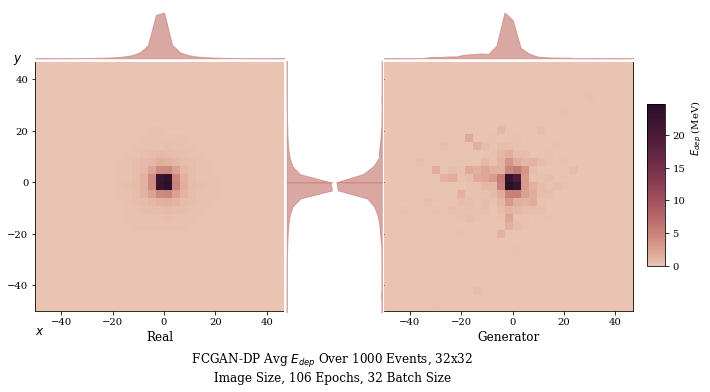

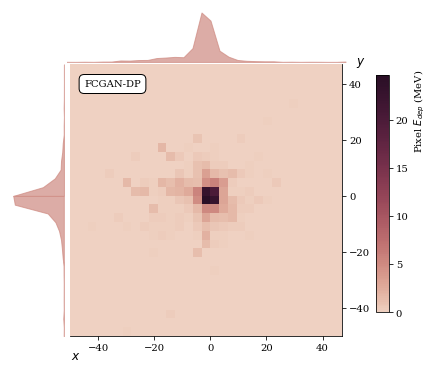

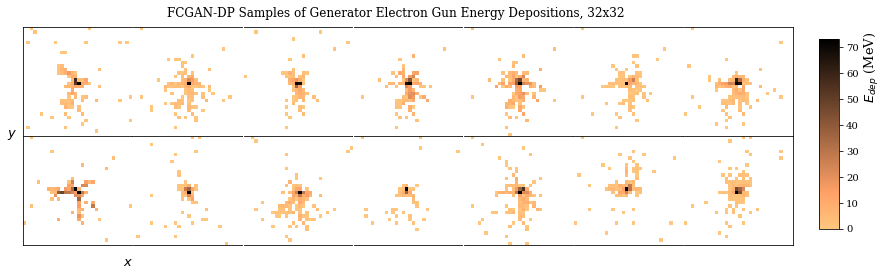

0.21436597 0.1954041329142447
(32,)


KeyboardInterrupt: 

In [152]:
iter_range = range(55, 55+ niter)
iter_range = tqdm(iter_range)


#make save directory
#mydir = os.path.join('/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/FC', 
#                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
#mydir=None
print(mydir)
#if mydir != None:
#    try:
#        os.makedirs(mydir)
#    except OSError as e:
#        if e.errno != errno.EEXIST:
#            raise
            
#    with open(mydir + 'NetworkInfo.txt', 'w') as f:
#        f.write( 'generator: ' +  str(netG) + "\n")
#        f.write('discriminator: ' +  str(netD) + '\n')
#        f.write('normalization scale: ' +  norm_scale + '\n')
#        f.write('image height/width: ' + str(imageSize) + '\n')
#        f.write('loss function: BCE with Roth Penalty \n')

extraD = 1
gamma=0.1
        
for epoch in iter_range:
    if True:       
        data, n_events = make_samples(netG, n_events = 1000, scale =scale, norm_scale=norm_scale)
        real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 1000,real= True, fake = True, 
                                                                scale = scale, norm_scale = norm_scale)
        print(data[1].shape)
        #print(data[1].shape)
        #genx_FWHM = hist_width(np.sum(data[1],1))
        #realx_FWHM = hist_width(np.sum(data[0],1))
        #genx_mean = np.sum(data[1],1).mean()
        #print genx_mean
        #realx_mean = np.sum(data[0],1).mean()
        #genx_FWHMs.append(genx_FWHM)
        #realx_FWHMs.append(realx_FWHM)
        #genx_means.append(genx_mean)
        #realx_means.append(realx_mean)
        epochs.append(epoch)
        #plot_all_metrics(genx_FWHMs, realx_FWHMs, genx_means, realx_means,epochs = epochs, save_dir = mydir)
        #plot_sns(n_events, save_dir=mydir,  epoch = epoch)
        plot_avg_both(data[0],data[1], n_events, save_dir = mydir,  epoch = epoch)
        plot_avg(data[1], n_events, save_dir= mydir,  epoch = epoch)
        plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch)
        xsection_multi(data, epoch, savedir=mydir, imageSize=imageSize)
        if epoch > 0:
            stats_r, stats_f = calc_means_stds(imageSize=imageSize, n_times = 10)
            plot_means_stds(stats_r, stats_f, save_dir = mydir, trim = 10)
        #plot_many(fake_data_array, real=False, save_dir=mydir, epoch = epoch)
        #plot_many(real_data_array, real=True, save_dir=mydir, epoch = epoch)
        if epoch % 5 == 0:
            plot_difference(data, save_dir = mydir, epoch = epoch, n_events = 1000)
    for i, data in enumerate(dataloader,0):
        for j in range(extraD):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))), do it more than generator
            ###########################
            # train with real
            netD.zero_grad()
            real_cpu = data[0].to(device).requires_grad_().view(-1,imageSize*imageSize)
            #print(real_cpu.shape)
            batch_size = real_cpu.size(0)
            label_r = torch.full((batch_size,), real_label, device=device)
            #real_cpu.requires_grad_()
            output_r = netD(real_cpu)
            #real_cpu.requires_grad_()
            #output_r.sum().requires_grad_()
            errD_real = criterion(output_r, label_r)
            #errD_real.backward()
            D_x = output_r.mean().item()
            penalty = grad(output_r.sum(), real_cpu, create_graph=True)[0].view(-1,1).norm(2,1).pow(2).mean()
            (errD_real + (gamma/2) * penalty).backward()
            #print(penalty)


            # train with fake
            noise = torch.randn(batch_size, nz, device=device)
            fake = netG(noise)
            label_f = torch.full((batch_size,), fake_label, device=device)
            #label.fill_(fake_label)
            output_f = netD(fake.detach())
            errD_fake = criterion(output_f, label_f)
            errD_fake.backward()
            D_G_z1 = output_f.mean().item()
            errD = errD_real + errD_fake
            #(errD + (gamma/2) * penalty).backward()
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label_r.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label_r)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
#         if i % 500 == 0:
#             vutils.save_image(real_cpu.data,
#                     '%s/real_samples.png' % outf,
#                     normalize=True)
#             fake = netG(fixed_noise)
#             vutils.save_image(fake.detach(),
#                     '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
#                    normalize=True)

/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/ipykernel_launcher.py:733: RuntimeWarning: invalid value encountered in sqrt


(32,)


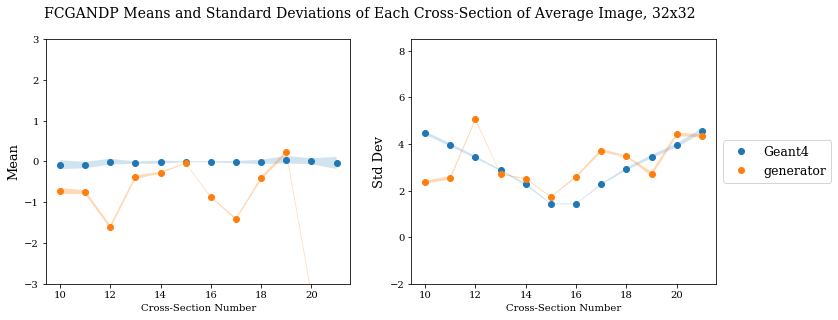

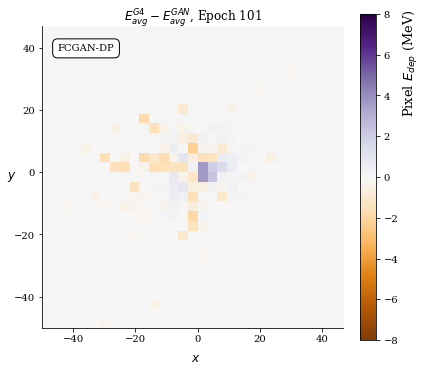

In [153]:
#FAKE
#from mpl_toolkits.axes_grid1 import make_axes_locatable



#data, n_events = make_samples(netG,n_events = 1000, real=True, fake=True)

#data_diff = data_test[0] - data_test[1]
#plot_avg(data[1], n_events = 1000, save_dir=None)
stats_r, stats_f = calc_means_stds(imageSize=imageSize, n_times = 10)
plot_means_stds(stats_r, stats_f, save_dir = mydir, trim = 10)
data, n_events = make_samples(netG, n_events = 1000, scale =scale, norm_scale=norm_scale)
plot_difference(data, save_dir = mydir, epoch = 101, n_events = 1000)

/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in less


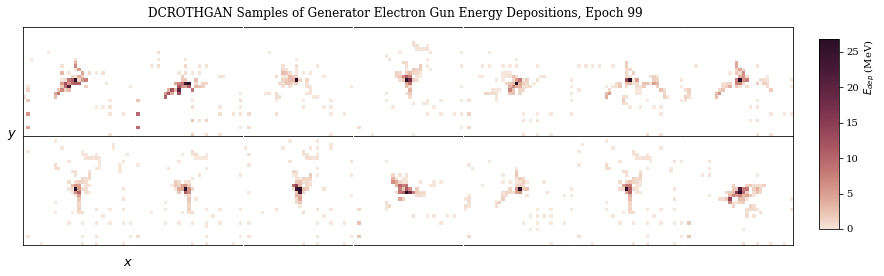

In [189]:
# mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/', 
#                      datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
# #mydir=None
# print(mydir)
# try:
#     os.makedirs(mydir)
# except OSError as e:
#     if e.errno != errno.EEXIST:
#         raise
        

#plot_sns(save_dir = None)
#real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 1000,real= True, fake = True)
plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch)

In [54]:
test = np.squeeze(image_array)
for i in range(test.shape[0]):
    if np.isnan(test[i].max()) ==True:
        print(i)

In [ ]:
#REAL
plt.rc('font', family='serif')
many_samples = True
n_events = 5000
#make single samples for both real and fake. then make many samples and average if many_samples = True

#real
idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
real_image = image_array[idx][0]

#fake
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(noise)
fake_image = fake.to('cpu').detach().numpy()[0][0]
test_unnormed =  arctanh_unnormalize(fake_image, scale)

if many_samples == True:
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        fake_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed +=  arctanh_unnormalize(fake_image, scale)

real_image = real_image / n_events
test_unnormed = test_unnormed / n_events
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(9, 6), sharex=True, sharey=True)
xran = (-50,50)
yran = (-50,50)
extent = xran + yran





real_image[real_image < 0.0] = np.nan
cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
im = ax1.imshow(real_image, vmin = 0, extent=extent, origin='lower', cmap=cmap)




ax1.set_title("Real")
#cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
#cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        
test_unnormed[test_unnormed < 0.0] = np.nan
im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
ax2.set_title("Generator")

fig.tight_layout(rect=[0, 0, .9, 1])
cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
fig.subplots_adjust(wspace=0.1, hspace=0)
fig.suptitle(r" DCROTHGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
             + str(imageSize) + "x" +str(imageSize) + " Image Size, " + str(niter) 
             + " Epochs, " + str(batchSize) + " Batch Size", x = 0.5, y = 0.9)
plt.show()

In [412]:
mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '/')
print(mydir)
try:
    os.makedirs(mydir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/2018-05-16_17-09-05/


In [293]:
data_test, n_events = make_samples(netG,n_events = 10000, real=True, fake=True)
mydir = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/2018-05-18_18-39-35/"

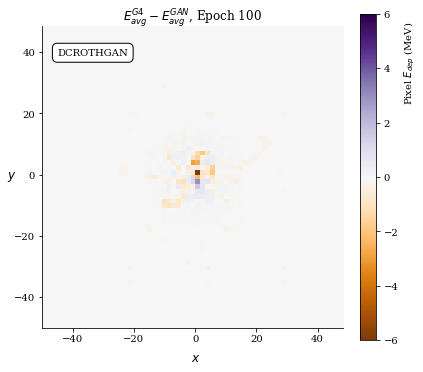

In [320]:

def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
    data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
    test_noNans = np.copy(data)
    test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    #cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
    #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
    #cmap = sns.color_palette("BrBG", 7, as_cmap=True)
    cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()


    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = -6,vmax = 6, extent=extent, origin='lower', cmap='PuOr', label ='DCROTHGAN')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    plt.title(r"$E_{avg}^{G4} - E_{avg}^{GAN}$, Epoch " + str(epoch))
    ax.text(-45, 39, 'DCROTHGAN', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    #plt.legend(loc = 'best')
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.51,-0.08)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(-.1,0.48)
    ax.spines["top"].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')

    plt.show()
    return

plot_difference(data_test, save_dir = mydir, epoch = 100)


In [ ]:

def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale)
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
withMarginals = False
save_dir = mydir
test_noNans = np.copy(data)
test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

xran = (-50,50)
yran = (-50,50)
extent = xran + yran
#cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
#cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
#cmap = sns.color_palette("BrBG", 7, as_cmap=True)
cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()

if withMarginals == False:
    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = -6,vmax = 6, extent=extent, origin='lower', cmap='PuOr')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    plt.title("DCROTHGAN Difference between average Geant4 \n Image and Average Generator Image")
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')

else:
    fig=plt.figure(figsize=(6, 6))
    marginals_str = 'withMarginals'
    img=test_noNans
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())

    gs = gridspec.GridSpec(2, 2, width_ratios=[1,5], height_ratios=[1,5])
    gs.update(hspace=0, wspace=0)

    ax = fig.add_subplot(gs[1,1])
    im = ax.imshow(test_unnormed, vmin = -10, vmax = 10, extent = extent, origin = 'lower', cmap = 'PuOr')
    cbaxes = fig.add_axes([0.97, 0.18, 0.03, 0.55]) 
    cbar = plt.colorbar(mappable=im, ticks = None, cax=cbaxes, use_gridspec=True)
    ax.yaxis.set_ticks_position('right')
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    ax.spines["top"].set_visible(False)
    ax.spines['left'].set_visible(False)

    axl = fig.add_subplot(gs[1,0], sharey=ax)
    axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
    axl.invert_xaxis()
    axb = fig.add_subplot(gs[0,1], sharex=ax)
    axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])

    plt.setp(axl.get_yticklabels(), visible=False)
    plt.setp(axb.get_xticklabels(), visible=False)
    plt.setp(axl.get_xticklabels(), visible=False)
    plt.setp(axb.get_yticklabels(), visible=False)

    axl.yaxis.set_ticks_position('none')
    axb.xaxis.set_ticks_position('none')
    axl.xaxis.set_ticks_position('none')
    axb.yaxis.set_ticks_position('none')


    axl.spines["top"].set_visible(False)
    axl.spines['right'].set_visible(False)
    axl.spines['left'].set_visible(False)
    axl.spines['bottom'].set_visible(False)
    axb.spines["top"].set_visible(False)
    axb.spines["right"].set_visible(False)
    axb.spines["left"].set_visible(False)
    axb.spines["bottom"].set_visible(False)
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.02,-0.05)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(1.07,0.98)
    plt.title("DCROTHGAN Difference between average Geant4 Image \n and Average Generator Image")
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()


/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in less_equal


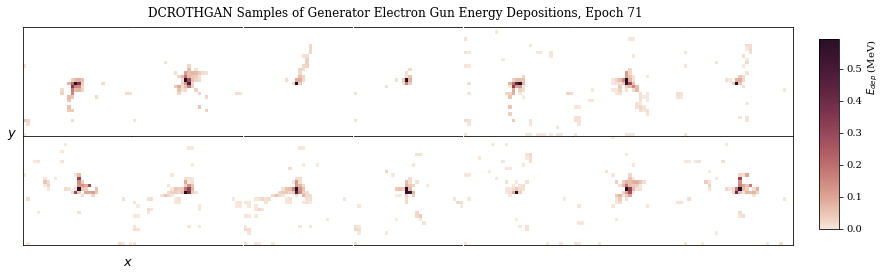

In [123]:
# def plot_many(data, rows = 1,columns = 4, real = True, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran
    
#     if rows <= 2 and columns <=4:
#         scale_factor = 3.5
#     else:
#         scale_factor = 2
    
#     fig, axes =plt.subplots(rows,columns, figsize=(scale_factor*columns, scale_factor*rows), sharex=True,sharey=True)
#     #print(len(axes))
#     event_number = 0
#     plt.locator_params(axis='y', nbins=1)
#     plt.locator_params(axis='x', nbins=2)
#     #fig.xticks(rotation=45)
#     for i in range(rows):
#         for j in range(columns):

#             #print(range(rows))
#             image_array = data[event_number]

#             image_array[image_array < 0.01] = np.nan
#             cmap = sns.cubehelix_palette(dark = 0.4, light=0.965, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#             #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
#             #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
#             #cmap = sns.color_palette("BrBG",7)
#             #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)
#             #axes[i,j].set_aspect('equal')
#             plt.axis('on')
#             if rows == 1:
#                 #axes[j] = plt.subplot(gs1[i,j])
#                 if j != 0:
#                     axes[j].spines['left'].set_visible(False)
#                 else:
#                     axes[j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
#                     axes[j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
#                 axes[j].spines['top'].set_visible(False)
#                 axes[j].spines['right'].set_visible(False)
#                 #axes[j].spines['bottom'].set_visible(False)
#                 #axes[j].spines['left'].set_visible(False)
#                 #axes[j].set_aspect('equal')
#                 im =axes[j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
#                 #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
#                 axes[j].set_xticklabels([])
#                 axes[j].set_yticklabels([])
#                 axes[j].xaxis.set_ticks_position('none')
#                 axes[j].yaxis.set_ticks_position('none')
#                 event_number +=1
#             else:
#                 #axes[i,j].spines['top'].set_visible(False)
#                 axes[i,j].spines['bottom'].set_visible(True)
#                 if j!= 0:
#                     axes[i,j].spines['left'].set_visible(False)
#                 if i == range(rows)[-1] and j == 0:
#                     axes[i,j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
#                     axes[i,j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                    
#                 if j == range(columns)[-1]:
#                     axes[i,j].spines['right'].set_visible(True)
#                 else:
#                     axes[i,j].spines['right'].set_visible(False)
#                 im =axes[i,j].imshow(image_array, vmin = 0,  extent=extent, origin='lower', cmap=cmap)
#                 #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
#                 axes[i,j].set_xticklabels([])
#                 axes[i,j].set_yticklabels([])
#                 axes[i,j].xaxis.set_ticks_position('none')
#                 axes[i,j].yaxis.set_ticks_position('none')
#                 event_number +=1
#     #fig.tight_layout(rect=[0, 0, .9, 1])
#     cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.66])
#    # fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
#     #fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)

#     cb = fig.colorbar(im, cax=cbar_ax)
#     cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
#     #plt.tight_layout()
#     fig.subplots_adjust(wspace=-0.085, hspace=0.00)
#     if real == True:
#         fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions", y = 0.95)
#     else:
#         fig.suptitle("DCROTHGAN Samples of Generator Electron Gun Energy Depositions, Epoch " + str(epoch), y=0.95)
    
#     num_samples = rows *columns
        
        
#     if save_dir != None:
#         if real == True:
#             type_string = "real"
#         else:
#             type_string = "fake"
        
#         learning_rate = '%.0E' % Decimal(lr)
#         #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
#         filename = "DCROTHGAN_"+str(num_samples) + type_string+ "SamplesEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                             + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
#         #print(save_dir)
#         plt.savefig(save_dir + filename, bbox_inches='tight')
    
        
#     plt.show()
#     return



plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch, norm_scale=norm_scale)

2.0272846


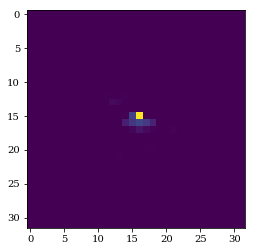

In [141]:
noise = torch.randn(batchSize, nz, 1, 1, device=device)
fake_output = netG(noise)
gen_image = fake_output.to('cpu').detach().numpy()[0][0]
print(gen_image.max())
plt.imshow(gen_image)

#data, n_events = make_samples(netG, n_events = 1000)
#real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 1000,real= True, fake = True)

In [47]:
fake_data_array.max()

9.704778